# Temporal Covariance Analysis of Pacific Herring from Alaska

##MD2000 from Raw_Variants and isec for 3 pops (Maf=0.05) 

In [6]:
import os
import sys

In [7]:
nb_dir = 'Users/kahotisthammer/programs/cvtkpy'
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [8]:
#%reload_ext autoreload

In [9]:
import re
from collections import defaultdict, Counter
from itertools import groupby, chain

In [10]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import statsmodels.api as sm
import allel as al

In [11]:
from cvtk.cvtk import TemporalFreqs, TiledTemporalFreqs
from cvtk.cov import stack_temporal_covariances
import cvtk.variant_files as vf
from cvtk.variant_files import VCFFile
from cvtk.gintervals import GenomicIntervals, GenomicInterval
from cvtk.pca import FreqPCA
from cvtk.plots import rep_plot_pca, correction_diagnostic_plot
from cvtk.utils import integerize, integerize_alternate
from cvtk.utils import extract_empirical_nulls_diagonals, extract_temporal_cov_diagonals
from cvtk.cov import stack_replicate_covariances, stack_temporal_covariances, stack_temporal_covs_by_group, cov_labels
from cvtk.cov import temporal_replicate_cov
from cvtk.bootstrap import block_bootstrap, cov_estimator, bootstrap_ci

/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/gintervals.py:138: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/gintervals.py:138: SyntaxWarning: "is not" with a literal. Did you mean "!="?


In [12]:
from cvtk.pca import FreqPCA

In [13]:
from cvtk.G import G_estimator

In [14]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.figsize'] = (8.0, 4.0)
mpl.rcParams['figure.dpi'] = 200

## Load in Data

Load in the cleaned and combined metadata created in the Herring scripts. 


In [15]:
md = pd.read_csv('PH_Samples_TempCov.csv')
md

,time,pop,year,abbrv_year,sample,real
0,0,PWS,1991,91,PWS91,True
1,1,PWS,1996,96,PWS96,True
2,2,PWS,2006,6,PWS06,True
3,3,PWS,2017,17,PWS17,True
4,0,SS,1991,91,SS91,False
5,1,SS,1996,96,SS96,True
6,2,SS,2006,6,SS06,True
7,3,SS,2017,17,SS17,True
8,0,TB,1991,91,TB91,True
9,1,TB,1996,96,TB96,True


## Load in VCF file:

In [16]:
var_file = '/Users/kahotisthammer/Projects/PacHerring_Temporal/data/vcf/3pops.MD2000_new.maf05.vcf.gz'

In [17]:
vcf = VCFFile(var_file)

reading file '/Users/kahotisthammer/Projects/PacHerring_Temporal/data/vcf/3pops.MD2000_new.maf05.vcf.gz'...
file '/Users/kahotisthammer/Projects/PacHerring_Temporal/data/vcf/3pops.MD2000_new.maf05.vcf.gz' loaded.
total time to load VCF file: 1.0644840836524962 mins.


In [18]:
vcf.geno_mat.shape
# 351820

(351820, 686, 2)

In [45]:
def parse_sample(x):
    "Parse out the sample metadata from the VCF."
    ind, pop, year = re.match(r'(?P<ind>[^_]+)_(?P<pop>[A-Z]+)(?P<year>[0-9]+)', x).groups()
    sample = pop + year
    return (ind, pop, year, sample)

vcf_md = pd.DataFrame([parse_sample(str(x)) for x in vcf.samples],
                     columns = ['ind', 'pop', 'year', 'sample'])

## Group them into Populations 

In [46]:
# now we make this into a nice dictionary of subpops to indices
subpops = defaultdict(list)
for i, sample in enumerate(vcf_md['sample']):
    subpops[sample].append(i)

In [47]:
counts_mat = vcf.count_alleles_subpops(subpops)

/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [48]:
freq_mat_all = vcf.calc_freqs()

In [49]:
depths_mat_all = vcf.N.astype('f')

Now we use the augmented design to build out the full frequency matrix. If there's a missing timepoint, the matrix of freqs is filled with NANs.

In [50]:
ndiploids = {k:len(subpops[k]) for k in vcf.subpops}
ndiploids['PWS06'] = ndiploids['PWS07']
del ndiploids['PWS07']
ndiploids

{'PWS17': 56,
 'PWS91': 58,
 'PWS96': 72,
 'SS06': 41,
 'SS17': 64,
 'SS96': 78,
 'TB06': 52,
 'TB17': 72,
 'TB91': 74,
 'TB96': 73,
 'PWS06': 46}

In [51]:
subpops_lkup = {sp:i for i, sp in enumerate(vcf.subpops)}
subpops_lkup['PWS06'] = subpops_lkup['PWS07']
del subpops_lkup['PWS07']
subpops_lkup

{'PWS17': 1,
 'PWS91': 2,
 'PWS96': 3,
 'SS06': 4,
 'SS17': 5,
 'SS96': 6,
 'TB06': 7,
 'TB17': 8,
 'TB91': 9,
 'TB96': 10,
 'PWS06': 0}

In [52]:
nloci = freq_mat_all.shape[1]

In [53]:
new_freqs = []
new_depths = []
new_samples = []
new_ndiploids = []

for row in md.itertuples():
    sample = row.sample
    if not row.real:
        print(sample + " is a NA sample")
        freqs = np.empty((nloci))
        freqs[:] = np.nan
        depths = np.empty((nloci))
        depths[:] = np.nan
        ndips = 0   
    else:
        freqs = freq_mat_all[subpops_lkup[sample], :]
        depths = depths_mat_all[subpops_lkup[sample], :]        
        ndips = ndiploids[sample]
    new_freqs.append(freqs)
    new_depths.append(depths)
    new_samples.append((row.pop, row.year))
    new_ndiploids.append(ndips)
    
full_depths_mat = np.row_stack(new_depths)
full_depths_mat.shape

SS91 is a NA sample


(12, 351820)

In [54]:
full_freq_mat = np.row_stack(new_freqs)
full_freq_mat.shape

(12, 351820)

In [55]:
new_samples

[('PWS', 1991),
 ('PWS', 1996),
 ('PWS', 2006),
 ('PWS', 2017),
 ('SS', 1991),
 ('SS', 1996),
 ('SS', 2006),
 ('SS', 2017),
 ('TB', 1991),
 ('TB', 1996),
 ('TB', 2006),
 ('TB', 2017)]

## Building the Temporal Freqs Object

First, we need to build the tiled `TemporalFreqs` object. We load in the sequence lengths.

In [56]:
sl_d = pd.read_csv('../data/vcf/chr_sizes.bed', delimiter='\t', names=['chrom', 'start', 'end'], header=None)

seqlens = dict(zip(sl_d['chrom'].values, sl_d['end'].values))

In [57]:
#100,000 interval 
tile_width = 100000
tiles = GenomicIntervals.from_tiles(seqlens, width=tile_width)

In [58]:
tile_width

100000

In [59]:
tiles

GenomicIntervals — 26 unique seqids, 7242 features
         GenomicInterval
0       chr1:[0, 100000)
1  chr1:[100000, 200000)
2  chr1:[200000, 300000)
3  chr1:[300000, 400000)
4  chr1:[400000, 500000)
[ 7237 more GenomicIntervals ]

In [60]:
gi = vcf.build_gintervals()

In [35]:
list(zip(new_samples, new_ndiploids))
#zip() Joins two tuples together:

[(('PWS', 1991), 58),
 (('PWS', 1996), 72),
 (('PWS', 2006), 46),
 (('PWS', 2017), 56),
 (('SS', 1991), 0),
 (('SS', 1996), 78),
 (('SS', 2006), 41),
 (('SS', 2017), 64),
 (('TB', 1991), 74),
 (('TB', 1996), 73),
 (('TB', 2006), 52),
 (('TB', 2017), 72)]

In [61]:
d = TiledTemporalFreqs(tiles, freqs=full_freq_mat, depths=full_depths_mat, diploids=new_ndiploids, gintervals=gi, samples=new_samples)

In [62]:
d.freqs.shape

(3, 4, 351820)

(array([ 351820.,       0.,   68691.,  406373.,  966886., 1062153.,
         757492.,  501151.,  104779.,    2495.]),
 array([  0. ,  15.4,  30.8,  46.2,  61.6,  77. ,  92.4, 107.8, 123.2,
        138.6, 154. ]),
 <BarContainer object of 10 artists>)

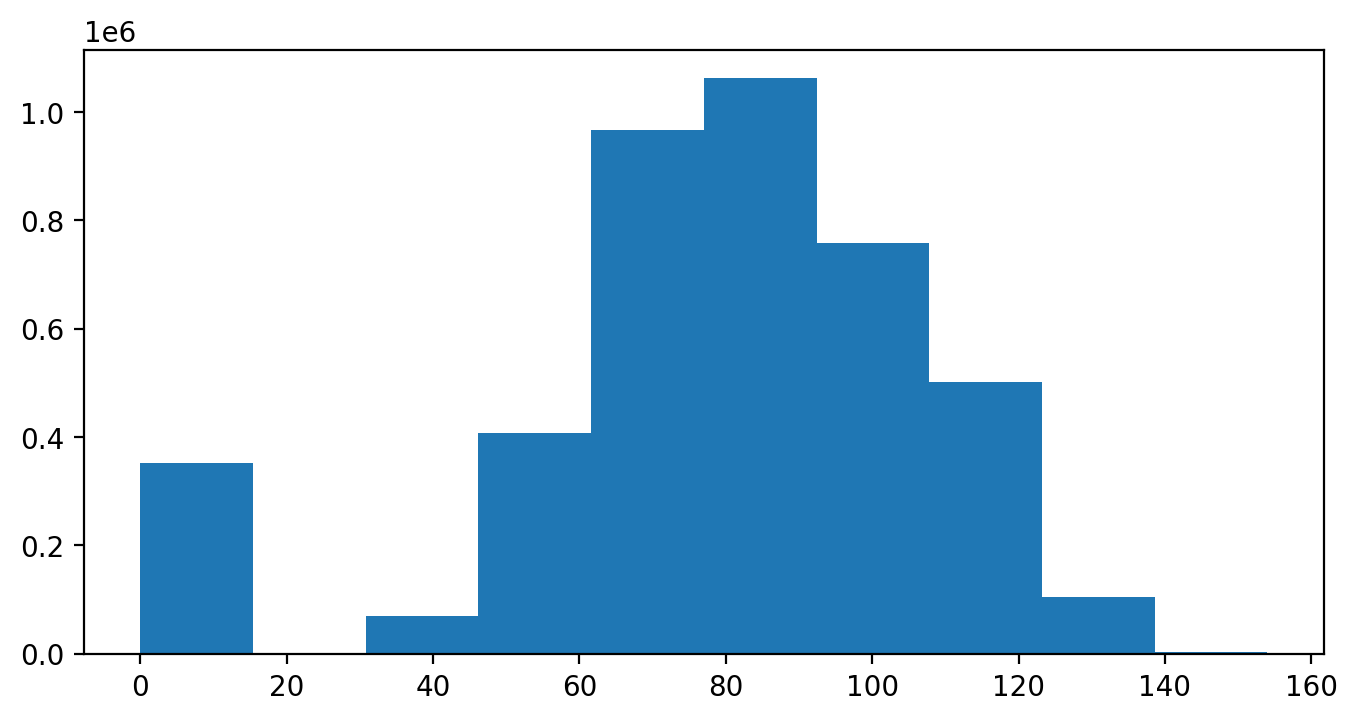

In [63]:
plt.hist(d.depths.flatten())

What's the proportion of missing data?

In [39]:
np.isnan(full_freq_mat).sum() / np.prod(full_freq_mat.shape)

0.08333333333333333

Calculate covariacne using calc_cov form cvtk.py:

#Required parameters are:
calc_cov(self, keep_seqids=None, bias_correction=True,
                 standardize=True, use_masked=False, product_only=False)
                 
#Which call the following function
temporal_replicate_cov(freqs, depths=None, diploids=None,
                           bias_correction=True, standardize=True, deltas=None,
                           use_masked=False, share_first=False,
                           product_only=False,
                           return_ratio_parts=False, warn=False):
             

In [68]:
gw_covs = d.calc_cov(use_masked=True) #ma.masked_invalid in numpy identifies NaN or Inf

In [69]:
stack_temporal_covariances(gw_covs, d.R, d.T).T[0]

array([[ 0.0003038 ,  0.00072014, -0.00103054],
       [ 0.00072014,  0.00011932, -0.0009005 ],
       [-0.00103054, -0.0009005 ,  0.00231136]])

In [70]:
# create labels for plots, for temporal covariances
stacked_temp_labs = stack_temporal_covariances(cov_labels(d.R, d.T, d.samples, lab_var=True), d.R, d.T)

In [75]:
#Save each matrix
pws_cov=pd.DataFrame(stack_temporal_covariances(gw_covs, d.R, d.T).T[0])
pws_labs=pd.DataFrame(stacked_temp_labs.T[0])
frames = [pws_cov, pws_labs]
pws = pd.concat(frames)

In [76]:
pws.to_csv("MD2000_3Pops_maf05_temp_cov_matrix_PWS_100k.csv")

In [77]:
#Save each matrix
SS_cov=pd.DataFrame(stack_temporal_covariances(gw_covs, d.R, d.T).T[1])
SS_labs=pd.DataFrame(stacked_temp_labs.T[1])
frames = [SS_cov, SS_labs]
SS = pd.concat(frames)

SS.to_csv("MD2000_3Pops_maf05_temp_cov_matrix_SS_100k.csv")

In [78]:
#Save each matrix
tb_cov=pd.DataFrame(stack_temporal_covariances(gw_covs, d.R, d.T).T[2])
tb_labs=pd.DataFrame(stacked_temp_labs.T[2])
frames = [tb_cov, tb_labs]
tb = pd.concat(frames)

tb.to_csv("MD2000_3Pops_maf05_temp_cov_matrix_TB_100k.csv")

## Add sensitivity analysis with turning off bias correction 

In [79]:
# 1. Turn off the diploid bias correction 
d1=TiledTemporalFreqs(tiles, freqs=full_freq_mat, depths=full_depths_mat, gintervals=gi, samples=new_samples)

In [80]:
d1.calc_cov(use_masked=True)  

array([[ 1.65920896e-02, -6.63222341e-03, -1.03934782e-03,
                    nan,             nan,             nan,
        -8.72179179e-04, -1.47183801e-04, -2.51794125e-04],
       [-6.63222341e-03,  1.92106108e-02, -1.28632330e-02,
                    nan,  2.11114254e-05, -9.37844364e-06,
        -4.93279673e-05, -3.59637511e-05, -1.66836596e-04],
       [-1.03934782e-03, -1.28632330e-02,  2.21556432e-02,
                    nan,  1.22089225e-03, -1.05504102e-03,
         7.15100631e-04,  4.66714775e-04,  3.29998754e-04],
       [            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan],
       [            nan,  2.11114254e-05,  1.22089225e-03,
                    nan,  2.16828856e-02, -1.50720206e-02,
                    nan,  3.10793638e-04, -8.09962303e-05],
       [            nan, -9.37844364e-06, -1.05504102e-03,
                    nan, -1.50720206e-02,  2.459994

In [81]:
# 2. Turn off the depth bias correction 
d2=TiledTemporalFreqs(tiles, freqs=full_freq_mat,diploids=new_ndiploids, gintervals=gi, samples=new_samples)

In [82]:
cov1=d1.calc_cov(use_masked=True)  

In [83]:
#Save the results matrix
pws_cov=pd.DataFrame(stack_temporal_covariances(cov1, d.R, d.T).T[0])
pws_labs=pd.DataFrame(stacked_temp_labs.T[0])
frames = [pws_cov, pws_labs]
pws1 = pd.concat(frames)
pws1.to_csv("MD2000_min417_no_diploid_biasCorrection_temp_cov_matrix_PWS.csv")

#Save each matrix
SS_cov=pd.DataFrame(stack_temporal_covariances(cov1, d.R, d.T).T[1])
SS_labs=pd.DataFrame(stacked_temp_labs.T[1])
frames = [SS_cov, SS_labs]
SS = pd.concat(frames)
SS.to_csv("MD2000_min417_no_diploid_biasCorrection_temp_cov_matrix_SS.csv")

#Save each matrix
tb_cov=pd.DataFrame(stack_temporal_covariances(cov1, d.R, d.T).T[2])
tb_labs=pd.DataFrame(stacked_temp_labs.T[2])
frames = [tb_cov, tb_labs]
tb = pd.concat(frames)
tb.to_csv("MD2000_min417_no_diploid_biasCorrection_temp_cov_matrix_TB.csv")

In [84]:
cov2=d2.calc_cov(use_masked=True)  

In [85]:
#Save the results matrix
pws_cov=pd.DataFrame(stack_temporal_covariances(cov2, d.R, d.T).T[0])
pws_labs=pd.DataFrame(stacked_temp_labs.T[0])
frames = [pws_cov, pws_labs]
pws = pd.concat(frames)
pws.to_csv("MD2000_min417_no_depth_biasCorrection_temp_cov_matrix_PWS.csv")

SS_cov=pd.DataFrame(stack_temporal_covariances(cov2, d.R, d.T).T[1])
SS_labs=pd.DataFrame(stacked_temp_labs.T[1])
frames = [SS_cov, SS_labs]
SS = pd.concat(frames)
SS.to_csv("MD2000_min417_no_depth_biasCorrection_temp_cov_matrix_SS.csv")

#Save each matrix
tb_cov=pd.DataFrame(stack_temporal_covariances(cov2, d.R, d.T).T[2])
tb_labs=pd.DataFrame(stacked_temp_labs.T[2])
frames = [tb_cov, tb_labs]
tb = pd.concat(frames)
tb.to_csv("MD2000_min417_no_depth_biasCorrection_temp_cov_matrix_TB.csv")

In [86]:
# 3. Turn off the both bias corrections 
d3=TiledTemporalFreqs(tiles, freqs=full_freq_mat,gintervals=gi, samples=new_samples)
cov3=d3.calc_cov(use_masked=True)  

In [87]:
#Save the results matrix
pws_cov=pd.DataFrame(stack_temporal_covariances(cov3, d.R, d.T).T[0])
pws_labs=pd.DataFrame(stacked_temp_labs.T[0])
frames = [pws_cov, pws_labs]
pws1 = pd.concat(frames)
pws1.to_csv("MD2000_min417_no_biasCorrections_temp_cov_matrix_PWS.csv")

#Save each matrix
SS_cov=pd.DataFrame(stack_temporal_covariances(cov3, d.R, d.T).T[1])
SS_labs=pd.DataFrame(stacked_temp_labs.T[1])
frames = [SS_cov, SS_labs]
SS = pd.concat(frames)
SS.to_csv("MD2000_min417_no_biasCorrections_temp_cov_matrix_SS.csv")

#Save each matrix
tb_cov=pd.DataFrame(stack_temporal_covariances(cov3, d.R, d.T).T[2])
tb_labs=pd.DataFrame(stacked_temp_labs.T[2])
frames = [tb_cov, tb_labs]
tb = pd.concat(frames)
tb.to_csv("MD2000_min417_no_biasCorrections_temp_cov_matrix_TB.csv")

### Bootstrapping Temporal Covs

In [88]:
#calculate covariance based on the window
B = 1000
window_covs = d.calc_cov_by_tile(use_masked=True)
straps = []

def var_estimator(freqs, depths, diploids):
    R, T, L = freqs.shape
    cov = temporal_replicate_cov(freqs, depths, diploids, use_masked=True)
    temp_covs = stack_temporal_covariances(cov, R, T-1).T
    vars = []
    for i in range(temp_covs.shape[0]):
        vars.append(np.diag(temp_covs[i, ...]))
    return np.stack(vars)

In [89]:
gw_covs_cis = d.bootstrap_cov(B=5000, progress_bar=True, average_replicates=False)

/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cov.py:348: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


bootstraps:   0%|          | 0/5000 [00:00<?, ?it/s]

/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [90]:
### Bootstrapping Temporal Covs

#calculate covariance based on the window
B = 1000
window_covs = d.calc_cov_by_tile(use_masked=True)
straps = []

def var_estimator(freqs, depths, diploids):
    R, T, L = freqs.shape
    cov = temporal_replicate_cov(freqs, depths, diploids, use_masked=True)
    temp_covs = stack_temporal_covariances(cov, R, T-1).T
    vars = []
    for i in range(temp_covs.shape[0]):
        vars.append(np.diag(temp_covs[i, ...]))
    return np.stack(vars)

gw_covs_cis = d.bootstrap_cov(B=5000, progress_bar=True, average_replicates=False)

bootstraps:   0%|          | 0/5000 [00:00<?, ?it/s]

In [100]:
pws_ci_lower=pd.DataFrame(gw_covs_cis[0,0:3,0:3])
pws_ci_upper=pd.DataFrame(gw_covs_cis[2,0:3,0:3])
pws_labs=pd.DataFrame(stacked_temp_labs.T[0])
frames = [pws_ci_lower, pws_ci_upper, pws_labs]
pws = pd.concat(frames)
pws.to_csv("MD2000_3Pops_maf05_PWS_Cov_CIs_bootstrap5000_100kwindow.csv")

ss_ci_lower=pd.DataFrame(gw_covs_cis[0,3:6,3:6])
ss_ci_upper=pd.DataFrame(gw_covs_cis[2,3:6,3:6])
ss_labs=pd.DataFrame(stacked_temp_labs.T[1])
frames = [ss_ci_lower, ss_ci_upper, ss_labs]
ss = pd.concat(frames)
ss.to_csv("MD2000_3Pops_maf05_SS_Cov_CIs_bootstrap5000_100kwindow.csv")

tb_ci_upper=pd.DataFrame(gw_covs_cis[0,6:10,6:10])
tb_ci_lower=pd.DataFrame(gw_covs_cis[2,6:10,6:10])
tb_labs=pd.DataFrame(stacked_temp_labs.T[2])
frames = [tb_ci_upper, tb_ci_lower, tb_labs]
tb = pd.concat(frames)
tb.to_csv("MD2000_3Pops_maf05_TB_Cov_CIs_bootstrap5000_100kwindow.csv")

##  Output the Covariance Matrices

In [141]:
#window size = 100k
WINSIZE = int(1e5)

#create the genomic interval object 
def binned_stat_windows(binned_stats, seqlens):
    gis = []
    for chrom, stats in binned_stats.items():
        for i in range(len(stats.bin_edges)-1):
            start, end = stats.bin_edges[i], stats.bin_edges[i+1]
            gis.append((chrom, start, end))
    return GenomicIntervals(gis, seqlens=seqlens)

def cov_windows(freqs, depths, diploids, gintervals, samples, tiles, seqlens=None):   
    d = TiledTemporalFreqs(tiles, freqs=freqs, depths=depths, diploids=diploids, gintervals=gintervals, samples=samples)
    covs = d.calc_cov_by_tile(use_masked=True)
    return covs, d

In [142]:
pws_tile_covs, d_ld = cov_windows(freqs=full_freq_mat, depths=full_depths_mat, diploids=new_ndiploids, gintervals=gi, samples=new_samples, tiles=tiles)

tile_covs_stacked = np.stack([stack_temporal_covariances(cov, d_ld.R, d_ld.T).T for cov in pws_tile_covs])

#pws_r2 = np.array(list(chain(*[c.statistic for c in pws_r2_bins.values()])))

tile_covs_stacked.shape

(7242, 3, 3, 3)

In [143]:
np.savetxt("PWS_cov12_MD2000_100kwindow.csv", tile_covs_stacked[:,0,0,1], delimiter=",")
np.savetxt("PWS_cov13_MD2000_100kwindow.csv", tile_covs_stacked[:,0,0,2], delimiter=",")
np.savetxt("PWS_cov23_MD2000_100kwindow.csv", tile_covs_stacked[:,0,1,2], delimiter=",")

np.savetxt("SS_cov12_MD2000_100kwindow.csv", tile_covs_stacked[:,1,0,1], delimiter=",")
np.savetxt("SS_cov13_MD2000_100kwindow.csv", tile_covs_stacked[:,1,0,2], delimiter=",")
np.savetxt("SS_cov23_MD2000_100kwindow.csv", tile_covs_stacked[:,1,1,2], delimiter=",")

np.savetxt("TB_cov12_MD2000_100kwindow.csv", tile_covs_stacked[:,2,0,1], delimiter=",")
np.savetxt("TB_cov13_MD2000_100kwindow.csv", tile_covs_stacked[:,2,0,2], delimiter=",")
np.savetxt("TB_cov23_MD2000_100kwindow.csv", tile_covs_stacked[:,2,1,2], delimiter=",")

## Calculate G

In [91]:
g_averep = d.calc_G() 

[0.00394997        nan 0.00281164]
[0.00524654        nan 0.00339146]
[0.00447983        nan 0.00285868]


/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cov.py:410: RuntimeWarning: Degrees of freedom <= 0 for slice.
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cov.py:435: RuntimeWarning: Mean of empty slice


In [92]:
g_averep
#PWS1,SS, TB1
#PWS2,  , TB2
#PWS3   , TB3

array([[ 0.        ,         nan,  0.        ],
       [ 0.77146258,         nan, -0.17288646],
       [-5.24345472,         nan, -1.44378494]])

In [146]:
g_cis = d.bootstrap_G(B=5000, progress_bar=True)

[0.00394996        nan 0.00281164]
[0.00524652        nan 0.00339146]
[0.00447981        nan 0.00285868]
[0.00317794        nan 0.00209194]
[0.00482142        nan 0.00246689]
[0.00515772        nan 0.00201767]
[0.0033973         nan 0.00281217]
[0.00309067        nan 0.00059983]
[0.00368937        nan 0.00304689]
[0.00356717        nan 0.00152924]
[0.00488485        nan 0.00325218]
[0.00403452        nan 0.00165785]
[0.00477601        nan 0.00245577]
[0.0054354         nan 0.00489554]
[0.00398207        nan 0.00459495]
[0.003739          nan 0.00331924]
[0.00373073        nan 0.00324552]
[0.00259429        nan 0.00409873]
[0.00384634        nan 0.00319541]
[0.00347701        nan 0.00194778]
[0.00268942        nan 0.00312318]
[0.00507461        nan 0.00464441]
[0.00371066        nan 0.00281472]
[0.00536006        nan 0.00464587]
[0.00313143        nan 0.00361157]
[0.00313601        nan 0.00129288]
[0.00245711        nan 0.0014906 ]
[0.00462298        nan 0.00282042]
[0.00333331        n

[0.00360359        nan 0.00132852]
[0.0042595         nan 0.00203296]
[0.00355254        nan 0.00163406]
[0.00382407        nan 0.00238499]
[0.00393764        nan 0.0021807 ]
[0.00246685        nan 0.00272909]
[0.00502682        nan 0.00238052]
[0.00207233        nan 0.00305272]
[0.00320076        nan 0.00304405]
[0.0033023         nan 0.00138283]
[0.0036859       nan 0.0005862]
[0.00569295        nan 0.0016513 ]
[0.00662643        nan 0.0002436 ]
[0.00481231        nan 0.00079712]
[0.00259813        nan 0.00197976]
[0.00243961        nan 0.00246197]
[0.00391204        nan 0.00212824]
[0.00369921        nan 0.00192316]
[0.00467564        nan 0.00068894]
[0.00343662        nan 0.00337684]
[0.00317358        nan 0.00117622]
[0.0034503         nan 0.00220853]
[0.0028916         nan 0.00288179]
[0.00313551        nan 0.00095879]
[0.00432774        nan 0.00067232]
[0.00368404        nan 0.00138389]
[0.00351391        nan 0.00274406]
[0.00290168        nan 0.00340938]
[0.00455513        nan 

[0.00448252        nan 0.00083821]
[0.00328053        nan 0.00160269]
[0.00435041        nan 0.00066648]
[0.00618247        nan 0.00129611]
[0.00226584        nan 0.00251159]
[0.00357313        nan 0.00386094]
[0.00266736        nan 0.00294076]
[0.00198135        nan 0.00235838]
[0.00373772        nan 0.00206289]
[0.00216121        nan 0.00082128]
[0.00320154        nan 0.00073627]
[0.00278684        nan 0.00462123]
[0.002714          nan 0.00211287]
[0.00586344        nan 0.00125736]
[0.00368361        nan 0.00156562]
[0.00107546        nan 0.00283828]
[0.00578276        nan 0.00480218]
[0.00312703        nan 0.00066602]
[0.0044602         nan 0.00255776]
[0.00357569        nan 0.0014682 ]
[0.0025168         nan 0.00314299]
[0.00428936        nan 0.00304041]
[0.00236323        nan 0.00291437]
[0.0058907         nan 0.00256479]
[0.00725199        nan 0.00053963]
[0.00261502        nan 0.00041262]
[0.00302922        nan 0.00162928]
[0.00203301        nan 0.00156102]
[0.0022718         n

[0.0086557         nan 0.00378697]
[0.00176559        nan 0.00324215]
[0.00179035        nan 0.00110131]
[0.00233365        nan 0.00073752]
[0.00676353        nan 0.00158157]
[3.16883693e-03            nan 4.86928670e-05]
[0.00572757        nan 0.00117089]
[0.00292592        nan 0.00219765]
[0.00356857        nan 0.00081773]
[0.00357751        nan 0.00230894]
[0.00301596        nan 0.0005211 ]
[0.00394487        nan 0.00065317]
[2.02838642e-03            nan 9.63093255e-05]
[0.00114339        nan 0.00086999]
[0.00302736        nan 0.00074347]
[2.43734062e-03            nan 9.87654321e-06]
[0.00171655        nan 0.00016797]
[0.00603991        nan 0.00119951]
[0.00170173        nan 0.0029251 ]
[0.00430718        nan 0.00231995]
[0.00383598        nan 0.00069659]
[0.00500886        nan 0.00077316]
[0.00247366        nan 0.00152609]
[0.00216456        nan 0.00108747]
[0.00650968        nan 0.00244698]
[0.00184583        nan 0.00289415]
[0.00344004        nan 0.00170231]
[0.00245531        

[0.00361065        nan 0.0026577 ]
[0.00469215        nan 0.00509488]
[0.00469735        nan 0.00236489]
[0.00357335        nan 0.00235229]
[0.00391283        nan 0.00272551]
[0.00225647        nan 0.00131049]
[0.00418909        nan 0.00155145]
[0.00505942        nan 0.00254887]
[0.00208801        nan 0.00431193]
[0.00318538        nan 0.00180201]
[0.00423956        nan 0.0023041 ]
[0.00250288        nan 0.0004953 ]
[nan nan nan]
[0.0031765         nan 0.00368155]
[0.00332417        nan 0.00240426]
[0.00189868        nan 0.00228266]
[0.00340172        nan 0.00237189]
[0.00239759        nan 0.00255272]
[0.00285563        nan 0.00435934]
[0.00325631        nan 0.00114264]
[0.00319605        nan 0.00408442]
[0.00205213        nan 0.00235865]
[0.00347892        nan 0.00197969]
[0.00381876        nan 0.00189598]
[0.00108802        nan 0.001492  ]
[0.00697374        nan 0.00143785]
[0.00450855        nan 0.00147816]
[0.0044903         nan 0.00281097]
[0.00260664        nan 0.00205705]
[0.003

[0.00361154        nan 0.00240844]
[0.00221662        nan 0.00085886]
[0.00389014        nan 0.00379346]
[0.00427087        nan 0.00285148]
[0.00391602        nan 0.00300153]
[0.00578703        nan 0.00161804]
[0.00551063        nan 0.0005749 ]
[0.00725147        nan 0.00165704]
[0.00493681        nan 0.00378074]
[0.00336285        nan 0.00376438]
[0.00368475        nan 0.00116274]
[0.00203061        nan 0.00306571]
[0.00517509        nan 0.00264916]
[0.0036193       nan 0.0022505]
[0.00251273        nan 0.00255791]
[0.0039335         nan 0.00199212]
[0.00398356        nan 0.00079388]
[0.00257391        nan 0.00094022]
[0.00649889        nan 0.00101435]
[0.00264116        nan 0.00272197]
[0.00333236        nan 0.00452953]
[0.00590897        nan 0.00285311]
[0.00333288        nan 0.00221531]
[0.00223259        nan 0.00189246]
[0.00657973        nan 0.00438726]
[0.00430663        nan 0.00293256]
[0.00334332        nan 0.00151542]
[0.00401385        nan 0.00086883]
[0.00271589        nan 

[0.00459208        nan 0.00224612]
[0.00426724        nan 0.0015569 ]
[0.00338021        nan 0.00373828]
[0.00393759        nan 0.00167449]
[0.00459313        nan 0.0009309 ]
[0.00506711        nan 0.00156665]
[0.00612596        nan 0.00369089]
[0.00457947        nan 0.00203315]
[0.0019665         nan 0.00393116]
[0.00326928        nan 0.0017098 ]
[0.00399005        nan 0.00168236]
[0.00331846        nan 0.0020975 ]
[0.00523995        nan 0.002258  ]
[0.00454445        nan 0.00259586]
[0.00495016        nan 0.0043466 ]
[0.0034153         nan 0.00425236]
[0.00408793        nan 0.00364945]
[0.00210144        nan 0.00288645]
[0.0038579         nan 0.00170744]
[0.00200007        nan 0.00171065]
[0.00193366        nan 0.00137493]
[0.00505885        nan 0.00508917]
[0.00421463        nan 0.00552064]
[0.00486998        nan 0.00185661]
[0.00273706        nan 0.00174453]
[0.00200123        nan 0.00407448]
[0.00549699        nan 0.0026805 ]
[0.00445724        nan 0.00413224]
[0.00455326        n

[ 0. nan  0.]
[0.00340033        nan 0.00397622]
[0.00730364        nan 0.00329077]
[0.00600512        nan 0.00164448]
[0.00435552        nan 0.00307919]
[0.00275053        nan 0.00191433]
[0.00947623        nan 0.00794813]
[0.00349553        nan 0.00389289]
[0.00412565        nan 0.00229843]
[0.00506562        nan 0.00335759]
[0.00572359        nan 0.00300811]
[0.00360054        nan 0.00257792]
[0.0040874         nan 0.00343708]
[0.00416246        nan 0.00520615]
[0.00333185        nan 0.00385994]
[0.00355361        nan 0.00351092]
[0.00336931        nan 0.00171747]
[0.00651846        nan 0.00402092]
[0.00145907        nan 0.00229269]
[0.0035806         nan 0.00097765]
[0.00204238        nan 0.00268488]
[0.00316619        nan 0.00261021]
[0.00285632        nan 0.00257116]
[0.00498542        nan 0.00484088]
[0.00522946        nan 0.00356721]
[0.00872734        nan 0.00305422]
[0.00513672        nan 0.00167806]
[0.00413916        nan 0.00535033]
[0.00345887        nan 0.0022342 ]
[0.003

[0.00181027        nan 0.00303032]
[0.00425578        nan 0.00169193]
[0.00429909        nan 0.00245956]
[0.00407577        nan 0.00299342]
[0.00443027        nan 0.00453117]
[0.00194556        nan 0.00297094]
[0.00450154        nan 0.00280444]
[0.00295567        nan 0.00289478]
[0.00316675        nan 0.00285374]
[0.00515615        nan 0.0038557 ]
[0.00278608        nan 0.00289771]
[0.00373506        nan 0.00349168]
[0.0088631         nan 0.00490759]
[0.00426805        nan 0.00940851]
[0.00682719        nan 0.00345385]
[0.00327872        nan 0.00441747]
[0.00365632        nan 0.00252837]
[0.00264264        nan 0.00509215]
[0.00191083        nan 0.00188759]
[0.00694408        nan 0.00183676]
[0.0135496         nan 0.00488798]
[0.00329845        nan 0.00331881]
[0.00507582        nan 0.00297921]
[0.00420428        nan 0.00475837]
[0.00345324        nan 0.00300626]
[0.00175372        nan 0.00215128]
[0.00229553        nan 0.00249504]
[0.00254406        nan 0.00064109]
[0.0044616         n

[0.00389961        nan 0.00187292]
[0.00555055        nan 0.00282266]
[0.00627435        nan 0.00172152]
[0.00663617        nan 0.00330642]
[0.00426619        nan 0.0032334 ]
[0.00885085        nan 0.00188242]
[0.00249402        nan 0.00371021]
[0.0041384         nan 0.00428128]
[0.00158865        nan 0.00743428]
[0.00342502        nan 0.00217681]
[0.00354985        nan 0.00139323]
[0.00258117        nan 0.00240203]
[0.00423819        nan 0.00242214]
[0.00443482        nan 0.00280712]
[0.00333296        nan 0.00066779]
[nan nan nan]
[0.00132704        nan 0.0013464 ]
[0.00416212        nan 0.00297175]
[0.00439145        nan 0.00130697]
[0.0031097         nan 0.00194702]
[0.00464711        nan 0.00237659]
[0.00342246        nan 0.00171348]
[0.00352351        nan 0.00154145]
[0.00040539        nan 0.00164894]
[0.00253048        nan 0.00157534]
[0.00537695        nan 0.0009282 ]
[0.00493542        nan 0.00218857]
[0.00452157        nan 0.00238684]
[0.00363719        nan 0.00369712]
[0.003

[0.00432326        nan 0.00377515]
[0.00514851        nan 0.00123994]
[0.00242846        nan 0.00440504]
[0.00840948        nan 0.00019777]
[0.00400194        nan 0.00446009]
[0.003836          nan 0.00327991]
[0.00389089        nan 0.00225015]
[0.00309449        nan 0.000286  ]
[0.00319618        nan 0.00166576]
[0.00597971        nan 0.00317383]
[0.00241154        nan 0.00271797]
[0.00219759        nan 0.00112058]
[0.00190044        nan 0.00372127]
[0.00285287        nan 0.00263093]
[0.00550784        nan 0.00197361]
[0.00334294        nan 0.00394044]
[0.00319232        nan 0.00256621]
[0.00247102        nan 0.00244374]
[0.00394478        nan 0.00315856]
[0.00393855        nan 0.0020702 ]
[0.00422907        nan 0.0026132 ]
[0.0026551         nan 0.00201518]
[0.00233935        nan 0.00356988]
[0.00274099        nan 0.00341416]
[0.00474051        nan 0.00352368]
[0.00451545        nan 0.00316313]
[0.00513101        nan 0.00324479]
[0.00336281        nan 0.00346949]
[0.00205014        n

[0.00261047        nan 0.00218444]
[0.00450942        nan 0.0014697 ]
[0.00496241        nan 0.00228846]
[0.00455788        nan 0.00280216]
[0.00340179        nan 0.00269921]
[0.00594759        nan 0.00252749]
[0.00595317        nan 0.00270197]
[0.00519346        nan 0.00264786]
[0.00331487        nan 0.00285729]
[0.00485679        nan 0.00297102]
[0.00372459        nan 0.00341571]
[0.00331123        nan 0.00282584]
[0.00301638        nan 0.00343645]
[0.00536298        nan 0.0032846 ]
[0.00501309        nan 0.00458066]
[0.00247072        nan 0.00469266]
[0.00606764        nan 0.0033598 ]
[0.0036605         nan 0.00158098]
[0.0030399         nan 0.00149575]
[0.00393181        nan 0.00372077]
[0.00281959        nan 0.00172694]
[0.00458235        nan 0.00285845]
[0.00369611        nan 0.00328287]
[0.00352613        nan 0.00274229]
[0.00390745        nan 0.0034786 ]
[0.00403973        nan 0.00422932]
[0.00374632        nan 0.0031749 ]
[0.00456699        nan 0.00358185]
[0.00347545        n

[0.00298058        nan 0.00216124]
[0.00036349        nan 0.00185606]
[nan nan nan]
[0.00299173        nan 0.00222044]
[0.00100089        nan 0.00066649]
[0.00461762        nan 0.00243889]
[0.00737417        nan 0.00402458]
[0.00198974        nan 0.00144814]
[0.00539611        nan 0.00177815]
[0.00299766        nan 0.00137209]
[0.00617465        nan 0.00379553]
[0.00374889        nan 0.00352882]
[0.00249919        nan 0.0030763 ]
[0.00413778        nan 0.00028762]
[0.00192391        nan 0.0043061 ]
[0.00104443        nan 0.00192656]
[0.00492866        nan 0.00295485]
[0.00420946        nan 0.00269389]
[0.00331054        nan 0.00249835]
[0.0037877         nan 0.00266149]
[0.00268397        nan 0.00287597]
[0.00320135        nan 0.00381053]
[0.00209706        nan 0.00247964]
[0.00360598        nan 0.00375219]
[0.00392101        nan 0.00319111]
[0.00290207        nan 0.00345497]
[0.00295157        nan 0.00324109]
[0.00426699        nan 0.00321109]
[0.00180159        nan 0.00196213]
[0.003

[0.00478426        nan 0.003069  ]
[0.00351066        nan 0.00075471]
[0.00686287        nan 0.00158848]
[0.00513703        nan 0.00193513]
[0.00466181        nan 0.00440998]
[0.00338929        nan 0.00424403]
[0.00418944        nan 0.00177332]
[0.00512357        nan 0.00429423]
[0.00845708        nan 0.00212005]
[0.00670783        nan 0.00494809]
[0.00577327        nan 0.00396596]
[0.00286679        nan 0.00255245]
[0.00296057        nan 0.00122187]
[0.00407469        nan 0.00163372]
[0.00455711        nan 0.00240987]
[0.00502853        nan 0.00463104]
[0.00554225        nan 0.00468991]
[0.00475812        nan 0.00149149]
[0.00552781        nan 0.00138441]
[0.00511215        nan 0.0032775 ]
[0.00892768        nan 0.00183625]
[0.00866828        nan 0.00274729]
[0.00406912        nan 0.002325  ]
[0.00502006        nan 0.00137103]
[0.00601971        nan 0.00194083]
[0.00434532        nan 0.00200051]
[0.00300909        nan 0.00381232]
[0.00483573        nan 0.00298877]
[0.00560655        n

[0.01009137        nan 0.00319462]
[0.01112475        nan 0.00135205]
[0.00320272        nan 0.00078351]
[0.00385573        nan 0.00107382]
[0.00971293        nan 0.00117734]
[0.00465507        nan 0.00192159]
[0.0039853         nan 0.00130005]
[0.003366          nan 0.00074127]
[0.00538806        nan 0.00219931]
[0.00389321        nan 0.00429116]
[0.00872728        nan 0.00242667]
[0.00410065        nan 0.00338565]
[0.0042322         nan 0.00252035]
[0.00481087        nan 0.00326219]
[0.0057719         nan 0.00250653]
[0.00434576        nan 0.00185099]
[0.00677174        nan 0.00333797]
[0.00423272        nan 0.00145085]
[0.00296013        nan 0.00269085]
[0.00710127        nan 0.00204552]
[0.00561834        nan 0.00192378]
[0.00305835        nan 0.0036945 ]
[0.00315261        nan 0.00450645]
[0.00362165        nan 0.00286214]
[0.0084805         nan 0.00225563]
[0.00576715        nan 0.00194729]
[0.00463689        nan 0.00271817]
[0.00679682        nan 0.00227395]
[0.00900303        n

[0.00552602        nan 0.00658308]
[0.00776901        nan 0.00421219]
[0.00496445        nan 0.00270311]
[0.00295586        nan 0.00336151]
[0.00562931        nan 0.00238467]
[0.00592755        nan 0.00201435]
[0.00416685        nan 0.00346862]
[0.00316753        nan 0.00236342]
[0.00533104        nan 0.00404358]
[0.00654145        nan 0.00488569]
[0.0047423         nan 0.00229717]
[0.00531272        nan 0.00475725]
[0.00759255        nan 0.00213192]
[0.00402411        nan 0.00200886]
[0.00476643        nan 0.00434537]
[0.00467373        nan 0.00591324]
[0.00397487        nan 0.00284095]
[0.00650667        nan 0.00268389]
[0.00736678        nan 0.00180843]
[0.0046355         nan 0.00188085]
[0.00513998        nan 0.00213546]
[0.00498063        nan 0.00364848]
[0.00463725        nan 0.00459775]
[0.00795637        nan 0.00399712]
[0.00425044        nan 0.00248382]
[0.00696394        nan 0.00399502]
[0.0061578         nan 0.00282724]
[0.00716986        nan 0.00375153]
[0.00444779        n

[0.00463386        nan 0.00608584]
[0.00344568        nan 0.00257913]
[0.00149477        nan 0.00246252]
[0.00314082        nan 0.00373224]
[0.00200123        nan 0.0056421 ]
[0.00146675        nan 0.00508185]
[0.00439458        nan 0.00397171]
[0.00196063        nan 0.0034791 ]
[0.00199239        nan 0.00294048]
[0.00463472        nan 0.00570152]
[0.00334679        nan 0.00378803]
[0.00154331        nan 0.00409895]
[0.00404991        nan 0.00361385]
[0.00378512        nan 0.00485326]
[0.00420683        nan 0.00275146]
[0.0044818         nan 0.00097853]
[0.00258043        nan 0.00500446]
[0.00412038        nan 0.00093409]
[0.00201283        nan 0.0067495 ]
[0.00452063        nan 0.00228498]
[0.00418767        nan 0.00274622]
[0.00556896        nan 0.00615008]
[0.0046723         nan 0.00259362]
[0.00419334        nan 0.00608754]
[0.01185555        nan 0.01252159]
[0.00569876        nan 0.00317594]
[0.00365185        nan 0.0037571 ]
[0.00776921        nan 0.00328404]
[0.0022427         n

[0.00535598        nan 0.00634966]
[0.00310265        nan 0.00544228]
[0.00316477        nan 0.00161143]
[0.00573052        nan 0.00192336]
[0.00512773        nan 0.00302215]
[0.00456121        nan 0.00272124]
[0.00602828        nan 0.00247026]
[0.00550307        nan 0.00336216]
[0.00506432        nan 0.00439579]
[0.00644841        nan 0.00393109]
[0.00868378        nan 0.00328601]
[0.00291645        nan 0.00420718]
[0.00381913        nan 0.00269971]
[0.00519208        nan 0.00348784]
[0.00429941        nan 0.00254798]
[0.00429663        nan 0.00436577]
[0.00527776        nan 0.00521251]
[0.00333168        nan 0.00335332]
[0.00423148        nan 0.00257959]
[0.00318932        nan 0.00741002]
[0.00598111        nan 0.00118172]
[nan nan nan]
[0.00231239        nan 0.00060394]
[0.00925039        nan 0.00111274]
[0.01086064        nan 0.00494287]
[0.00543159        nan 0.00340976]
[0.00280923        nan 0.00168858]
[0.00433965        nan 0.00777853]
[0.00313742        nan 0.00210624]
[0.004

[0.00646552        nan 0.00343002]
[0.00588233        nan 0.00441125]
[0.00220488        nan 0.00618452]
[0.00540296        nan 0.00357919]
[0.004894          nan 0.00401444]
[0.00494899        nan 0.0040935 ]
[0.00604291        nan 0.00389603]
[0.00461133        nan 0.00507771]
[0.00432663        nan 0.00203065]
[0.00279629        nan 0.0049849 ]
[0.00067378        nan 0.00199064]
[0.00613553        nan 0.00266486]
[0.00524116        nan 0.00398361]
[0.0045858         nan 0.00441005]
[0.0017902         nan 0.00320181]
[0.00534816        nan 0.00485098]
[0.00487021        nan 0.00432683]
[0.00535417        nan 0.00553556]
[0.00607481        nan 0.00454658]
[0.00453339        nan 0.00351884]
[0.00461462        nan 0.00354704]
[0.00508702        nan 0.00477863]
[0.01060634        nan 0.00218763]
[0.003321          nan 0.00446334]
[0.00510202        nan 0.00483641]
[0.00707401        nan 0.00384512]
[0.00447259        nan 0.00272955]
[0.0053997         nan 0.00379295]
[0.00564479        n

[0.00633328        nan 0.00380102]
[0.00516413        nan 0.0070015 ]
[0.00468764        nan 0.00289604]
[0.00592853        nan 0.00240211]
[0.00821404        nan 0.00328369]
[0.00535773        nan 0.00476859]
[0.00245299        nan 0.00137276]
[0.00236605        nan 0.00235895]
[0.00730067        nan 0.00353854]
[0.0039022         nan 0.00322518]
[0.00278841        nan 0.00452823]
[0.00372948        nan 0.0032772 ]
[0.00270131        nan 0.00155844]
[0.00437296        nan 0.00244472]
[0.00430712        nan 0.00259752]
[0.00187904        nan 0.00114044]
[0.0020752         nan 0.00149838]
[0.00311812        nan 0.00189767]
[0.007987          nan 0.00091151]
[0.00953004        nan 0.00192293]
[0.00370995        nan 0.0017666 ]
[0.00548748        nan 0.00260301]
[0.00680491        nan 0.01441845]
[0.00589012        nan 0.00219827]
[0.00455874        nan 0.00402555]
[0.0124892         nan 0.00278394]
[0.00330194        nan 0.00090562]
[0.00421767        nan 0.005443  ]
[0.00387317        n

[0.00453584        nan 0.00146498]
[0.00296674        nan 0.00456252]
[0.00499274        nan 0.0037967 ]
[0.00667058        nan 0.00235753]
[0.00357194        nan 0.0019071 ]
[0.00597185        nan 0.00501189]
[0.00801917        nan 0.00173568]
[0.00402249        nan 0.00147268]
[0.00371751        nan 0.00224287]
[0.0057346         nan 0.00206309]
[0.00893454        nan 0.00082157]
[0.00195163        nan 0.00294984]
[0.00664478        nan 0.00051367]
[0.00498943        nan 0.0026357 ]
[0.00412836        nan 0.00548929]
[0.0033145         nan 0.00098126]
[0.00628648        nan 0.00309336]
[0.00713373        nan 0.00052909]
[0.00385515        nan 0.00297912]
[0.00605467        nan 0.00229298]
[0.00356717        nan 0.0016038 ]
[0.00377333        nan 0.00230547]
[0.00479252        nan 0.00223666]
[0.00594332        nan 0.00370502]
[0.005974          nan 0.00271784]
[0.00654858        nan 0.0054759 ]
[0.00360804        nan 0.00154677]
[0.00658972        nan 0.00481431]
[0.00517284        n

[0.00478821        nan 0.00367666]
[0.00531335        nan 0.00601269]
[0.0035109       nan 0.0054447]
[0.00082973        nan 0.00155489]
[0.00435056        nan 0.00432215]
[0.00383979        nan 0.00263899]
[0.00491682        nan 0.00257424]
[0.00628829        nan 0.00283155]
[0.00601062        nan 0.00418039]
[0.00393073        nan 0.00347975]
[0.00529013        nan 0.00422314]
[0.00491118        nan 0.00217094]
[0.00459999        nan 0.00211646]
[0.00794213        nan 0.00433928]
[0.00436171        nan 0.00360399]
[0.00602536        nan 0.00337567]
[0.00668803        nan 0.0039213 ]
[0.00449166        nan 0.00296637]
[0.00601262        nan 0.00352367]
[0.00438859        nan 0.0031864 ]
[0.00398496        nan 0.00011508]
[0.00441978        nan 0.00178988]
[0.00520831        nan 0.00607057]
[0.00231522        nan 0.00286519]
[0.00274387        nan 0.00133653]
[0.00386402        nan 0.00179233]
[0.00282065        nan 0.0042798 ]
[0.0028974         nan 0.00615143]
[0.00544206        nan 

[0.00283739        nan 0.00517825]
[0.00621161        nan 0.00625151]
[0.00343499        nan 0.00039503]
[0.01392781        nan 0.00223599]
[0.0013424       nan 0.0031702]
[0.00257157        nan 0.00247196]
[0.00432796        nan 0.00279967]
[0.00903375        nan 0.00498343]
[0.00235741        nan 0.00295569]
[0.00157248        nan 0.00253096]
[0.00823008        nan 0.000347  ]
[0.0051656       nan 0.0041972]
[0.0077983         nan 0.00058257]
[nan nan nan]
[0.00600342        nan 0.00614492]
[0.00376757        nan 0.00226556]
[0.00601513        nan 0.00074125]
[0.00715034        nan 0.00390855]
[0.00306791        nan 0.00256545]
[0.00659478        nan 0.00469625]
[0.00528027        nan 0.00575613]
[0.00495787        nan 0.0063831 ]
[0.00458518        nan 0.00321592]
[0.00510297        nan 0.00438951]
[0.00567252        nan 0.00544994]
[0.00565516        nan 0.0033784 ]
[0.00229806        nan 0.00340613]
[0.00711756        nan 0.00201429]
[0.00375638        nan 0.00409522]
[0.00528629 

[0.00381421        nan 0.00443599]
[0.00619961        nan 0.0035156 ]
[0.00323186        nan 0.00319253]
[0.00677928        nan 0.00454113]
[0.00506343        nan 0.00378155]
[0.00391652        nan 0.00193785]
[0.00763109        nan 0.00301662]
[0.00552142        nan 0.00254894]
[0.00698376        nan 0.0034388 ]
[0.00400946        nan 0.00225389]
[0.00466893        nan 0.00445947]
[0.00253334        nan 0.0035618 ]
[0.00654825        nan 0.00303464]
[0.00589817        nan 0.00150966]
[0.00353394        nan 0.00495227]
[0.00734464        nan 0.00184615]
[0.00616164        nan 0.0019108 ]
[0.00653167        nan 0.00196772]
[0.00414681        nan 0.00238252]
[0.00290706        nan 0.00399   ]
[0.00389239        nan 0.00349274]
[0.00690499        nan 0.00485416]
[0.00770016        nan 0.00348144]
[0.01068507        nan 0.00303216]
[0.00501896        nan 0.00312884]
[0.00659798        nan 0.00191885]
[0.0045364         nan 0.00318807]
[0.00394712        nan 0.00166918]
[0.00214645        n

[0.00441705        nan 0.0037    ]
[0.00052908        nan 0.00068134]
[0.0056469         nan 0.01146191]
[0.00551045        nan 0.0058085 ]
[0.00367012        nan 0.00358584]
[0.00133873        nan 0.00201052]
[0.00549451        nan 0.00307252]
[0.0036535         nan 0.00470293]
[0.00578909        nan 0.00121963]
[0.00217616        nan 0.00346812]
[0.00394748        nan 0.00332827]
[0.00385304        nan 0.01299584]
[0.00525296        nan 0.00358113]
[0.00035339        nan 0.00035277]
[0.00155322        nan 0.00506676]
[0.00542311        nan 0.00324252]
[0.00413349        nan 0.0022136 ]
[0.00314305        nan 0.00110129]
[0.0056614         nan 0.00386828]
[0.00396872        nan 0.00284865]
[0.00544019        nan 0.00446391]
[0.00470819        nan 0.00319188]
[0.00456847        nan 0.003602  ]
[0.00475111        nan 0.0031896 ]
[0.00447273        nan 0.00377062]
[0.00507724        nan 0.0046882 ]
[0.00502071        nan 0.00423285]
[0.00738136        nan 0.00367541]
[0.00462426        n

[0.00562278        nan 0.00270706]
[0.00303171        nan 0.00271219]
[0.00469872        nan 0.0055824 ]
[ 0. nan  0.]
[0.00426862        nan 0.00364783]
[0.00340888        nan 0.00228722]
[0.00551155        nan 0.00334684]
[0.00246711        nan 0.00322845]
[0.00316069        nan 0.00370716]
[0.00508429        nan 0.00324947]
[0.0016746         nan 0.00585891]
[0.00267947        nan 0.00139047]
[0.00267647        nan 0.00229222]
[0.00385427        nan 0.00104028]
[0.00550972        nan 0.00066967]
[0.0048494         nan 0.00164546]
[0.00320055        nan 0.0041146 ]
[0.00222804        nan 0.00149534]
[0.00324412        nan 0.00202649]
[0.00399267        nan 0.00210908]
[0.01095397        nan 0.00630143]
[0.00327867        nan 0.00150988]
[0.00273232        nan 0.00293749]
[0.00404445        nan 0.00152857]
[0.00478043        nan 0.00402155]
[0.00565993        nan 0.00299565]
[0.00505351        nan 0.00158621]
[0.00614819        nan 0.00206971]
[0.00546457        nan 0.00303248]
[0.005

[0.00728563        nan 0.00021945]
[0.00634438        nan 0.00033345]
[0.00196077        nan 0.00108161]
[0.00236054        nan 0.00245812]
[0.00775345        nan 0.00559316]
[0.00130169        nan 0.00055801]
[0.00512172        nan 0.00334504]
[0.00462412        nan 0.00132537]
[0.00385265        nan 0.00308955]
[0.00133051        nan 0.00810389]
[0.00573579        nan 0.00145193]
[0.00043534        nan 0.00204362]
[0.004003          nan 0.00214413]
[0.0028547         nan 0.00123989]
[0.00461119        nan 0.00160888]
[0.00422242        nan 0.00096761]
[0.00415631        nan 0.00136332]
[0.01113792        nan 0.0021377 ]
[0.00340511        nan 0.00506296]
[0.00107133        nan 0.00474437]
[0.00410845        nan 0.00163563]
[1.79115896e-03            nan 6.03192207e-05]
[0.00684957        nan 0.00222591]
[0.00325964        nan 0.00086345]
[0.00473438        nan 0.00147603]
[0.00523112        nan 0.00178888]
[0.00337726        nan 0.00201896]
[0.00484736        nan 0.00221095]
[0.00491

[0.0018843       nan 0.000287 ]
[0.00358084        nan 0.000632  ]
[0.00399963        nan 0.00234052]
[0.007234          nan 0.00327184]
[0.00567717        nan 0.00188021]
[0.00665837        nan 0.00048676]
[0.00199139        nan 0.00074811]
[0.00290484        nan 0.00130869]
[0.00655516        nan 0.00159259]
[0.00330071        nan 0.00189185]
[0.00343488        nan 0.00102002]
[0.00195076        nan 0.00259782]
[0.00283945        nan 0.00416183]
[0.0044947         nan 0.00012382]
[0.00388873        nan 0.00221172]
[0.00208548        nan 0.0004348 ]
[9.159134e-05          nan 0.000000e+00]
[0.00225128        nan 0.        ]
[0.00565931        nan 0.00028006]
[0.00128056        nan 0.00121496]
[0.00371372        nan 0.00086756]
[0.00207484        nan 0.00427566]
[0.00379293        nan 0.00086708]
[0.00275848        nan 0.00486184]
[0.0059438         nan 0.00206825]
[0.00208543        nan 0.00308224]
[0.00258155        nan 0.00304351]
[0.00039692        nan 0.00036877]
[0.00293561      

[0.00807343        nan 0.00214337]
[0.00516644        nan 0.00153331]
[0.00401933        nan 0.0023096 ]
[0.00478117        nan 0.00166735]
[0.0057588         nan 0.00200544]
[0.0046943         nan 0.00369124]
[0.00511916        nan 0.00010896]
[0.00262284        nan 0.00246684]
[0.00286753        nan 0.00090428]
[0.0065209         nan 0.00064807]
[0.00456984        nan 0.00338542]
[0.00265442        nan 0.00231868]
[0.00332222        nan 0.0018307 ]
[0.00431929        nan 0.00170683]
[0.0050062         nan 0.00336514]
[0.00211054        nan 0.00218013]
[0.00410544        nan 0.00195661]
[0.00379978        nan 0.00072647]
[0.01068296        nan 0.00051505]
[0.0052242         nan 0.00263117]
[0.00467526        nan 0.00277482]
[0.00234392        nan 0.00270002]
[0.00327593        nan 0.00450756]
[0.00332813        nan 0.00270614]
[0.00360644        nan 0.00357031]
[0.00226593        nan 0.00446916]
[0.00549161        nan 0.0020411 ]
[0.00369594        nan 0.00060618]
[0.00364253        n

[0.00329886        nan 0.00157236]
[0.00146488        nan 0.00228833]
[0.00391211        nan 0.00233521]
[0.00499482        nan 0.00217603]
[0.00686432        nan 0.        ]
[3.19263812e-03            nan 7.54464900e-05]
[0.00200436        nan 0.00152193]
[0.00295286        nan 0.00202121]
[0.00304125        nan 0.00195084]
[0.00195774        nan 0.011788  ]
[0.00396608        nan 0.00176017]
[0.00413594        nan 0.00240471]
[0.00483683        nan 0.00529818]
[0.00779139        nan 0.00210309]
[0.01211319        nan 0.00380072]
[0.00265468        nan 0.00046853]
[4.58465257e-03            nan 3.27784757e-05]
[0.00256938        nan 0.00299037]
[0.0024606         nan 0.00203039]
[0.00749125        nan 0.00315671]
[0.00738747        nan 0.00278897]
[0.00155275        nan 0.00110937]
[0.00577511        nan 0.00062546]
[0.00652895        nan 0.00512413]
[0.00689648        nan 0.00364707]
[0.00307591        nan 0.00559828]
[0.00243036        nan 0.00640462]
[0.00466434        nan 0.006467

[0.00357728        nan 0.00189063]
[0.00187279        nan 0.00381233]
[0.0027771         nan 0.00211935]
[0.00484747        nan 0.00197823]
[0.00266129        nan 0.00179798]
[0.00362821        nan 0.00212044]
[0.003316          nan 0.00235982]
[0.0031646         nan 0.00217197]
[0.00175287        nan 0.00241622]
[0.00375482        nan 0.00307129]
[0.0025931         nan 0.00348204]
[0.00234275        nan 0.00234779]
[0.00146763        nan 0.00473711]
[0.00569774        nan 0.0032704 ]
[0.00214839        nan 0.001697  ]
[0.00182282        nan 0.00261131]
[0.00376959        nan 0.00574034]
[0.00262422        nan 0.00328656]
[0.00368455        nan 0.00111921]
[0.00348475        nan 0.005786  ]
[0.00318162        nan 0.00310182]
[0.00213443        nan 0.00308613]
[0.00400285        nan 0.00247994]
[0.00599789        nan 0.00152471]
[0.00209693        nan 0.00297503]
[0.00327728        nan 0.00439175]
[0.00155883        nan 0.0029302 ]
[0.00126875        nan 0.00118955]
[0.00338834        n

[0.00394103        nan 0.00192301]
[0.0031484         nan 0.00238632]
[0.00319025        nan 0.00202501]
[0.00373183        nan 0.00174398]
[0.00967558        nan 0.00581126]
[0.0050243         nan 0.00264827]
[0.00427308        nan 0.00289961]
[0.00412656        nan 0.00220248]
[0.00281008        nan 0.00106757]
[0.00378591        nan 0.00250138]
[0.00289472        nan 0.00324138]
[0.00463193        nan 0.00078805]
[0.00457504        nan 0.00267883]
[0.00487244        nan 0.00222426]
[0.00466422        nan 0.00273472]
[0.00304615        nan 0.00276236]
[0.00439782        nan 0.00248453]
[0.00395095        nan 0.00159738]
[0.00473808        nan 0.0018921 ]
[0.00622059        nan 0.00380893]
[0.00683846        nan 0.00188376]
[0.00604205        nan 0.00076236]
[0.00348757        nan 0.00116383]
[0.00606825        nan 0.00214713]
[0.00538634        nan 0.00180983]
[0.00351385        nan 0.0039815 ]
[0.00278163        nan 0.00259635]
[0.00277051        nan 0.0015527 ]
[0.00187563        n

[0.00662349        nan 0.00459403]
[0.00645428        nan 0.00104607]
[0.00432407        nan 0.00445755]
[0.00312281        nan 0.00408469]
[0.00464917        nan 0.00235972]
[0.00426574        nan 0.00215889]
[0.00383781        nan 0.00461369]
[0.00283237        nan 0.00126411]
[0.00527431        nan 0.00251821]
[0.00396116        nan 0.00372394]
[0.00430673        nan 0.00296523]
[0.00378874        nan 0.00309876]
[0.0035498         nan 0.00180884]
[0.00700222        nan 0.00319649]
[0.00177768        nan 0.00075417]
[0.00507009        nan 0.00378794]
[0.00344671        nan 0.00367584]
[0.0034964         nan 0.00092104]
[0.00460129        nan 0.00314898]
[0.00522278        nan 0.00456983]
[0.00622593        nan 0.00303402]
[0.00515259        nan 0.00217558]
[0.00297555        nan 0.00168981]
[0.00605702        nan 0.00228472]
[0.00643769        nan 0.0017572 ]
[0.00459227        nan 0.00265693]
[0.01818654        nan 0.00045051]
[0.00488785        nan 0.00273422]
[0.0073724         n

[2.91285068e-03            nan 6.05067394e-05]
[0.00523188        nan 0.00786486]
[0.00425138        nan 0.00468358]
[0.00418653        nan 0.00162274]
[0.00351223        nan 0.00411892]
[0.00710072        nan 0.00219564]
[0.01178157        nan 0.00306437]
[0.00778766        nan 0.00233253]
[0.00588916        nan 0.011374  ]
[0.00288161        nan 0.00372673]
[0.00061767        nan 0.00055493]
[0.0027374         nan 0.00144117]
[0.00719577        nan 0.00555036]
[0.0036164         nan 0.00238332]
[0.00428752        nan 0.00143156]
[0.00231784        nan 0.00208072]
[0.00356067        nan 0.00175872]
[0.00798429        nan 0.00225137]
[0.00562836        nan 0.00413557]
[0.00431406        nan 0.00079874]
[0.0025816         nan 0.00415522]
[0.00594825        nan 0.00202227]
[0.00463254        nan 0.00616251]
[0.00520553        nan 0.0022986 ]
[0.00205968        nan 0.00068515]
[0.00128116        nan 0.00822952]
[0.00687664        nan 0.00375687]
[0.00349026        nan 0.00085604]
[0.00583

[0.00446991        nan 0.002377  ]
[0.00550738        nan 0.00361518]
[0.00335004        nan 0.00455422]
[0.00372355        nan 0.0030501 ]
[0.00448977        nan 0.00170533]
[0.00392776        nan 0.00156005]
[0.00382102        nan 0.00626186]
[0.00573866        nan 0.00193509]
[0.0026753         nan 0.00258657]
[0.00355458        nan 0.00191837]
[0.00328625        nan 0.00223383]
[0.00262491        nan 0.00322346]
[0.00438896        nan 0.00297322]
[0.00459221        nan 0.00187977]
[0.00451597        nan 0.00276055]
[0.0035207         nan 0.00238264]
[0.00506168        nan 0.00158825]
[0.00380642        nan 0.00189919]
[0.00359089        nan 0.00123804]
[0.00326099        nan 0.00137397]
[0.0056621         nan 0.00260198]
[0.00358255        nan 0.000823  ]
[0.00458097        nan 0.00192458]
[0.00352764        nan 0.001172  ]
[0.00277044        nan 0.00351324]
[0.00399979        nan 0.002475  ]
[0.00566656        nan 0.00437661]
[0.00404349        nan 0.00091493]
[0.00461248        n

[0.00142214        nan 0.00313024]
[ 0. nan  0.]
[9.58783358e-05            nan 3.29265296e-02]
[0.00169947        nan 0.00179914]
[0.00391915        nan 0.00360123]
[0.00730304        nan 0.00583983]
[0.00428034        nan 0.00266677]
[0.00486673        nan 0.00181308]
[0.00621388        nan 0.00359846]
[0.00352872        nan 0.00400648]
[0.00170401        nan 0.00277011]
[0.00514435        nan 0.00182151]
[0.0051661         nan 0.00552873]
[0.00424843        nan 0.00320512]
[0.00047007        nan 0.00122216]
[0.00360101        nan 0.00135145]
[0.00281806        nan 0.00182638]
[0.00501857        nan 0.00212049]
[0.00646765        nan 0.00529924]
[0.00437574        nan 0.00323519]
[0.00359322        nan 0.003367  ]
[0.00437005        nan 0.00400851]
[0.00391199        nan 0.00211498]
[0.00278149        nan 0.00218722]
[0.00200243        nan 0.00584087]
[0.00698781        nan 0.00097371]
[0.00387656        nan 0.00195468]
[0.00631775        nan 0.00237182]
[0.00678671        nan 0.0017

TypeError: cvtk.cvtk.TemporalFreqs.calc_cov_by_group() got multiple values for keyword argument 'group_seqids'

## Caluclate conv_corr

In [148]:
conv_corr = d.convergence_corr()

In [149]:
conv_corr

array([[[        nan,         nan,         nan],
        [        nan,  0.05124597,  0.10363762],
        [        nan,  0.06477588, -0.08443426]]])

## Correction and Diagnostics

/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cvtk.py:260: RuntimeWarning: Mean of empty slice
  n = np.nanmean(n)
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cvtk.py:274: RuntimeWarning: Mean of empty slice
  het = np.nanmean(het)
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/diagnostics.py:18: RuntimeWarning: Mean of empty slice
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/diagnostics.py:19: RuntimeWarning: Mean of empty slice
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cov.py:316: RuntimeWarning: Mean of empty slice
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/diagnostics.py:18: RuntimeWarning: Mean of empty slice
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/diagnostics.py:19: Run

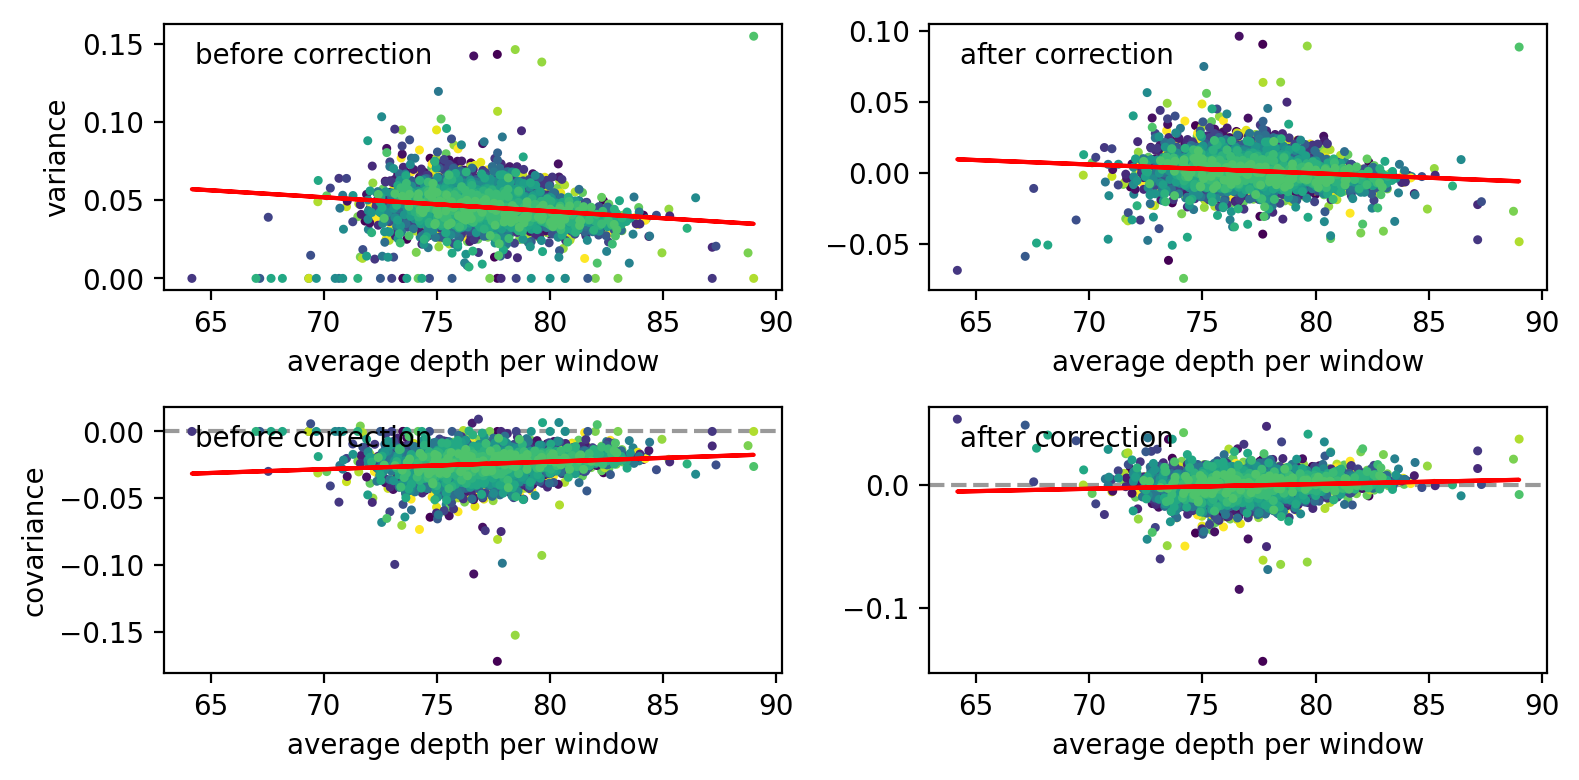

In [150]:
diagnostics = d.correction_diagnostics(use_masked=True)
_ = correction_diagnostic_plot(diagnostics)

## Variances

In [38]:
# we need to keep track of number of years between
#m = re.compile(r'var\((?P<sample>[^:]+): (?P<start>\d+)-(?P<end>\d+)\)')
#converts = {'sample': str, 'start': int, 'end': int}
#var_labels = [[tuple(converts[k](m.match(s).groupdict()[k]) for k in 'sample start end'.split(' ')) 
#  for s in np.diag(stacked_temp_labs.T[i])] for i in range(stacked_temp_labs.T.shape[0])]


# manual fix: PWS 2006 is really 2007
var_labels = [[('PWS', 1996, 1991), ('PWS', 2007, 1996), ('PWS', 2017, 2007)],
              [('SS', 1996, 1991), ('SS', 2006, 1996), ('SS', 2017, 2006)],
              [('TB', 1996, 1991), ('TB', 2006, 1996), ('TB', 2017, 2006)]]


In [66]:
#Red lines = the mean from 1000 bootstrap results
#Blue lines = estiamted variance 

In [39]:
# here is the more precise procedure
B = 1000
window_covs = d.calc_cov_by_tile(use_masked=True)
straps = []

def var_estimator(freqs, depths, diploids):
    R, T, L = freqs.shape
    cov = temporal_replicate_cov(freqs, depths, diploids, use_masked=True)
    temp_covs = stack_temporal_covariances(cov, R, T-1).T
    vars = []
    for i in range(temp_covs.shape[0]):
        vars.append(np.diag(temp_covs[i, ...]))
    return np.stack(vars)
        

In [40]:
var_straps = block_bootstrap(d.freqs, d.depths, d.diploids, d.tile_indices, d.tiles.seqid, B, var_estimator, return_straps=True, progress_bar=True)

bootstraps:   0%|          | 0/1000 [00:00<?, ?it/s]

In [41]:
var_straps.shape

(1000, 3, 3)

### Estimate Ne from Var

#export the followings to create figures in R
var_labels
var_straps


In [74]:
#pd.DataFrame(var_labels[0]).to_csv("MD2000_min417_PWS_varlabels.csv",index_label=False)
#pd.DataFrame(var_straps[:,0,:]).to_csv("MD2000_min417_PWS_vars_bootstrap.csv",index_label=False)


In [75]:
#pd.DataFrame(var_labels[1]).to_csv("MD2000_min417_SS_varlabels.csv",index_label=False)
#pd.DataFrame(var_straps[:,1,:]).to_csv("MD2000_min417_SS_vars_bootstrap.csv",index_label=False)
#
#pd.DataFrame(var_labels[2]).to_csv("MD2000_min417_TB_varlabels.csv",index_label=False)
#pd.DataFrame(var_straps[:,2,:]).to_csv("MD2000_min417_TB_vars_bootstrap.csv",index_label=False)


In [78]:
pd.DataFrame(var_straps[:,0,:])

,0,1,2
0,-0.002332,-0.003246,-0.001346
1,-0.002449,-0.003346,-0.001407
2,-0.002400,-0.003226,-0.001477
3,-0.002359,-0.003141,-0.001485
4,-0.002350,-0.003078,-0.001368
...,...,...,...
995,-0.002418,-0.003114,-0.001238
996,-0.002142,-0.003113,-0.001092
997,-0.002444,-0.003271,-0.001538
998,-0.002355,-0.003173,-0.001481


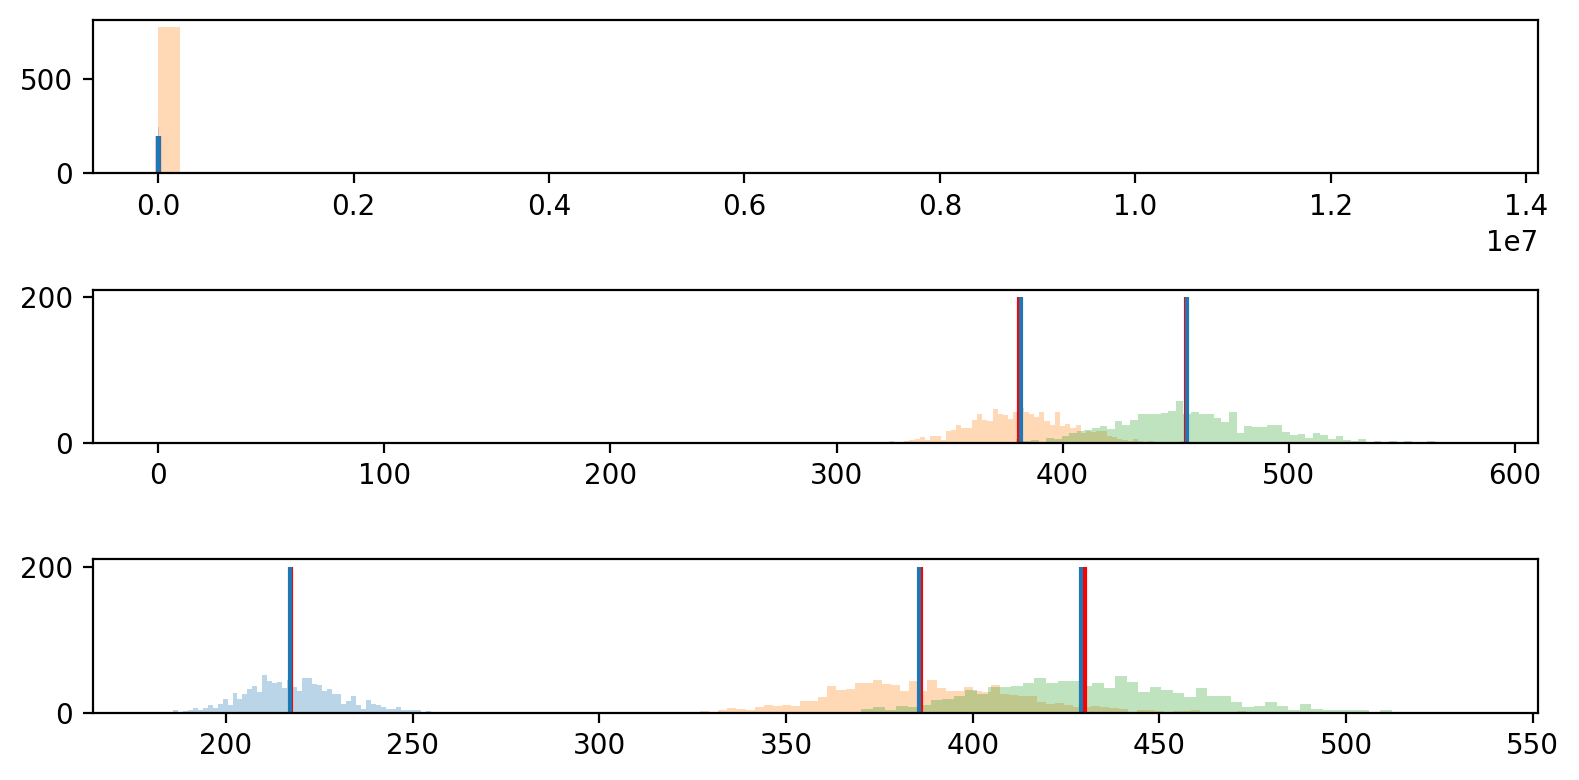

In [44]:
gen_time = 1/4

Ne_CIs = dict()

fig, ax = plt.subplots(ncols=1, nrows=3, sharex=False)
for i in range(3):
    years = []
    cis = []
    for j in range(3):
        sample, end, start = var_labels[i][j]
        nyears = end - start
        x = var_straps[:, i, j]
        x = x[np.isfinite(x)]
        x = x[x > 0]

        #ax[i].text(0.9, 0.8, sample, transform=ax[i].transAxes)
        ax[i].hist(nyears * gen_time * 0.5/x, 60, alpha=0.3)
        #if i == 0:
        #    ax[i].set_xlim(0, 2000)
        #ax[i].set_xlim(0, 10000)
        ax[i].vlines(nyears * gen_time * 0.5/np.mean(x), 0, 200, color='r')
        ax[i].vlines(nyears * gen_time * 0.5/np.diag(stack_temporal_covariances(gw_covs, d.R, d.T).T[i, ...])[j], 0, 200)
        
        Ne = nyears * gen_time * 0.5/np.diag(stack_temporal_covariances(gw_covs, d.R, d.T).T[i, ...])[j]
        Ne_straps = nyears * gen_time * 0.5/var_straps[:, i, j]
        years.append((end, start))
        cis.append(bootstrap_ci(Ne, Ne_straps, method='standard'))
    Ne_CIs[sample] = (years, cis)

plt.tight_layout()

In [45]:
Ne_CIs

{'PWS': ([(1996, 1991), (2007, 1996), (2017, 2007)],
  [array([-11740.92840652,   2059.17754811,  15859.28350274]),
   array([-925744.87385613,   11517.93576223,  948780.74538059]),
   array([454.18569731, 540.76592435, 627.3461514 ])]),
 'SS': ([(1996, 1991), (2006, 1996), (2017, 2006)],
  [array([nan, nan, nan]),
   array([338.95706698, 381.74761927, 424.53817155]),
   array([391.05362555, 455.18572546, 519.31782538])]),
 'TB': ([(1996, 1991), (2006, 1996), (2017, 2006)],
  [array([192.523721  , 217.23053156, 241.93734212]),
   array([337.09494627, 385.52349457, 433.95204288]),
   array([373.42323827, 429.00095865, 484.57867904])])}

In [43]:
Ne_CIs

{'PWS': ([(1996, 1991), (2007, 1996), (2017, 2007)],
  [array([-7827.28560435,  1372.78503207, 10572.85566849]),
   array([-617163.24923742,    7678.62384149,  632520.49692039]),
   array([302.79046487, 360.51061624, 418.2307676 ])]),
 'SS': ([(1996, 1991), (2006, 1996), (2017, 2006)],
  [array([nan, nan, nan]),
   array([225.97137799, 254.49841284, 283.0254477 ]),
   array([260.70241703, 303.45715031, 346.21188359])]),
 'TB': ([(1996, 1991), (2006, 1996), (2017, 2006)],
  [array([128.34914733, 144.82035437, 161.29156141]),
   array([224.72996418, 257.01566305, 289.30136192]),
   array([248.94882551, 286.0006391 , 323.05245269])])}

(array([544., 243.,  84.,  36.,  20.,  15.,   7.,   6.,   2.,   0.,   4.,
          3.,   1.,   1.,   2.,   0.,   0.,   2.,   1.,   1.,   1.,   0.,
          0.,   2.,   1.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   2.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   1.]),
 array([  799.60796595,  2209.58793609,  3619.56790623,  5029.54787638,
         6439.52784652,  7849.50781666,  9259.4877868 , 10669.46775695,
        12079.44772709, 13489.42769723, 14899.40766738, 16309.38763752,
        17719.36760766, 19129.3475778 , 20539.32754795, 21949.30751809,
        23359.28748823, 24769.26745838, 26179.24742852, 27589.22739866,
        28999.2073688 , 30409.18733895, 31819.16730909, 33229.14727923,
        34639.12724938, 36049.10721952, 37459.08718966, 38869.0671598 ,
        40279.04712995, 41689.02710009, 43099.00707023, 44508.98704038,
        45918.

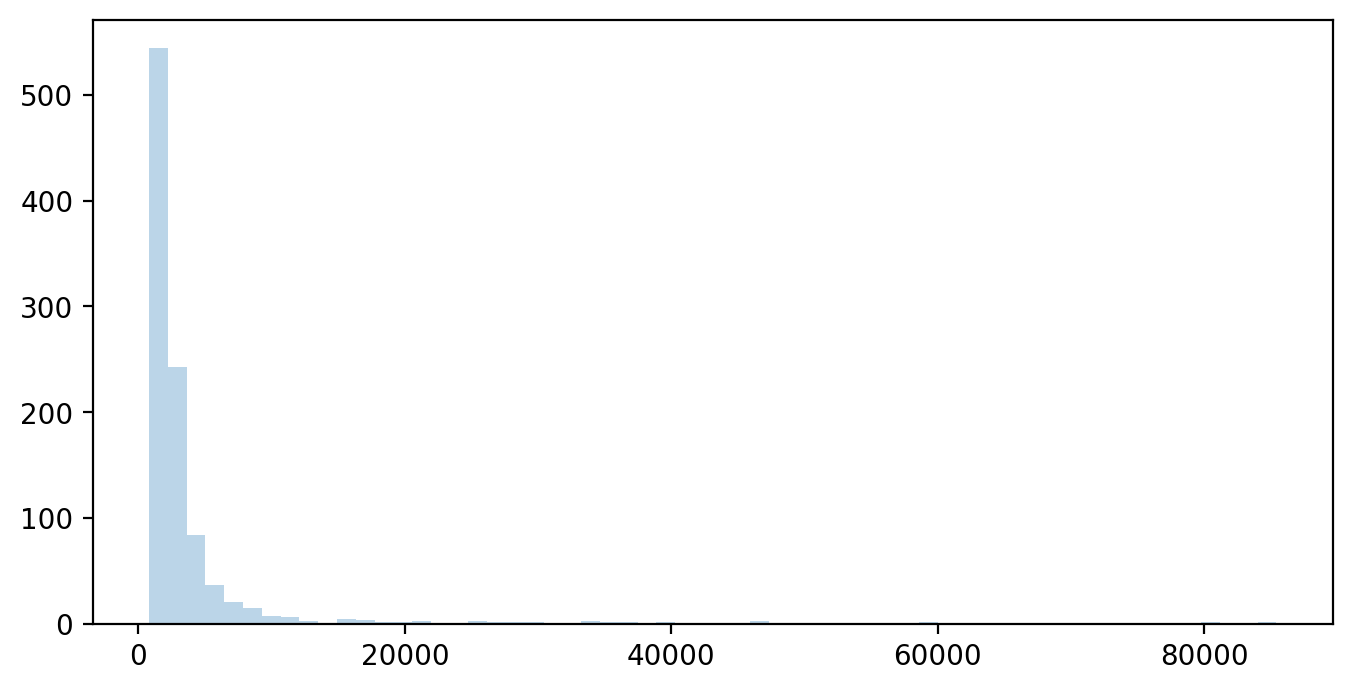

In [46]:
sample, end, start = var_labels[0][0]
nyears = end - start
x = var_straps[:, 0, 0]
x = x[np.isfinite(x)]
x = x[x > 0]

plt.hist(nyears * gen_time * 0.5/x, 60, alpha=0.3)       

In [47]:
Ne_CIs_df = []
for sample, dats in Ne_CIs.items():
    time, cis = dats
    for i in range(3):
        Ne_CIs_df.append(dict(sample=sample, start=time[i][1], end=time[i][0], lower=cis[i][0], Ne=cis[i][1], upper=cis[i][2]))


In [48]:
Ne_CIs_df

[{'sample': 'PWS',
  'start': 1991,
  'end': 1996,
  'lower': -11740.928406524434,
  'Ne': 2059.1775481069853,
  'upper': 15859.283502738404},
 {'sample': 'PWS',
  'start': 1996,
  'end': 2007,
  'lower': -925744.8738561284,
  'Ne': 11517.9357622303,
  'upper': 948780.745380589},
 {'sample': 'PWS',
  'start': 2007,
  'end': 2017,
  'lower': 454.18569731011485,
  'Ne': 540.7659243546472,
  'upper': 627.3461513991795},
 {'sample': 'SS',
  'start': 1991,
  'end': 1996,
  'lower': nan,
  'Ne': nan,
  'upper': nan},
 {'sample': 'SS',
  'start': 1996,
  'end': 2006,
  'lower': 338.95706698024776,
  'Ne': 381.7476192655987,
  'upper': 424.53817155094964},
 {'sample': 'SS',
  'start': 2006,
  'end': 2017,
  'lower': 391.053625547103,
  'Ne': 455.1857254649419,
  'upper': 519.3178253827808},
 {'sample': 'TB',
  'start': 1991,
  'end': 1996,
  'lower': 192.5237209956137,
  'Ne': 217.230531557407,
  'upper': 241.9373421192003},
 {'sample': 'TB',
  'start': 1996,
  'end': 2006,
  'lower': 337.0949

In [49]:
pd.DataFrame(Ne_CIs_df).to_csv('Md2000_min417_Ne_estimates_CIs.csv', sep=',', index=False)
pd.DataFrame(Ne_CIs_df)

,sample,start,end,lower,Ne,upper
0,PWS,1991,1996,-11740.928407,2059.177548,15859.283503
1,PWS,1996,2007,-925744.873856,11517.935762,948780.745381
2,PWS,2007,2017,454.185697,540.765924,627.346151
3,SS,1991,1996,NaN,NaN,NaN
4,SS,1996,2006,338.957067,381.747619,424.538172
5,SS,2006,2017,391.053626,455.185725,519.317825
6,TB,1991,1996,192.523721,217.230532,241.937342
7,TB,1996,2006,337.094946,385.523495,433.952043
8,TB,2006,2017,373.423238,429.000959,484.578679


[[-1.17409284e+04  2.05917755e+03  1.58592835e+04]
 [-9.25744874e+05  1.15179358e+04  9.48780745e+05]
 [ 4.54185697e+02  5.40765924e+02  6.27346151e+02]]
[[         nan          nan          nan]
 [338.95706698 381.74761927 424.53817155]
 [391.05362555 455.18572546 519.31782538]]
[[192.523721   217.23053156 241.93734212]
 [337.09494627 385.52349457 433.95204288]
 [373.42323827 429.00095865 484.57867904]]


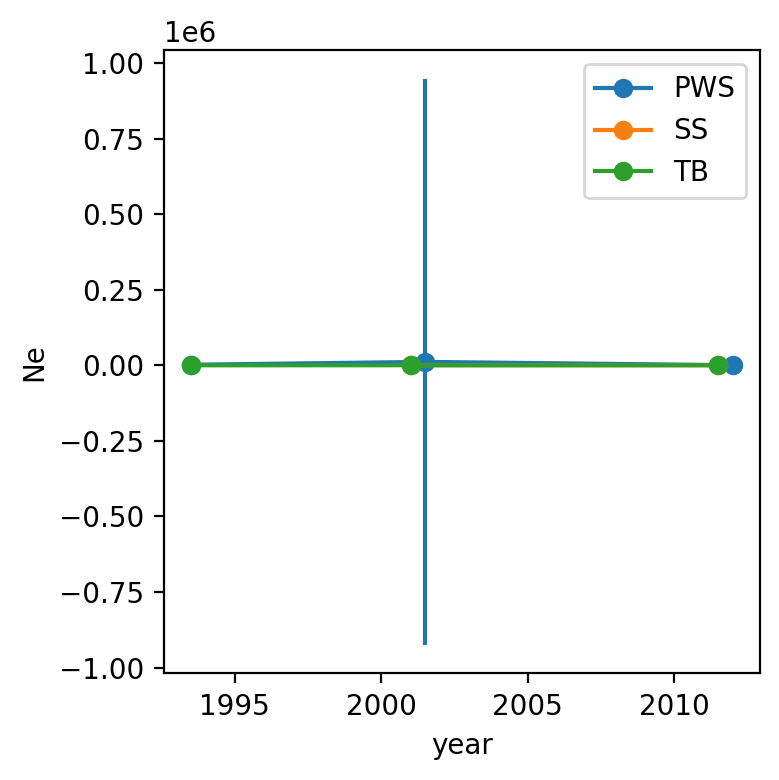

In [50]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 4), sharey=True)

labs = set()
for sample, (years, cis) in Ne_CIs.items():
    year_labels = [(end+start)/2 for end, start in years]
    cis = np.stack(cis)
    print(cis)
    lab = sample if sample not in labs else None
    labs.add(lab)
    ax.plot(year_labels, cis[:, 1], '-o', label=lab)
    ax.vlines(year_labels, cis[:, 0], cis[:, 2])
ax.set_ylabel("Ne")
ax.set_xlabel("year")
plt.legend()
plt.tight_layout()

# Manual Bootstrapping of CI (Standard Method)

In [11]:
md = pd.read_csv('../notebooks/PH_Samples_TempCov2.csv')
md

# divide into each population
md1=md[0:4]
md2=md[5:8]
md3=md[8:12]

In [12]:
## Load in VCF file:

#PWS 
vcf1 = VCFFile('/Users/kahotisthammer/Projects/PacHerring/Data/new_vcf/MD3000/3pops_MD2000_min417_PWS_maf05.vcf.gz')

reading file '/Users/kahotisthammer/Projects/PacHerring/Data/new_vcf/MD3000/3pops_MD2000_min417_PWS_maf05.vcf.gz'...
file '/Users/kahotisthammer/Projects/PacHerring/Data/new_vcf/MD3000/3pops_MD2000_min417_PWS_maf05.vcf.gz' loaded.
total time to load VCF file: 0.3455861488978068 mins.


In [13]:
#SS
vcf2 = VCFFile('/Users/kahotisthammer/Projects/PacHerring/Data/new_vcf/MD3000/3pops_MD2000_min417_SS_maf05.vcf.gz')

#TB
vcf3 = VCFFile('/Users/kahotisthammer/Projects/PacHerring/Data/new_vcf/MD3000/3pops_MD2000_min417_TB_maf05.vcf.gz')

vcf1.geno_mat.shape

reading file '/Users/kahotisthammer/Projects/PacHerring/Data/new_vcf/MD3000/3pops_MD2000_min417_SS_maf05.vcf.gz'...
file '/Users/kahotisthammer/Projects/PacHerring/Data/new_vcf/MD3000/3pops_MD2000_min417_SS_maf05.vcf.gz' loaded.
total time to load VCF file: 0.2731660842895508 mins.
reading file '/Users/kahotisthammer/Projects/PacHerring/Data/new_vcf/MD3000/3pops_MD2000_min417_TB_maf05.vcf.gz'...
file '/Users/kahotisthammer/Projects/PacHerring/Data/new_vcf/MD3000/3pops_MD2000_min417_TB_maf05.vcf.gz' loaded.
total time to load VCF file: 0.3902012666066488 mins.


(351820, 232, 2)

In [14]:
## Group them into each time period 

def parse_sample(x):
    "Parse out the sample metadata from the VCF."
    ind, pop, year = re.match(r'(?P<ind>[^_]+)_(?P<pop>[A-Z]+)(?P<year>[0-9]+)', x).groups()
    sample = pop + year
    return (ind, pop, year, sample)

In [15]:
vcf_pws = pd.DataFrame([parse_sample(str(x)) for x in vcf1.samples],
                     columns = ['ind', 'pop', 'year', 'sample'])

In [16]:
vcf_ss = pd.DataFrame([parse_sample(str(x)) for x in vcf2.samples],
                     columns = ['ind', 'pop', 'year', 'sample'])
vcf_tb = pd.DataFrame([parse_sample(str(x)) for x in vcf3.samples],
                     columns = ['ind', 'pop', 'year', 'sample'])

In [17]:
subpops1 = defaultdict(list)
for i, sample in enumerate(vcf_pws['sample']):
    subpops1[sample].append(i)

In [18]:
subpops2 = defaultdict(list)
for i, sample in enumerate(vcf_ss['sample']):
    subpops2[sample].append(i)

subpops3 = defaultdict(list)
for i, sample in enumerate(vcf_tb['sample']):
    subpops3[sample].append(i)

In [19]:
counts_mat1 = vcf1.count_alleles_subpops(subpops1)
counts_mat2 = vcf2.count_alleles_subpops(subpops2)
counts_mat3 = vcf3.count_alleles_subpops(subpops3)

freq_mat_all1 = vcf1.calc_freqs()
freq_mat_all2 = vcf2.calc_freqs()
freq_mat_all3 = vcf3.calc_freqs()

depths_mat_all1 = vcf1.N.astype('f')
depths_mat_all2 = vcf2.N.astype('f')
depths_mat_all3 = vcf3.N.astype('f')

ndiploids1 = {k:len(subpops1[k]) for k in vcf1.subpops}
ndiploids2 = {k:len(subpops2[k]) for k in vcf2.subpops}
ndiploids3 = {k:len(subpops3[k]) for k in vcf3.subpops}

ndiploids1

subpops_lkup1 = {sp:i for i, sp in enumerate(vcf1.subpops)}
subpops_lkup2 = {sp:i for i, sp in enumerate(vcf2.subpops)}
subpops_lkup3 = {sp:i for i, sp in enumerate(vcf3.subpops)}

# No of loci is same for all
nloci= freq_mat_all1.shape[1]
nloci


/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


351820

In [20]:
#order by years based on 'md' file

#1. PWS
pws_freqs = []
pws_depths = []
pws_samples = []
pws_ndiploids = []

for row in md1.itertuples():
    sample = row.sample
    freqs = freq_mat_all1[subpops_lkup1[sample], :]
    depths = depths_mat_all1[subpops_lkup1[sample], :]        
    ndips = ndiploids1[sample]
    pws_freqs.append(freqs)
    pws_depths.append(depths)
    pws_samples.append((row.pop, row.year))
    pws_ndiploids.append(ndips)
    
pws_full_depths_mat = np.row_stack(pws_depths)
pws_freq_mat = np.row_stack(pws_freqs)

#2. SS
ss_freqs = []
ss_depths = []
ss_samples = []
ss_ndiploids = []

for row in md2.itertuples():
    sample = row.sample
    if not row.real:
        print(sample + " is a NA sample")
        freqs = np.empty((nloci))
        freqs[:] = np.nan
        depths = np.empty((nloci))
        depths[:] = np.nan
        ndips = 0   
    else:
        freqs = freq_mat_all2[subpops_lkup2[sample], :]
        depths = depths_mat_all2[subpops_lkup2[sample], :]        
        ndips = ndiploids2[sample]
    ss_freqs.append(freqs)
    ss_depths.append(depths)
    ss_samples.append((row.pop, row.year))
    ss_ndiploids.append(ndips)
    
ss_full_depths_mat = np.row_stack(ss_depths)
ss_freq_mat = np.row_stack(ss_freqs)

#3. TB
tb_freqs = []
tb_depths = []
tb_samples = []
tb_ndiploids = []

for row in md3.itertuples():
    sample = row.sample
    if not row.real:
        print(sample + " is a NA sample")
        freqs = np.empty((nloci))
        freqs[:] = np.nan
        depths = np.empty((nloci))
        depths[:] = np.nan
        ndips = 0   
    else:
        freqs = freq_mat_all3[subpops_lkup3[sample], :]
        depths = depths_mat_all3[subpops_lkup3[sample], :]        
        ndips = ndiploids3[sample]
    tb_freqs.append(freqs)
    tb_depths.append(depths)
    tb_samples.append((row.pop, row.year))
    tb_ndiploids.append(ndips)
    
tb_full_depths_mat = np.row_stack(tb_depths)
tb_freq_mat = np.row_stack(tb_freqs)

In [21]:
## Building the Temporal Freqs Object
sl_d = pd.read_csv('../data/chr_sizes.bed', delimiter='\t', names=['chrom', 'start', 'end'], header=None)

seqlens = dict(zip(sl_d['chrom'].values, sl_d['end'].values))
seqlens

#100,000 interval 
tile_width = int(1e5)
tiles = GenomicIntervals.from_tiles(seqlens, width=tile_width)

tiles

gi = vcf1.build_gintervals()

In [22]:
## Build the frequncy objects with 100,000 tile size

pws_d = TiledTemporalFreqs(tiles, freqs=pws_freq_mat, depths=pws_full_depths_mat, diploids=pws_ndiploids, gintervals=gi, samples=pws_samples)
ss_d = TiledTemporalFreqs(tiles, freqs=ss_freq_mat, depths=ss_full_depths_mat, diploids=ss_ndiploids, gintervals=gi, samples=ss_samples)
tb_d = TiledTemporalFreqs(tiles, freqs=tb_freq_mat, depths=tb_full_depths_mat, diploids=tb_ndiploids, gintervals=gi, samples=tb_samples)

In [23]:
## Calculate the genome-wide covariance for each population

gw_covs1 = pws_d.calc_cov() 
gw_covs2 = ss_d.calc_cov() 
gw_covs3 = tb_d.calc_cov() 

In [166]:
# SS has only 1 covariance here
stack_temporal_covariances(gw_covs2, ss_d.R, ss_d.T).T[0]

array([[ 0.00327432, -0.00323822],
       [-0.00323822,  0.00302045]])

In [26]:
# create labels for plots, for temporal covariances
stacked_temp_labs_pws = stack_temporal_covariances(cov_labels(pws_d.R, pws_d.T, pws_d.samples, lab_var=True), pws_d.R, pws_d.T)
stacked_temp_labs_pws.T

array([[['var(PWS: 1996-1991)', 'cov(PWS: 1996-1991, PWS: 2006-1996)',
         'cov(PWS: 1996-1991, PWS: 2017-2006)'],
        ['cov(PWS: 2006-1996, PWS: 1996-1991)', 'var(PWS: 2006-1996)',
         'cov(PWS: 2006-1996, PWS: 2017-2006)'],
        ['cov(PWS: 2017-2006, PWS: 1996-1991)',
         'cov(PWS: 2017-2006, PWS: 2006-1996)', 'var(PWS: 2017-2006)']]],
      dtype='<U35')

In [27]:
pws_g=pws_d.calc_G()

[0.00394998]
[0.00524653]
[0.00447985]


In [28]:
pws_g

array([[ 0.        ],
       [ 0.77146386],
       [-5.24097034]])

In [56]:
# Use abs=True
pws_g2=pws_d.calc_G(abs=True)
pws_g2

[0.00394998]
[0.00524653]
[0.00447985]


array([[ 0.        ],
       [ 0.77146386],
       [11.33999774]])

In [84]:
pws_g_cis = pws_d.bootstrap_G(B=1000, progress_bar=True)
# Does not work 
# TypeError: cvtk.cvtk.TemporalFreqs.calc_cov_by_group() got multiple values for keyword argument 'group_seqids'

[0.00394998]
[0.00524653]
[0.00447985]
[0.00353792]
[0.00477158]
[0.00515843]
[0.0034298]
[0.00322226]
[0.00366686]
[0.0038443]
[0.00494639]
[0.00345284]
[0.00480277]
[0.00562708]
[0.00388235]
[0.00369153]
[0.00343239]
[0.00237771]
[0.00389479]
[0.00352495]
[0.00305888]
[0.00501735]
[0.00380225]
[0.00533522]
[0.00315995]
[0.00355244]
[0.00201091]
[0.00464332]
[0.00334798]
[0.00397369]
[0.00462508]
[0.00366309]
[0.00327652]
[0.00552448]
[0.00313176]
[0.00332649]
[0.00445887]
[0.00698154]
[0.00432514]
[0.00386485]
[0.0028522]
[0.00499452]
[0.00345032]
[0.]
[0.00415141]
[0.00560003]
[0.00432978]
[0.00486726]
[0.00388851]
[0.00220353]
[0.00332512]
[0.0047431]
[0.00474402]
[0.00214452]
[0.0029759]
[0.00348802]
[0.00261522]
[0.00531087]
[0.00313881]
[0.00582825]
[0.00282724]
[0.00529165]
[0.00399609]
[0.00313551]
[0.0029189]
[0.00233752]
[0.00166176]
[0.00236851]
[0.0026568]
[0.00355718]
[0.00344748]
[0.00235108]
[0.00394831]
[0.00294205]
[0.00494621]
[0.00573901]
[0.00323853]
[0.00201472]
[

[0.00363813]
[0.00226308]
[0.00468873]
[0.00491977]
[0.00358353]
[0.00609769]
[0.00416141]
[0.00313404]
[0.00461109]
[0.00263857]
[0.00157259]
[0.00157361]
[0.00253354]
[0.00151887]
[0.00142467]
[0.00254157]
[0.00178462]
[0.00039812]
[0.00164082]
[0.00252896]
[0.00166943]
[0.00209158]
[0.00205824]
[0.00096719]
[0.0038464]
[0.00174978]
[0.00190897]
[0.00245785]
[0.00557314]
[0.00250044]
[0.00293288]
[0.00338783]
[0.00798139]
[0.00705847]
[0.00147494]
[0.00860371]
[0.00189462]
[0.00050104]
[0.00160879]
[0.00327018]
[0.00145719]
[0.00262366]
[0.00689945]
[0.00463536]
[0.00311961]
[0.00479335]
[0.00169688]
[0.00115045]
[0.00395421]
[0.00330941]
[0.]
[0.00575192]
[0.00248159]
[0.00380652]
[0.00332836]
[0.0027281]
[0.00214049]
[0.00086053]
[0.00067386]
[0.00357886]
[0.00281996]
[0.00297153]
[0.00478541]
[0.00694463]
[0.00546684]
[0.00170409]
[0.00393249]
[0.00473998]
[0.00136656]
[0.00224635]
[0.0031465]
[0.00276807]
[0.00140288]
[0.00306673]
[0.00618093]
[0.00470461]
[0.00211428]
[0.0028747

[0.00549126]
[0.00342458]
[0.00515496]
[0.00312764]
[0.00439155]
[0.00323951]
[0.00516564]
[0.0016491]
[0.00366295]
[0.00525934]
[0.00489847]
[0.00254427]
[0.00332428]
[0.00382495]
[0.0040233]
[0.00564847]
[0.00422715]
[0.0037702]
[0.00232176]
[0.00490971]
[0.00343528]
[0.00373624]
[0.0037265]
[0.00333274]
[0.00448258]
[0.00234491]
[0.00353724]
[0.00414343]
[0.00413693]
[0.00606936]
[0.00249658]
[0.00421785]
[0.0054561]
[0.00336727]
[0.00387508]
[0.0045881]
[0.00443286]
[0.00458651]
[0.00413708]
[0.0048973]
[0.00635814]
[0.00479824]
[0.00449688]
[0.00205545]
[0.00393067]
[0.00400187]
[0.00495817]
[0.0033722]
[0.00434549]
[0.00470795]
[0.00486481]
[0.00305531]
[0.00331212]
[0.00609412]
[0.00216099]
[0.00491446]
[0.00563403]
[0.00603754]
[0.00602504]
[0.00325383]
[0.00348111]
[0.00469406]
[0.00650107]
[0.00570626]
[0.0020296]
[0.00783333]
[0.00151172]
[0.001549]
[0.00305557]
[0.00242886]
[0.00045881]
[0.00257977]
[0.00222709]
[0.00301963]
[0.00193678]
[0.00035664]
[0.00578607]
[nan]
[0.0

[0.00544117]
[0.00226888]
[0.00068217]
[0.000629]
[0.00316887]
[0.00312073]
[0.00376982]
[0.00254439]
[0.0018219]
[0.00344119]
[0.00355061]
[0.00340391]
[0.00313707]
[0.0035807]
[0.00393318]
[0.00123334]
[0.00330374]
[0.0011737]
[nan]
[nan]
[0.]
[nan]
[0.00125678]
[0.0077372]
[0.002261]
[0.00464597]
[0.0021734]
[0.00324917]
[0.00252664]
[0.00248103]
[0.00282511]
[0.00138594]
[0.00693422]
[0.00286492]
[0.00616979]
[0.00609548]
[0.00455571]
[0.00400705]
[0.00335941]
[0.00417374]
[0.0031185]
[0.00357225]
[0.00372916]
[0.00341539]
[0.00267176]
[0.00285507]
[0.00543105]
[0.00323968]
[0.00414043]
[0.00425764]
[0.00288877]
[0.00399428]
[0.00420318]
[0.00424635]
[0.00265322]
[0.0064357]
[0.00371072]
[0.00392971]
[0.00334237]
[0.00483913]
[0.00415957]
[0.0036236]
[0.0047267]
[0.00214531]
[0.00313902]
[0.00489716]
[0.00581857]
[0.00257222]
[0.00331977]
[0.00380204]
[0.00423254]
[0.00390285]
[0.00384439]
[0.00389436]
[0.00435147]
[0.00361467]
[0.00292386]
[0.00269164]
[0.00282838]
[0.00242274]
[0

[0.00330589]
[0.00303566]
[0.00290346]
[0.00478024]
[0.00207264]
[0.0042281]
[0.00401891]
[0.00421434]
[0.00559608]
[0.00191997]
[0.00184405]
[0.00528427]
[0.00071535]
[0.00326643]
[0.00213236]
[0.00501473]
[0.00457253]
[0.00236843]
[0.00234107]
[0.00357067]
[0.00428538]
[0.00564671]
[0.00396635]
[0.00127755]
[0.00098182]
[0.00223648]
[0.0033762]
[0.00213409]
[0.00528296]
[0.00728563]
[0.00552242]
[0.00431397]
[0.00251641]
[0.00349005]
[0.00357293]
[0.01001224]
[0.00447353]
[0.00376987]
[0.0032567]
[0.00333178]
[0.01215088]
[0.00709117]
[0.00502461]
[0.00357338]
[0.00331955]
[0.00365842]
[0.00261192]
[0.00468754]
[0.00378824]
[0.00313177]
[0.00633681]
[0.00362128]
[0.00337037]
[0.00374719]
[0.00310013]
[0.00378673]
[0.00287016]
[0.00406677]
[0.00499423]
[0.00378619]
[0.00324243]
[0.00290199]
[0.00358443]
[0.00331764]
[0.00436254]
[0.00236973]
[0.00412037]
[0.00336441]
[0.00243336]
[0.00525189]
[0.00340858]
[0.00491791]
[0.00247089]
[0.00391512]
[0.00595714]
[0.00347409]
[0.00321183]
[0

[0.00279835]
[0.00223011]
[nan]
[0.]
[0.00242091]
[0.00055092]
[nan]
[nan]
[0.00143503]
[0.00879204]
[0.00114231]
[0.00215184]
[0.00402004]
[0.00384698]
[0.0025837]
[0.0043298]
[0.00667492]
[0.00382881]
[0.00311447]
[0.00367292]
[0.00279534]
[0.00700156]
[0.00233987]
[0.00733605]
[0.00255249]
[0.00198914]
[0.00280844]
[0.001677]
[0.00429512]
[0.00284731]
[0.00250246]
[0.00334681]
[0.00409586]
[0.00341008]
[0.00318655]
[0.00269013]
[0.00417699]
[0.00510554]
[0.00298774]
[0.00371578]
[0.00395058]
[0.00332765]
[0.00455624]
[0.00367638]
[0.00511601]
[0.00273617]
[0.00205572]
[0.0033163]
[0.00211094]
[0.00542963]
[0.00436381]
[0.00317924]
[0.0035148]
[0.00323245]
[0.00395708]
[0.00337152]
[0.00402489]
[0.0080725]
[0.00408216]
[0.00227174]
[0.00339758]
[0.00474376]
[0.00379051]
[0.00388706]
[0.0094618]
[0.00448653]
[0.00398636]
[0.00452336]
[0.00357582]
[0.00412401]
[0.00270571]
[0.00361721]
[0.00320085]
[0.00494671]
[0.0054326]
[0.00243713]
[0.00293451]
[0.00430213]
[0.00174949]
[0.00278211

[0.00631333]
[0.00530428]
[0.00337716]
[0.00244024]
[0.00445192]
[0.00290052]
[0.00455622]
[0.00249717]
[0.00405033]
[0.0068772]
[0.00464115]
[0.00337041]
[0.00518971]
[0.00357414]
[0.00555415]
[0.0034432]
[0.00437501]
[0.00354102]
[0.00326521]
[0.00298627]
[0.00439515]
[0.00445834]
[0.00481853]
[0.00211545]
[0.00385011]
[0.00436627]
[0.00379241]
[0.01122532]
[0.00038687]
[0.00491547]
[0.00292471]
[0.00302499]
[0.00601017]
[0.0048864]
[0.00620989]
[0.00291531]
[0.00468663]
[0.00283671]
[0.00268222]
[0.00475575]
[0.00365399]
[0.00384218]
[0.00345947]
[0.00302792]
[0.00444484]
[0.00431911]
[0.00581484]
[0.00322541]
[0.00500113]
[0.00379393]
[0.00439724]
[0.00500586]
[0.00371454]
[0.0028733]
[0.00435573]
[0.00774687]
[0.00466773]
[0.00436199]
[0.00606509]
[0.00287921]
[0.00521478]
[0.00499543]
[0.00415236]
[0.00314848]
[0.00425443]
[0.00412479]
[0.00383028]
[0.00401865]
[0.00410649]
[0.00768394]
[0.00121277]
[0.00277424]
[0.00427758]
[0.00641121]
[0.00523323]
[0.00447708]
[0.00124967]
[0.

[0.0037274]
[0.00699797]
[0.00322241]
[0.00431642]
[0.00537283]
[0.0036636]
[0.00434647]
[0.00231991]
[0.0017857]
[0.00397726]
[0.004826]
[0.00362798]
[0.00452919]
[0.00249246]
[0.00183201]
[0.00647271]
[0.00031166]
[0.00388533]
[0.00241263]
[0.00486175]
[0.00372944]
[0.0040802]
[0.00389901]
[0.00565001]
[0.00620899]
[0.00664329]
[0.00467182]
[0.00858523]
[0.00273068]
[0.0040685]
[0.0018702]
[0.00342143]
[0.00332529]
[0.00274965]
[0.00418403]
[0.00441685]
[0.00307483]
[nan]
[0.00119192]
[0.00430553]
[0.00447]
[0.00309948]
[0.00445237]
[0.00337064]
[0.00254448]
[0.00032635]
[0.00259438]
[0.00724635]
[0.00580647]
[0.00450408]
[0.00365634]
[0.00381872]
[0.00718854]
[0.00537123]
[0.00339478]
[0.00402353]
[0.00214892]
[0.00312896]
[0.00251023]
[0.00359377]
[0.00434629]
[0.00438229]
[0.00603354]
[0.00570001]
[0.00338425]
[0.00541071]
[0.00422179]
[0.00459929]
[0.00611349]
[0.01035424]
[0.0035268]
[0.00413656]
[0.00405642]
[0.00390527]
[0.00397818]
[0.00297869]
[0.0031269]
[0.0034276]
[0.0033

[0.00292205]
[0.00357627]
[0.0083841]
[0.0055292]
[0.00246425]
[0.00391894]
[0.00496649]
[0.00415407]
[0.00349094]
[0.00563828]
[0.00434543]
[0.00347609]
[0.00400102]
[0.00200595]
[0.00329925]
[0.00425384]
[0.0035091]
[0.00359049]
[0.00384703]
[0.0029318]
[0.00508508]
[0.00366977]
[0.00527798]
[0.00308771]
[0.00220627]
[0.00307151]
[0.003268]
[0.0031216]
[0.00232223]
[0.00422107]
[0.0039461]
[0.0044301]
[0.0041831]
[0.00447952]
[0.00342376]
[0.00492896]
[0.00317089]
[0.0034059]
[0.00283095]
[0.00339864]
[0.00435977]
[0.0029599]
[0.00630509]
[0.00467273]
[0.00384591]
[0.00697725]
[0.00362887]
[0.00590754]
[0.00388003]
[0.00327477]
[0.00359473]
[0.00292354]
[0.00262558]
[0.00260126]
[0.00424218]
[0.00418711]
[0.00451096]
[0.00313862]
[0.00160948]
[0.00489451]
[0.00249257]
[0.00328443]
[0.00253952]
[0.00278166]
[0.00335055]
[0.00351281]
[0.00226041]
[0.00387769]
[0.00289031]
[0.00288548]
[0.00420949]
[0.0037971]
[0.00373704]
[0.00405275]
[0.00470778]
[0.00336933]
[0.00336106]
[0.00500962]

[0.00356054]
[0.00301431]
[0.00283732]
[0.00316098]
[0.00636654]
[0.00483466]
[0.000767]
[0.00241594]
[0.0004643]
[0.]
[0.00060608]
[0.00207239]
[0.00374008]
[0.00173208]
[0.]
[0.014194]
[0.00256376]
[0.00330967]
[0.00509469]
[0.00376674]
[0.00289637]
[0.0052231]
[0.00400001]
[0.00342582]
[0.00354241]
[0.00220441]
[0.00288048]
[0.00124938]
[0.00586192]
[0.00136933]
[0.00541687]
[0.00292672]
[0.00189056]
[0.00228294]
[0.00412267]
[0.00426406]
[0.00275646]
[0.00417198]
[0.00239271]
[0.00372728]
[0.00682056]
[0.00242573]
[0.00484985]
[0.0023746]
[0.00396379]
[0.00363619]
[0.00272499]
[0.0042092]
[0.00291072]
[0.00451489]
[0.00311182]
[0.00426658]
[0.00365489]
[0.004904]
[0.00364503]
[0.00326021]
[0.00154565]
[0.00238885]
[0.]
[5.99784288e-05]
[0.0009966]
[0.00519885]
[0.00393437]
[0.00227008]
[0.00364101]
[0.00527104]
[0.00383057]
[4.04051745e-05]
[0.00030138]
[0.00819444]
[0.00276593]
[0.00479368]
[nan]
[0.00035222]
[0.00359671]
[0.00380897]
[0.00351155]
[0.0021672]
[0.00284734]
[0.00346

[0.00539709]
[0.00774951]
[0.0032995]
[0.00366338]
[0.00635574]
[0.00196228]
[0.00472426]
[0.00411695]
[0.00788492]
[0.00438152]
[0.0042414]
[0.00186843]
[0.00289186]
[0.00293121]
[0.00261462]
[0.00805836]
[0.00830528]
[0.00582668]
[0.00746391]
[0.00292689]
[0.00343656]
[0.00546962]
[0.00777407]
[0.00525373]
[0.009412]
[0.00712184]
[0.00439634]
[0.00316537]
[0.00685637]
[0.00575085]
[0.00469853]
[0.00354132]
[0.00418496]
[0.00504224]
[0.00844476]
[0.00677603]
[0.00566755]
[0.00292925]
[0.00293557]
[0.00402635]
[0.00455833]
[0.00503325]
[0.00546966]
[0.00477276]
[0.00564265]
[0.00515981]
[0.00893022]
[0.00825639]
[0.00405788]
[0.00506767]
[0.00617023]
[0.004324]
[0.00237718]
[0.00492496]
[0.00560216]
[0.00349527]
[0.00450999]
[0.00257836]
[0.00464809]
[0.00553425]
[0.00461847]
[0.00572851]
[0.0045673]
[0.01048282]
[0.0037207]
[0.00572468]
[0.00378058]
[0.00843856]
[0.00524356]
[0.00652544]
[0.00523645]
[0.00266573]
[0.00247529]
[0.00027778]
[0.00789704]
[0.00613289]
[0.00475894]
[0.0048

[0.00608227]
[0.00668256]
[0.00769094]
[0.0048357]
[0.00448102]
[0.00433609]
[0.00556499]
[0.00419618]
[0.00594537]
[0.00801996]
[0.00407905]
[0.00852875]
[0.00426247]
[0.0057062]
[0.00288044]
[0.00464364]
[0.00684205]
[0.00520126]
[0.0074861]
[0.00403168]
[0.00293384]
[0.00469021]
[0.00321933]
[0.00480716]
[0.00615857]
[0.00599538]
[0.00813761]
[0.0050708]
[0.00413785]
[0.00437202]
[0.00365854]
[0.00420246]
[0.00081804]
[0.]
[nan]
[0.00460775]
[0.00149885]
[0.00324334]
[0.00846625]
[0.00411727]
[0.00433854]
[0.00465215]
[0.00618269]
[0.00410113]
[0.00577534]
[0.00540546]
[0.00627756]
[0.00353815]
[0.0054108]
[0.00689325]
[0.00632213]
[0.00493945]
[0.00686833]
[0.00979022]
[0.0052891]
[0.00642316]
[0.00514835]
[0.00679385]
[0.00403184]
[0.00740529]
[0.00508888]
[0.0077965]
[0.00618491]
[0.00544008]
[0.00394953]
[0.00832979]
[0.00619938]
[0.00653172]
[0.00319999]
[0.00620386]
[0.00707403]
[0.00466399]
[0.00658515]
[0.00226399]
[0.00507411]
[0.00677384]
[0.00557352]
[0.00549822]
[0.00584

[0.00550169]
[0.00485272]
[0.]
[0.0073615]
[0.00685715]
[0.0029265]
[2.46361444e-05]
[0.00359497]
[0.00279046]
[0.00770781]
[0.00602569]
[0.00579367]
[0.00373527]
[0.00373141]
[0.00367803]
[0.00514754]
[0.00423265]
[0.00572733]
[0.00448867]
[0.00624056]
[0.00547123]
[0.00331387]
[0.00804349]
[0.00415198]
[0.00573549]
[0.00281902]
[0.00710819]
[0.00622529]
[0.00379055]
[0.00806969]
[0.00587172]
[0.00469626]
[0.00694341]
[0.00549202]
[0.00597613]
[0.00510501]
[0.00440463]
[0.00210715]
[0.0047775]
[0.00643309]
[0.0107171]
[0.00393724]
[0.00624483]
[0.0052971]
[0.00261782]
[0.00194555]
[0.00789335]
[0.00263707]
[0.00448242]
[0.01228728]
[0.00730503]
[0.00628597]
[0.00436652]
[0.01153384]
[0.00913636]
[0.00366233]
[0.00253155]
[0.00349367]
[6.24405163e-05]
[0.00971791]
[0.00644049]
[0.00209674]
[0.00491771]
[0.00435048]
[0.00233433]
[0.00477991]
[0.00664555]
[0.00457672]
[0.00467343]
[0.00437227]
[0.00215987]
[0.00019866]
[0.00567762]
[0.00746615]
[0.00513249]
[0.00248571]
[0.00665251]
[0.0

[0.00576306]
[0.00400194]
[0.00367058]
[0.00332215]
[0.00670714]
[0.00504354]
[0.00876268]
[0.00390544]
[0.00438918]
[0.00796295]
[0.00460488]
[0.00364588]
[0.00469633]
[0.00362491]
[0.00310933]
[0.00685092]
[0.00698932]
[0.00469137]
[0.00177877]
[0.00609595]
[0.00233049]
[0.00715012]
[0.0092322]
[0.00324082]
[0.00522592]
[0.00567159]
[0.00380068]
[0.00414001]
[0.00372884]
[0.00555202]
[0.00563749]
[0.0069918]
[0.00470827]
[0.00644923]
[0.0049323]
[0.00341979]
[0.00319105]
[0.00570424]
[0.00518779]
[0.00568638]
[0.00378438]
[0.0031118]
[0.00445814]
[0.00401518]
[0.00500983]
[0.00602841]
[0.00418394]
[0.00685883]
[0.00331794]
[0.00276532]
[0.00349239]
[0.00350023]
[0.00287551]
[0.00177375]
[0.00320175]
[0.00262301]
[0.00715753]
[0.00250704]
[0.00608]
[0.00488651]
[0.0034193]
[0.0050644]
[0.00734683]
[0.00655576]
[0.00239265]
[0.00362264]
[0.00662608]
[0.00487985]
[0.00393564]
[0.00908054]
[0.00452332]
[0.00671072]
[0.00495946]
[0.00267385]
[0.00667821]
[0.00644408]
[0.00347462]
[0.00360

[0.00656189]
[0.00431674]
[0.00818748]
[0.00217738]
[0.00057126]
[0.01090167]
[0.00542528]
[0.00147177]
[0.00342291]
[0.0074217]
[0.00817576]
[0.00464798]
[0.00491028]
[0.00081506]
[0.00545077]
[0.00474051]
[0.00426366]
[0.00476076]
[0.00433019]
[0.00488847]
[0.00820565]
[0.00392991]
[0.00406404]
[0.00442167]
[0.00308034]
[0.00463224]
[0.00495007]
[0.00660563]
[0.00386114]
[0.00399178]
[0.0018517]
[0.00428669]
[0.00230155]
[0.00527547]
[0.00733089]
[0.00491123]
[0.00545652]
[0.00485757]
[0.00418375]
[0.00335879]
[0.00372365]
[0.0053063]
[0.00616539]
[0.00834321]
[0.00473584]
[0.00162114]
[0.00659801]
[0.00297353]
[0.00272419]
[0.00336803]
[0.00640052]
[0.00557531]
[0.00461902]
[0.00724536]
[0.00328219]
[0.00176689]
[0.00462488]
[0.0042391]
[0.00268236]
[0.00375482]
[0.00569985]
[0.00483718]
[0.00411872]
[0.00565134]
[0.00770054]
[0.0042047]
[0.00544645]
[0.00379254]
[0.00943343]
[0.00436325]
[0.00090442]
[0.00352153]
[0.00592696]
[0.00639613]
[0.00689984]
[0.00573487]
[0.00490766]
[0.0

[0.00742033]
[0.00473926]
[0.00666157]
[0.00556045]
[0.00649887]
[0.01423265]
[0.00465486]
[0.00383888]
[0.00422869]
[0.00323392]
[0.00909207]
[0.00576349]
[0.00528434]
[0.00174747]
[0.00530042]
[0.00573108]
[0.00293162]
[0.00315865]
[0.0054296]
[0.00572514]
[0.0061508]
[0.0035013]
[0.00053744]
[0.00147449]
[0.00457764]
[0.00343563]
[0.00412514]
[0.00398383]
[0.00377444]
[0.00568878]
[0.00293553]
[0.005355]
[0.00397426]
[0.00741034]
[0.00732966]
[0.00497201]
[0.00453207]
[0.00724025]
[0.00686242]
[0.00618478]
[0.00439944]
[0.00554704]
[0.00501366]
[0.00320292]
[0.00531389]
[0.00601587]
[0.00482317]
[0.00348595]
[0.00468066]
[0.00312924]
[0.00582061]
[0.00395456]
[0.00240156]
[0.00583666]
[0.00666028]
[0.00643541]
[0.00539124]
[0.00499184]
[0.00498869]
[0.00502464]
[0.00417672]
[0.00604953]
[0.00371923]
[0.00501109]
[0.00397923]
[0.00456904]
[0.00443545]
[0.00361859]
[0.00496782]
[0.00490632]
[0.00412276]
[0.00239434]
[0.0042767]
[0.00914675]
[0.00159806]
[0.00441153]
[0.00351557]
[0.00

[0.0045276]
[0.00403348]
[0.00350298]
[0.00740609]
[0.00645055]
[0.00138204]
[0.00355982]
[0.00508487]
[0.00477272]
[0.00528061]
[0.00485855]
[0.00704366]
[0.00670521]
[0.00493144]
[0.00688812]
[0.00457431]
[0.0058826]
[0.00558403]
[0.0045818]
[0.00500925]
[0.00684173]
[0.00588967]
[0.00684003]
[0.0081628]
[0.00457284]
[0.00411254]
[0.00425525]
[0.00017379]
[0.00396796]
[0.00191703]
[0.00387006]
[0.00291279]
[0.00731391]
[0.00730024]
[0.00253539]
[0.00207227]
[0.0039654]
[0.00405996]
[0.00233796]
[0.00288798]
[6.68874475e-07]
[0.00516721]
[0.00332437]
[0.00272167]
[0.00637417]
[0.00311902]
[0.00385964]
[0.]
[0.00286494]
[0.00557048]
[0.00425096]
[0.00541271]
[0.00459317]
[0.00430868]
[0.00305451]
[0.00466886]
[0.00642614]
[0.005083]
[0.00343222]
[0.00664864]
[0.00337405]
[0.00458791]
[0.0051626]
[0.00284617]
[0.00378425]
[0.00561939]
[0.0065374]
[0.00528467]
[0.00369707]
[0.00436751]
[0.00376202]
[0.0049357]
[0.00333553]
[0.00362397]
[0.00310494]
[0.00582209]
[0.0051715]
[0.00137606]
[

[0.00460752]
[0.0058612]
[0.00464345]
[0.00059132]
[0.00476402]
[0.00468773]
[0.00196755]
[0.00406422]
[0.00352431]
[0.00280675]
[0.00288834]
[0.00579875]
[0.00385173]
[0.00362473]
[0.00336687]
[0.00570792]
[0.01362701]
[0.00351005]
[0.00697512]
[0.00203286]
[0.00640529]
[0.00551221]
[0.00336037]
[0.01036356]
[0.00514941]
[0.00708171]
[0.01416272]
[0.00575364]
[0.00388103]
[0.00855938]
[0.00222876]
[0.00665207]
[0.00574054]
[0.00667839]
[0.00423021]
[0.00185174]
[0.00497576]
[0.00556665]
[0.00544701]
[0.00423563]
[0.00430892]
[0.00274717]
[0.0059571]
[0.00502562]
[0.00568556]
[0.00319839]
[0.00852099]
[0.00512433]
[0.0049459]
[nan]
[0.00158861]
[0.00345346]
[0.00339131]
[0.0049576]
[0.00664395]
[0.00465702]
[0.00370416]
[0.00471321]
[0.00387233]
[0.00515752]
[0.00557203]
[0.00646464]
[0.00690867]
[0.0043675]
[0.00467972]
[0.00617448]
[0.00585346]
[0.00529522]
[0.00687018]
[0.00691666]
[0.00585187]
[0.00578539]
[0.00609285]
[0.0046503]
[0.00539944]
[0.00423785]
[0.00492821]
[0.00417657]

[0.00491515]
[0.00593071]
[0.00322578]
[0.0029046]
[0.00344935]
[0.00586294]
[0.00317523]
[0.00290837]
[0.00597569]
[0.00869659]
[0.00316261]
[0.00701366]
[0.00458702]
[0.00498273]
[0.00663119]
[0.00248677]
[0.00682616]
[0.00127526]
[0.00657012]
[0.00501979]
[0.00423951]
[0.00365481]
[0.004699]
[0.00880996]
[0.00447247]
[0.00475986]
[0.00432882]
[0.00610771]
[0.00467605]
[0.00801861]
[0.01086903]
[0.00431326]
[0.00622988]
[0.00665004]
[0.00593856]
[0.00775586]
[0.00258257]
[0.00687942]
[0.00581011]
[0.00470679]
[0.00381826]
[0.00425943]
[0.00574169]
[0.00736106]
[0.00315412]
[0.00418719]
[0.0181981]
[0.00566405]
[0.0042253]
[0.00697611]
[0.00517197]
[0.00439564]
[0.00479134]
[0.00505166]
[0.00541589]
[0.00596327]
[0.00333085]
[0.00491088]
[0.0034226]
[0.00600303]
[0.00283044]
[0.00421083]
[0.00263566]
[0.00614615]
[0.00257241]
[0.00493627]
[0.00256228]
[0.00746903]
[0.00432236]
[0.00363911]
[0.00382178]
[0.00430761]
[0.00647844]
[0.00476561]
[0.00399851]
[0.00353261]
[0.00451548]
[0.00

[0.00398218]
[0.00574556]
[0.00281929]
[0.00461208]
[0.0080153]
[0.00680209]
[0.00519186]
[0.00539384]
[0.0044345]
[0.0070085]
[0.00954494]
[0.0088153]
[0.00618974]
[0.00718712]
[0.00663765]
[0.00619298]
[0.0044931]
[0.00288453]
[0.00441942]
[0.00889446]
[0.00637636]
[0.00828216]
[0.00708535]
[0.00654575]
[0.00759231]
[0.00472725]
[0.00550045]
[0.00297389]
[0.00686359]
[0.00535202]
[0.00213813]
[0.]
[0.00492827]
[0.00685497]
[0.00764558]
[0.00310442]
[0.00215441]
[0.00250063]
[0.0039843]
[0.00663405]
[0.00411808]
[0.00461994]
[0.00447623]
[0.00350429]
[0.00118562]
[0.00145609]
[0.00681153]
[0.00355197]
[0.00599485]
[0.00441375]
[0.00514998]
[0.00260433]
[0.00465865]
[0.00336315]
[0.00464454]
[0.00577507]
[0.00412877]
[0.00174306]
[0.00594117]
[0.00501993]
[0.00590183]
[0.00504645]
[0.00829703]
[0.00355681]
[0.00521266]
[0.00707481]
[0.00408044]
[0.00305589]
[0.00473282]
[0.00335135]
[0.00263613]
[0.00728823]
[0.00667891]
[0.00586887]
[0.00197934]
[0.00961676]
[0.00630311]
[0.00834886]


[0.00326236]
[0.00415262]
[0.00792371]
[0.00691531]
[0.00562518]
[0.00223954]
[0.00459357]
[0.00447651]
[0.00378689]
[0.00184261]
[0.00261705]
[0.00278952]
[0.00550298]
[0.00480876]
[0.00341181]
[0.00599303]
[0.00492985]
[0.00462057]
[0.0058402]
[0.00343276]
[0.0058364]
[0.00293461]
[0.00285293]
[0.00439269]
[0.00318999]
[0.00329804]
[0.00440561]
[0.00349633]
[0.00420606]
[0.0041279]
[0.00406704]
[0.00342883]
[0.00301386]
[0.00460967]
[0.00361203]
[0.00198519]
[0.0038]
[0.00429828]
[0.00467536]
[0.00408047]
[0.00361587]
[0.00479525]
[0.00345438]
[0.00356948]
[0.00210656]
[0.00445343]
[0.00371863]
[0.00528335]
[0.00473794]
[0.00360805]
[0.00325867]
[0.00490227]
[0.0050203]
[0.00549009]
[0.00426122]
[0.00319351]
[0.00467487]
[0.00522253]
[0.00627009]
[0.00321615]
[0.0059044]
[0.00724312]
[0.00245387]
[0.00523314]
[0.00432499]
[0.0034809]
[0.0063295]
[0.00705791]
[0.00529883]
[0.00268846]
[0.00244762]
[0.00088618]
[0.00424088]
[0.00426285]
[0.00394998]
[0.00277156]
[0.00499396]
[0.0020854

[0.00434122]
[0.00807886]
[0.00445737]
[0.00393169]
[0.00340329]
[0.00743297]
[0.00457006]
[0.00409543]
[0.0037405]
[0.00491954]
[0.0063362]
[0.00665619]
[0.00557716]
[0.00199238]
[0.0054954]
[0.00648941]
[0.00398849]
[0.00433918]
[0.005049]
[0.00308787]
[0.00257354]
[0.00580161]
[0.0051393]
[0.0041569]
[0.00318079]
[0.00336771]
[0.00331921]
[0.00421702]
[0.00709608]
[0.00394183]
[0.00328412]
[0.00556339]
[0.00075131]
[0.0057504]
[0.00397085]
[0.00381646]
[0.00208926]
[0.00375599]
[0.003803]
[0.00436961]
[0.00431761]
[0.0064414]
[0.00360372]
[0.0064322]
[0.00388249]
[0.00378001]
[0.00456931]
[0.00641858]
[0.00446309]
[0.00574314]
[0.00560814]
[0.00423307]
[0.0051575]
[0.00461797]
[0.00381743]
[0.00516276]
[0.00386303]
[0.00419458]
[0.00553743]
[0.0033415]
[0.00297887]
[0.00381302]
[0.00864467]
[0.00381373]
[0.00397463]
[0.00571713]
[0.0048552]
[0.00705875]
[0.01225767]
[0.0053777]
[0.00290774]
[0.00399986]
[0.00919785]
[0.00481744]
[0.00378386]
[0.00510872]
[0.00405048]
[0.00320632]
[0

[0.00295378]
[0.003203]
[0.00371469]
[0.00532841]
[0.00277492]
[0.00950113]
[0.00406783]
[0.00368912]
[0.00062933]
[0.0060188]
[0.00616578]
[0.00174566]
[0.0062186]
[0.0043483]
[0.00215339]
[0.00201013]
[0.00618907]
[0.00325256]
[0.00219108]
[0.00346518]
[0.0055614]
[0.00366279]
[0.00723961]
[0.00220089]
[0.00543889]
[0.00289332]
[0.00247782]
[0.00422113]
[0.00317065]
[0.00186103]
[0.]
[0.00290287]
[0.00282952]
[0.00188905]
[0.00403449]
[0.00525456]
[0.00252642]
[0.00290342]
[0.00319072]
[0.00382357]
[0.00361566]
[0.00228964]
[0.00511755]
[0.00308656]
[0.00388681]
[0.00461436]
[0.00332422]
[0.0038853]
[0.00452779]
[0.00369635]
[0.00293734]
[0.00295699]
[0.00542899]
[0.00459541]
[0.00555928]
[0.0041644]
[0.0034351]
[0.00645309]
[0.00602766]
[0.00512186]
[0.00393825]
[0.0032188]
[0.00571322]
[0.0032204]
[0.00383441]
[0.00176152]
[0.00633449]
[0.00386863]
[0.02247412]
[0.00301428]
[0.00391409]
[0.00467099]
[0.00328049]
[0.0010538]
[0.00538804]
[0.00485064]
[0.00226406]
[0.00379433]
[0.003

[0.00593623]
[0.00435708]
[0.00356496]
[0.00518235]
[0.00415032]
[0.00449262]
[0.00520524]
[0.00492426]
[0.00558665]
[0.00610372]
[0.00496998]
[0.00800262]
[0.01055633]
[0.0082076]
[0.00519284]
[0.00451294]
[0.0047845]
[0.00569351]
[0.00471448]
[0.00533516]
[0.00291952]
[0.00287034]
[0.00646247]
[0.00447952]
[0.00295563]
[0.00332911]
[0.00412246]
[0.00503639]
[0.00207912]
[0.00440406]
[0.00360677]
[0.01046213]
[0.00521488]
[0.0046803]
[0.0023443]
[0.00323966]
[0.00336013]
[0.00348235]
[0.0022347]
[0.00538747]
[0.00334743]
[0.00387636]
[0.00424687]
[0.00287118]
[0.0044656]
[0.00136966]
[0.0043385]
[0.0055787]
[0.00375609]
[0.00334992]
[0.00615622]
[0.0063284]
[0.00437146]
[0.00618466]
[0.00363537]
[0.00463822]
[0.00458637]
[0.00337026]
[0.0050736]
[0.00456862]
[0.00400272]
[0.00398857]
[0.00410532]
[0.00329999]
[0.00195746]
[0.00433054]
[0.00191933]
[0.00320834]
[0.00418377]
[0.00333742]
[0.0050181]
[0.00649939]
[0.00461648]
[0.00352001]
[0.00322484]
[0.00284608]
[0.00445466]
[0.0040783

[0.00365295]
[0.00192354]
[0.00359058]
[0.00500752]
[0.0088709]
[0.00604701]
[0.00544936]
[0.00330498]
[0.00651289]
[0.00288888]
[0.00530815]
[0.00429318]
[0.00360099]
[0.00587489]
[0.00431485]
[0.00046046]
[0.00141163]
[0.00465603]
[0.00161649]
[0.00399489]
[0.00214774]
[0.00248291]
[0.00139422]
[0.0031517]
[0.00854352]
[0.00464493]
[0.00176839]
[0.00126588]
[0.00492486]
[0.00280497]
[0.00247043]
[0.00736387]
[0.00049401]
[0.00337828]
[0.00384788]
[0.00405364]
[0.00417875]
[0.00599575]
[0.00352324]
[0.0013828]
[0.00278195]
[0.00351112]
[0.00352752]
[0.00272494]
[0.00314601]
[0.00397742]
[0.00531267]
[0.00272399]
[0.005032]
[0.00494041]
[0.00230886]
[0.00430125]
[0.00413488]
[0.00730676]
[0.00631177]
[0.00222845]
[0.0040013]
[0.00343665]
[0.00303345]
[0.00276828]
[0.00592021]
[0.00294654]
[0.00290924]
[0.00125014]
[0.00209844]
[0.00633188]
[0.00433291]
[0.00285882]
[0.00594011]
[0.00343549]
[0.00397501]
[0.00799015]
[0.00494602]
[0.00270072]
[0.00154515]
[0.00407744]
[0.00520354]
[0.00

[0.00124149]
[0.00561276]
[0.00158754]
[0.00374657]
[0.00222729]
[0.00654257]
[0.00224171]
[0.00400454]
[0.00222116]
[0.00116057]
[0.00304637]
[0.00450335]
[0.00644508]
[0.00430147]
[0.00404299]
[0.00208481]
[0.00257724]
[0.00309556]
[0.00268567]
[0.00305275]
[0.00581237]
[0.00294347]
[0.00312796]
[0.00475578]
[0.00383956]
[0.00386197]
[0.00773058]
[0.00400789]
[0.00522644]
[0.00456252]
[0.00577459]
[0.0060462]
[0.00388725]
[0.00479747]
[0.00421828]
[0.0044756]
[0.00382943]
[0.00214972]
[0.00352459]
[0.00293797]
[0.00230892]
[0.0041174]
[0.00215522]
[0.00904726]
[0.00298001]
[0.00375242]
[0.00348852]
[0.00424205]
[0.00577992]
[0.00523484]
[0.00400138]
[0.00781256]
[0.00463194]
[0.00489438]
[0.00454125]
[0.00383045]
[0.00327885]
[0.00483308]
[0.00674963]
[0.00267491]
[0.00188622]
[0.00426442]
[0.00735027]
[0.00389193]
[0.00297672]
[0.0030077]
[0.00557667]
[0.00571598]
[0.00363292]
[0.00227228]
[0.00484834]
[0.00834467]
[0.00261395]
[0.0036181]
[0.00586646]
[0.0045542]
[0.00713548]
[0.00

[0.00421667]
[0.00534942]
[0.00596617]
[0.00400751]
[0.0076518]
[0.00546596]
[0.00382729]
[0.00599195]
[0.00626986]
[0.0051129]
[0.00607982]
[0.00675279]
[0.00497313]
[0.00616651]
[0.00502062]
[0.00469459]
[0.00345116]
[0.00016433]
[0.00663104]
[0.00532497]
[0.00168913]
[0.0048082]
[0.00232718]
[0.0046456]
[0.00389553]
[0.00734205]
[0.00237282]
[0.00360354]
[0.00020491]
[0.00065347]
[0.00217633]
[0.00038975]
[0.00618425]
[0.00155429]
[0.00438441]
[0.00198021]
[0.00212626]
[0.]
[0.00162872]
[0.0034423]
[0.0026016]
[0.00322997]
[0.00425848]
[0.00641098]
[0.00331455]
[0.00337765]
[0.00490068]
[0.00334396]
[0.00329168]
[0.00481947]
[0.00273282]
[0.00211338]
[0.00569959]
[0.00264786]
[0.00422185]
[0.00476015]
[0.00325424]
[0.00422864]
[0.00461274]
[0.0054228]
[0.00359803]
[0.00742956]
[0.00244815]
[0.00307428]
[0.00193121]
[0.00237253]
[0.00276654]
[0.00095067]
[0.00532854]
[0.00454839]
[0.00262208]
[0.00443911]
[0.00244565]
[0.00547975]
[0.00671902]
[0.00300013]
[0.00486912]
[0.00320256]
[

[0.00387872]
[0.00517006]
[0.00328545]
[0.00386816]
[0.00526987]
[0.00590757]
[0.00353836]
[0.00479627]
[0.00396894]
[0.00471345]
[0.00449944]
[0.00384514]
[0.00334542]
[0.00464731]
[0.0060037]
[0.00659281]
[0.0048537]
[0.00420087]
[0.00383124]
[0.00587825]
[0.00710137]
[0.00486775]
[0.00187552]
[0.00674673]
[0.00401991]
[0.00417067]
[0.00302793]
[8.82697234e-05]
[0.0048393]
[0.00418461]
[0.00652424]
[0.00392559]
[0.00814683]
[0.00434974]
[0.00462422]
[0.00305448]
[0.00345881]
[0.00411314]
[0.00279085]
[0.00347282]
[0.00231901]
[0.00215661]
[0.00428707]
[0.00772713]
[nan]
[0.00199319]
[0.00518723]
[0.00478062]
[0.00146238]
[0.00500159]
[0.00202492]
[0.00361173]
[0.00565097]
[0.00336588]
[0.00248197]
[0.00583086]
[0.00262711]
[0.00620455]
[0.00391788]
[0.0043401]
[0.00278204]
[0.00202393]
[0.00387434]
[0.00493747]
[0.00924003]
[0.00244701]
[0.00449343]
[0.00774259]
[0.0012236]
[0.00290535]
[0.004717]
[0.00478517]
[0.00556813]
[0.003114]
[0.00436076]
[0.00461331]
[0.00459652]
[0.00343693

[0.00490391]
[0.00679871]
[0.00500267]
[0.0042907]
[0.0032264]
[0.00546352]
[0.00275009]
[0.00350058]
[0.00220685]
[0.00289232]
[0.00381327]
[0.00398405]
[0.00558322]
[0.00289075]
[0.00415264]
[0.00420093]
[0.00663148]
[0.00388975]
[0.00311572]
[0.00393805]
[0.00869875]
[0.00559194]
[0.00461604]
[0.0018468]
[0.00136159]
[0.00618031]
[0.0045571]
[0.0027095]
[0.00407445]
[0.0060084]
[0.00998284]
[0.00543639]
[0.00368193]
[0.00414615]
[0.00710891]
[0.00467662]
[0.00442963]
[0.0050176]
[0.0042572]
[0.00500283]
[0.00570953]
[0.00433316]
[0.00357065]
[0.00540746]
[0.00571928]
[0.00411337]
[0.00458143]
[0.00509483]
[0.00842287]
[0.00429224]
[0.00513299]
[0.00400468]
[0.00315242]
[0.00260436]
[0.00291509]
[0.00741844]
[0.00459709]
[0.00443433]
[0.00415975]
[0.00391276]
[0.00465114]
[0.00496636]
[0.00443743]
[0.00581509]
[0.00360759]
[0.00531383]
[0.00371741]
[0.0045377]
[0.00496606]
[0.00315899]
[0.0067398]
[0.00522541]
[0.00495706]
[0.01101162]
[0.00382677]
[0.00418086]
[0.00293589]
[0.004457

[0.002037]
[0.00594404]
[0.00392948]
[0.00620842]
[0.00650733]
[0.00506663]
[0.00418257]
[0.00598747]
[0.00370352]
[0.00207311]
[0.00541285]
[0.00366642]
[0.00364835]
[0.00313897]
[0.00342207]
[0.00377729]
[0.00491971]
[0.00288662]
[0.00335144]
[0.00522912]
[0.00055536]
[0.]
[0.00122594]
[0.00055447]
[0.00315697]
[0.00355811]
[0.00397302]
[0.00416796]
[0.00353473]
[0.00231328]
[9.28659316e-06]
[0.00046943]
[0.00859812]
[0.00180657]
[0.0100123]
[nan]
[0.00094169]
[0.00089656]
[0.00580452]
[0.00376623]
[0.00324974]
[0.00323251]
[0.00452151]
[0.00423155]
[0.00159765]
[0.00355413]
[0.00659119]
[0.00211191]
[0.00524082]
[0.00475564]
[0.00801698]
[0.00043422]
[0.00359376]
[0.00318379]
[0.00277578]
[0.00941325]
[0.00534154]
[0.00378174]
[0.00471894]
[0.00336113]
[0.00361797]
[0.00326468]
[0.00437722]
[0.00481509]
[0.00554218]
[0.00373217]
[0.00408662]
[0.00515748]
[0.00330513]
[0.00243494]
[0.00578366]
[0.00566551]
[0.00596708]
[0.00545329]
[0.00658558]
[0.00857842]
[0.00478572]
[0.00300361]


TypeError: cvtk.cvtk.TemporalFreqs.calc_cov_by_group() got multiple values for keyword argument 'group_seqids'

In [30]:
def bootstrap_G2(self, B, abs=False, alpha=0.05, keep_seqids=None,
                    use_masked=False,
                    average_replicates=False, ci_method='pivot',
                    progress_bar=False, **kwargs):
        """
        """
        # calc our statistic:
        G = self.calc_G(average_replicates=average_replicates,
                        use_masked=use_masked, abs=abs)
        vars = list()
        for t in np.arange(1, self.T+1):
            vars.append(np.stack(self.calc_var_by_tile(t=t,
                                                       group_seqids=self.tiles.seqid,
                                                       keep_seqids=keep_seqids,
                                                       standardize=False)))
        total_vars = np.stack(vars, axis=1)
        tile_covs = self.calc_cov_by_tile2(standardize=False,
                                          use_masked=use_masked,
                                          keep_seqids=keep_seqids,  **kwargs)
        covs = stack_temporal_covs_by_group(tile_covs, self.R, self.T)
        return block_bootstrap_ratio_averages(covs, total_vars,
                     block_indices=self.tile_indices,
                     block_seqids=self.tile_df['seqid'].values,
                     estimator=G_estimator,
                     B=B,
                     statistic=G,
                     alpha=alpha,
                     keep_seqids=keep_seqids, return_straps=False,
                     ci_method=ci_method, progress_bar=progress_bar,
                     # kwargs passed directly to G_estimate
                     average_replicates=average_replicates,
                     abs=abs)
def calc_cov_by_tile2(self, *args, **kwargs):
        indices = self.tile_indices
        return super().calc_cov_by_group(indices,
                                         *args, **kwargs)

## Manually run the function bootstrap_G()

In [34]:
 G = pws_d.calc_G(average_replicates=False,
                        use_masked=False, abs=False)

[0.00394997]
[0.00524649]
[0.00447982]


In [35]:
vars = list()
for t in np.arange(1, pws_d.T+1):
    vars.append(np.stack(pws_d.calc_var_by_tile(t=t,
                                                group_seqids=pws_d.tiles.seqid,
                                                keep_seqids=None,
                                                standardize=False)))

[0.00346581]
[0.00480917]
[0.00500138]
[0.00341649]
[0.00328225]
[0.00369799]
[0.00344302]
[0.00497216]
[0.00382915]
[0.00480214]
[0.00525699]
[0.00388607]
[0.00363529]
[0.00371603]
[0.00262131]
[0.00377383]
[0.00353077]
[0.00264836]
[0.00499816]
[0.00378126]
[0.00526156]
[0.00317848]
[0.00289213]
[0.0023818]
[0.0046033]
[0.00332259]
[0.00395421]
[0.00467536]
[0.00367888]
[0.003348]
[0.00553371]
[0.003153]
[0.00374311]
[0.00445687]
[0.00647719]
[0.00411885]
[0.00361334]
[0.00304753]
[0.00499463]
[0.00315409]
[0.]
[0.00424558]
[0.00582195]
[0.00443239]
[0.00484064]
[0.00376345]
[0.00231949]
[0.00324573]
[0.00476523]
[0.00479747]
[0.00222551]
[0.00300488]
[0.0034998]
[0.00261499]
[0.00530905]
[0.00365391]
[0.00545597]
[0.00219289]
[0.00494504]
[0.00412601]
[0.0037935]
[0.00290262]
[0.00234477]
[0.00156517]
[0.0023639]
[0.00263627]
[0.00374081]
[0.0034678]
[0.00244433]
[0.00343957]
[0.00297339]
[0.00481786]
[0.00668866]
[0.00372267]
[0.00184228]
[0.]
[0.004849]
[0.00796752]
[0.00408221]
[

/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cov.py:410: RuntimeWarning: Degrees of freedom <= 0 for slice.
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cov.py:435: RuntimeWarning: Mean of empty slice



[0.00350701]
[0.00202672]
[0.00440928]
[0.00296643]
[0.00224156]
[0.00215154]
[0.00325849]
[0.00573288]
[0.00285575]
[0.00190654]
[0.0018938]
[0.00325647]
[0.00394095]
[0.00282564]
[0.00274254]
[0.00302948]
[0.00488981]
[0.0042684]
[0.00322523]
[0.00260876]
[0.00388189]
[0.00265379]
[0.00333934]
[0.00455764]
[0.00386052]
[0.00333493]
[0.00325074]
[0.00256515]
[0.00123916]
[0.00322941]
[0.00734715]
[0.00634704]
[0.00627446]
[0.00309527]
[0.00891487]
[0.0041596]
[0.00466721]
[0.00555674]
[0.00376166]
[0.00291789]
[0.00334987]
[0.002657]
[0.00196961]
[0.00410276]
[0.00563689]
[0.00351442]
[0.00376599]
[0.00359742]
[0.00386876]
[0.00309091]
[0.00093871]
[0.00483275]
[0.00386791]
[0.]
[0.00217264]
[0.00247834]
[0.00264113]
[nan]
[0.00148708]
[0.00249486]
[0.00408923]
[0.00507067]
[0.00372529]
[0.00588623]
[0.00363326]
[0.00364457]
[0.00575502]
[0.00607804]
[0.00471492]
[0.00405868]
[0.00341311]
[0.0039188]
[0.00608092]
[0.00252683]
[0.00268264]
[0.00327352]
[0.00438659]
[0.00280981]
[0.004

[0.00314891]
[0.00300395]
[0.00384185]
[0.00091918]
[0.00471016]
[0.00298002]
[0.00152225]
[0.00276508]
[0.00160567]
[0.00353559]
[0.00407151]
[0.00264953]
[0.00401622]
[0.0013197]
[0.00203547]
[0.00291002]
[0.00224604]
[0.00463233]
[0.00302793]
[0.00340839]
[0.00345967]
[0.00382624]
[0.00525761]
[0.00234309]
[0.00355501]
[0.003986]
[0.00236755]
[0.00803979]
[0.00146343]
[0.00470796]
[0.00525645]
[0.00338511]
[0.0066063]
[0.00364251]
[0.00368644]
[0.00527719]
[0.00316712]
[0.00299361]
[0.00369697]
[0.00300972]
[0.00361207]
[0.00388347]
[0.00352693]
[0.00675228]
[0.01013236]
[0.00307008]
[0.00278004]
[0.00411357]
[0.00076048]
[0.0039468]
[0.00511628]
[0.00267072]
[0.00376043]
[0.00510818]
[0.00357785]
[0.00311865]
[0.00426049]
[0.00395666]
[0.00353928]
[0.00352111]
[0.00509613]
[0.00383658]
[0.00548407]
[0.00395067]
[0.00471965]
[0.0014398]
[0.00464456]
[0.00291923]
[0.00203876]
[0.00185142]
[0.]
[0.00308437]
[0.00548495]
[0.00371309]
[0.00175245]
[0.01842328]
[0.00187583]
[0.00459724]


[0.00330444]
[0.00485364]
[0.00623616]
[0.00324657]
[0.0031458]
[0.00327992]
[0.00400806]
[0.00251782]
[0.00487119]
[0.00433029]
[0.00730477]
[0.00447543]
[0.00381266]
[0.00541329]
[0.00794715]
[0.0075153]
[0.00188606]
[0.00412991]
[0.00470208]
[0.00378328]
[0.00431803]
[0.00864596]
[0.00375968]
[0.00485075]
[0.0033796]
[0.00373116]
[0.005573]
[0.00199021]
[0.00245399]
[0.00362827]
[0.00430358]
[0.00459725]
[0.00261304]
[0.00328248]
[0.00380928]
[0.00427245]
[0.00426464]
[0.00462853]
[0.00412225]
[0.00361074]
[0.00473694]
[0.00467248]
[0.00404126]
[0.00427984]
[0.0022651]
[0.0037254]
[0.00539563]
[0.00219358]
[0.00310633]
[0.00426005]
[0.00266376]
[nan]
[0.00321608]
[0.00299941]
[0.00184189]
[0.00339524]
[0.00252105]
[0.00285209]
[0.00325634]
[0.00323605]
[0.00209646]
[0.00340739]
[0.00374988]
[0.00105414]
[0.00691054]
[0.00451947]
[0.00417506]
[0.00270749]
[0.00385161]
[0.00367111]
[0.0028827]
[0.00235544]
[0.00361116]
[0.00342206]
[0.00344271]
[0.00398834]
[0.00557417]
[0.0052021]
[0

[0.00213031]
[0.00283119]
[0.00302462]
[0.00300899]
[0.00021707]
[0.00166794]
[0.00467608]
[0.00254322]
[0.00402304]
[0.00320956]
[0.00156886]
[0.00150179]
[0.00593]
[0.00364714]
[0.00435868]
[0.00111805]
[0.00275149]
[0.00519277]
[0.00467148]
[0.00266096]
[0.00297473]
[0.00105607]
[0.00252024]
[0.003688]
[0.00390049]
[0.00350914]
[0.00281359]
[0.00307894]
[0.00279757]
[0.00124663]
[0.00448859]
[0.00364501]
[0.00292807]
[0.00329218]
[0.00481627]
[0.00569518]
[0.00254702]
[0.00486802]
[0.00271742]
[0.00221935]
[0.00515913]
[0.00426427]
[0.00549322]
[0.00500267]
[0.00340962]
[0.00363383]
[0.00268484]
[0.00427377]
[0.0031892]
[0.00288281]
[0.00624208]
[0.00498396]
[0.00096943]
[0.00204938]
[0.00502443]
[0.00388476]
[0.00232505]
[0.00342772]
[0.00623863]
[0.00400205]
[0.00341289]
[0.00288549]
[0.00261252]
[0.00233179]
[0.00447974]
[0.00587597]
[0.00359151]
[0.00382495]
[0.00115568]
[0.00284158]
[0.00153544]
[0.00328256]
[0.00442039]
[0.003172]
[0.00541792]
[0.00245764]
[0.00289868]
[0.0026

[0.00361661]
[0.0030895]
[0.0048045]
[0.00136029]
[0.00498518]
[0.0032243]
[0.00235465]
[0.00164538]
[0.00324609]
[0.00370208]
[0.00429448]
[0.00171252]
[0.00172713]
[0.00318067]
[0.0038424]
[0.00261654]
[0.00404457]
[0.00557517]
[0.00121567]
[0.00085999]
[0.0027328]
[0.00792973]
[0.00415416]
[0.00523346]
[0.00570051]
[0.00355518]
[0.00725811]
[0.00424817]
[0.00347806]
[0.0036396]
[0.00474397]
[0.0034152]
[0.00244232]
[0.00342378]
[0.0055652]
[0.00425898]
[0.00244396]
[0.00383209]
[0.00507447]
[0.00582844]
[0.00648169]
[0.00398491]
[0.00478389]
[0.0075694]
[0.00772174]
[0.0049447]
[0.00432038]
[0.00287347]
[0.00223497]
[0.00389292]
[0.00437365]
[0.00366522]
[0.00290298]
[0.0042767]
[0.00303576]
[0.00506471]
[0.0040904]
[0.00138499]
[0.0047002]
[0.00560537]
[0.00448662]
[0.00257572]
[0.00249814]
[0.0045494]
[0.00034465]
[0.0034278]
[0.00319495]
[0.00402319]
[0.00449573]
[0.0044023]
[0.00345765]
[0.00629071]
[0.00244827]
[0.00462954]
[0.00212973]
[0.0037326]
[0.00257745]
[0.00204703]
[0.

[0.00363]
[0.00378758]
[0.0024197]
[0.00405131]
[0.0024447]
[0.00396174]
[0.00476213]
[0.00395849]
[0.00633094]
[0.00459515]
[0.00499374]
[0.00430878]
[0.00289793]
[0.00394566]
[0.0031917]
[0.00370114]
[0.00304682]
[0.00320237]
[0.00336418]
[0.00302002]
[0.00315952]
[0.00423498]
[0.00211572]
[0.0024568]
[0.00367361]
[0.00527871]
[0.00429504]
[0.00759729]
[0.00326823]
[0.00776923]
[0.00520453]
[0.0045077]
[0.00332835]
[0.00473774]
[0.00303654]
[0.00509726]
[0.0041138]
[0.00578116]
[0.0048393]
[0.00635772]
[0.0038061]
[0.00653356]
[0.00129283]
[0.00329898]
[0.00183964]
[0.00481934]
[0.00319757]
[0.00369033]
[0.00438346]
[0.00344243]
[0.00508176]
[0.00431279]
[0.00377855]
[0.00406849]
[0.00403841]
[0.00476887]
[0.00399508]
[0.00382593]
[0.00406455]
[0.00527849]
[0.00373927]
[0.00484296]
[0.00246379]
[0.00333776]
[0.00307055]
[0.00461563]
[0.00182354]
[0.003886]
[0.00284319]
[0.00288222]
[0.00352226]
[0.00914312]
[0.00198549]
[0.00310375]
[0.00178615]
[0.00543447]
[0.00331303]
[0.0050933]


[0.00041199]
[0.00309701]
[0.00474845]
[0.00301831]
[0.00436154]
[0.00406895]
[0.00451318]
[0.00479628]
[0.00479658]
[0.0082011]
[0.00365967]
[0.00507868]
[0.00190351]
[0.00406515]
[0.00309588]
[0.00353754]
[0.00538633]
[0.0040293]
[0.00759736]
[0.0015255]
[0.00576022]
[0.00372882]
[0.004467]
[0.00453625]
[0.00597955]
[0.00428316]
[0.00289444]
[0.00149344]
[0.00156224]
[0.00317642]
[0.004778]
[0.00468329]
[0.00296452]
[0.00556626]
[0.0007665]
[0.00733273]
[0.00534403]
[0.00346524]
[0.00242846]
[0.00348793]
[0.00485406]
[0.00435013]
[nan]
[0.00176006]
[0.00172828]
[0.00308056]
[0.00362779]
[0.00455183]
[0.0044292]
[0.00432077]
[0.00366007]
[0.00464102]
[0.0038101]
[0.00273052]
[0.0037418]
[0.00375587]
[0.00327996]
[0.00321575]
[0.00302787]
[0.00454915]
[0.00396671]
[0.00254403]
[0.00339643]
[0.00487256]
[0.00315777]
[0.00439143]
[0.00317106]
[0.00420459]
[0.00367521]
[0.00356451]
[0.00475232]
[0.00398942]
[0.00378067]
[0.00368094]
[0.00152529]
[0.0012414]
[0.00565479]
[0.00300885]
[0.00

[0.00396968]
[0.00429902]
[0.00277188]
[0.00401271]
[0.00256672]
[0.00497489]
[0.00238064]
[0.00235917]
[0.00340813]
[0.0046869]
[0.00380998]
[0.00467224]
[0.00466564]
[0.00288373]
[0.00438462]
[0.00456995]
[0.00411608]
[0.00244652]
[0.00619085]
[0.00286805]
[0.00471023]
[0.00333572]
[0.00572301]
[0.00494997]
[0.00300574]
[0.00457229]
[0.00340005]
[0.00458939]
[0.00392545]
[0.00477355]
[0.00400156]
[0.00171131]
[0.0026252]
[0.00913154]
[0.00372171]
[0.00395956]
[0.00299804]
[0.00334984]
[0.00423097]
[0.00401888]
[0.00397514]
[0.00409547]
[0.0029953]
[0.00216981]
[0.00487839]
[0.00374762]
[0.00482727]
[0.00391969]
[0.00241232]
[0.00310096]
[0.0043292]
[0.00498495]
[0.00369553]
[0.00329336]
[0.00358207]
[0.00519136]
[0.00313595]
[0.00138721]
[0.00200138]
[0.00267225]
[0.00261633]
[0.00255708]
[0.]
[0.00438969]
[0.00430342]
[0.00224146]
[0.00347206]
[0.00428508]
[0.00220984]
[0.00873289]
[0.00369434]
[0.00029276]
[0.01199704]
[0.00742499]
[0.00439822]
[0.00245983]
[0.00533622]
[0.00265228

[0.00287034]
[0.00293739]
[0.00282681]
[0.00300899]
[0.00351697]
[0.00246347]
[0.00373669]
[0.00454211]
[0.00212956]
[0.00126341]
[0.00315107]
[0.00177245]
[0.00339435]
[0.00634115]
[0.00551538]
[0.00795165]
[0.00406443]
[0.00257859]
[0.00315311]
[0.00152098]
[0.00207886]
[0.00741487]
[0.00244223]
[0.00318068]
[0.00382612]
[0.00235194]
[0.00220853]
[0.00167926]
[0.00188767]
[0.00311149]
[0.00464577]
[0.00431873]
[0.00237653]
[0.00448062]
[0.00118794]
[0.00458378]
[0.0056936]
[0.00364938]
[0.00309938]
[0.0027884]
[0.00275809]
[0.00397523]
[0.00304604]
[0.00304611]
[0.00306908]
[0.00435073]
[0.0035159]
[0.00410528]
[0.00398412]
[0.00358309]
[0.00394486]
[0.00372131]
[0.00302383]
[0.00439776]
[0.00346559]
[0.01525214]
[0.0037926]
[0.00273095]
[0.00462081]
[0.0046089]
[0.0056334]
[0.0022353]
[0.00227385]
[0.0021655]
[0.0025254]
[0.002999]
[0.0011684]
[0.00037436]
[0.00105945]
[0.00618452]
[1.42893103e-06]
[0.00295539]
[0.00298197]
[0.00303429]
[0.0037211]
[0.00358265]
[0.00473433]
[0.00428

[0.00371857]
[0.00338956]
[0.0043079]
[0.0039437]
[0.0048208]
[0.00349703]
[0.00590098]
[0.00162997]
[0.00553975]
[0.00540373]
[0.00549226]
[0.00453791]
[0.00451858]
[0.00674509]
[0.00469694]
[0.0046109]
[0.00475511]
[0.00478036]
[0.00573902]
[0.00262238]
[0.00171928]
[0.00789952]
[0.00216051]
[0.00289552]
[0.00411794]
[0.00323564]
[0.00656612]
[0.00510938]
[0.00531774]
[0.00470257]
[0.00701889]
[0.0034922]
[0.0054955]
[0.00574826]
[0.00390465]
[0.00630611]
[0.0047577]
[0.00566432]
[0.00652577]
[0.00408221]
[0.00381525]
[0.00365363]
[0.]
[0.00491426]
[0.00452625]
[0.00561962]
[0.0037081]
[0.00595146]
[0.00443426]
[0.00400467]
[0.0068588]
[0.00347034]
[0.00606897]
[0.01046468]
[0.00526221]
[0.00520396]
[0.00511246]
[0.00616968]
[0.00832282]
[0.00573674]
[0.00513134]
[0.0049154]
[0.00589495]
[0.00571368]
[0.00687342]
[0.00493645]
[0.00692709]
[0.0052738]
[0.0035529]
[0.00585139]
[0.00480527]
[0.00512373]
[0.00631452]
[0.00511685]
[0.00496004]
[0.00661722]
[0.00549231]
[0.00581951]
[0.003

[0.00280502]
[0.00308546]
[0.00113508]
[0.00856171]
[0.0042884]
[0.00491056]
[0.00362847]
[0.0033478]
[0.0034727]
[0.00472176]
[0.01078753]
[0.0036871]
[0.00785166]
[0.00594453]
[0.00273271]
[0.00670444]
[0.00223295]
[0.00818376]
[0.00592827]
[0.00462679]
[0.00336481]
[0.00711343]
[0.00720057]
[0.00652449]
[0.00686626]
[0.00491136]
[0.00499153]
[0.00275705]
[0.00579773]
[0.00240466]
[0.00427558]
[0.00376921]
[0.00516177]
[0.00583993]
[0.00398423]
[0.00155151]
[0.00429729]
[0.00718928]
[0.00342619]
[0.00794647]
[0.00447517]
[0.00344419]
[0.00423446]
[0.0028267]
[0.00542789]
[0.00408819]
[0.00686284]
[0.00387368]
[0.00455435]
[0.00442623]
[0.00203092]
[0.00484294]
[0.00415446]
[0.00686267]
[0.00295653]
[0.00636526]
[0.00407968]
[0.00302225]
[0.00519849]
[0.00507487]
[0.00467875]
[0.00548624]
[0.00453305]
[0.00470445]
[0.00510613]
[0.00307988]
[0.00210281]
[0.00252559]
[0.00477378]
[0.00512047]
[0.00652897]
[0.00633643]
[0.00447199]
[0.00585435]
[0.00392374]
[0.00437862]
[0.00972641]
[0.0

[0.00669185]
[0.00457866]
[0.00509981]
[0.00633126]
[0.00516884]
[0.00583329]
[0.00660573]
[0.00677073]
[0.00739142]
[0.0040348]
[0.0061837]
[0.0031089]
[0.00488502]
[0.00496817]
[0.00501685]
[0.00672433]
[0.00557674]
[0.00544151]
[0.00578825]
[0.00402588]
[0.0024419]
[0.00413516]
[0.00524271]
[0.00533262]
[0.00471514]
[0.00642774]
[0.00405693]
[0.00338925]
[0.00536758]
[0.00567827]
[0.00953805]
[0.00492493]
[0.00520426]
[0.00570248]
[0.00508128]
[0.00401538]
[0.00442058]
[0.00591005]
[0.00498442]
[0.00389889]
[0.00588331]
[0.00435563]
[0.00811169]
[0.00693401]
[0.00685816]
[0.00570044]
[0.00327204]
[0.00418595]
[0.00424819]
[0.0034155]
[0.00443861]
[0.00409836]
[0.00595759]
[0.00528543]
[0.0044234]
[0.00488092]
[0.00639561]
[0.00495123]
[0.00696649]
[0.00523633]
[0.00465953]
[0.00894562]
[0.00204184]
[0.00397571]
[0.00458595]
[0.00566081]
[0.00518734]
[0.0059598]
[0.00362198]
[0.00499769]
[0.00477176]
[0.00584999]
[0.00395558]
[0.00549859]
[0.0030847]
[0.00515343]
[0.00393887]
[0.0055

[0.00522579]
[0.00285587]
[0.00280749]
[0.00487845]
[0.00651498]
[0.00211794]
[0.00449546]
[0.0046305]
[0.00232998]
[0.00354844]
[0.00533344]
[0.0029176]
[0.00555465]
[0.00284221]
[0.00491708]
[0.00682696]
[0.0034095]
[0.0039079]
[0.00530788]
[0.00570506]
[0.00221744]
[0.00087291]
[0.00498233]
[0.00462878]
[0.00190384]
[0.00480911]
[0.00886196]
[0.00863808]
[0.00565952]
[0.00720019]
[0.00367368]
[0.00457536]
[0.00597958]
[0.00426235]
[0.00656215]
[0.00425603]
[0.00377898]
[0.00841113]
[0.00405961]
[0.00560971]
[0.00455579]
[0.00601471]
[0.00244402]
[0.00737517]
[0.00729745]
[0.00377714]
[0.00354151]
[0.00439807]
[0.00378376]
[0.00526783]
[0.00405296]
[0.00299345]
[0.00368188]
[0.00480381]
[0.00668994]
[0.00343842]
[0.00628142]
[0.0036018]
[0.00535327]
[0.00613515]
[0.00400034]
[0.00610648]
[0.00622337]
[0.00563887]
[0.0044782]
[0.00375107]
[0.00719448]
[0.00521636]
[0.00528561]
[0.00685929]
[0.00730148]
[0.00491432]
[0.00509602]
[0.00273525]
[0.00469921]
[0.00460904]
[0.00603846]
[0.00

[0.00241494]
[0.00447453]
[0.00519503]
[0.00483003]
[0.00472251]
[0.00654727]
[0.00548804]
[0.00399148]
[0.00572444]
[0.00438028]
[0.00304988]
[0.00469567]
[0.00507063]
[0.00703024]
[0.00459042]
[0.00376604]
[0.00398115]
[0.00381558]
[0.00226794]
[0.00226571]
[0.00630765]
[0.00412275]
[0.00195338]
[0.00743444]
[0.00490142]
[0.00599721]
[0.00392673]
[0.00489705]
[0.00468628]
[0.00605915]
[0.00453463]
[0.00524339]
[0.00561665]
[0.00494255]
[0.00438706]
[0.00630221]
[0.00546005]
[0.00439938]
[0.0074499]
[0.00511642]
[0.00379306]
[0.0070369]
[0.00348823]
[0.00473835]
[0.00706149]
[0.00281522]
[0.00428901]
[0.00455409]
[0.00464857]
[0.00560324]
[0.00510124]
[0.00355807]
[0.00379799]
[0.00592845]
[0.00479129]
[0.00481508]
[0.00504409]
[0.00480561]
[0.00305424]
[0.00614033]
[0.00414381]
[0.00422746]
[0.00442159]
[0.00470152]
[0.00302363]
[0.00334865]
[0.00325557]
[0.0052948]
[0.00449237]
[0.00576242]
[0.00840173]
[0.00570781]
[0.00343468]
[0.00390174]
[0.00346209]
[0.00253328]
[0.00234477]
[0

[0.01020602]
[0.00436522]
[0.00309447]
[0.00272631]
[0.00463754]
[0.00372173]
[0.00569068]
[0.00214589]
[0.0052982]
[0.00290978]
[0.00593608]
[0.00406567]
[0.00260313]
[0.00334675]
[0.0036181]
[0.00346761]
[0.00389241]
[0.00270931]
[0.00434706]
[0.00415591]
[0.00494625]
[0.00239567]
[0.00475094]
[0.00532604]
[0.00510153]
[0.00393463]
[0.00891668]
[0.00440527]
[0.00596781]
[0.00042771]
[0.00497864]
[0.00494698]
[0.00343119]
[0.00224572]
[0.00537508]
[0.00479707]
[0.00680407]
[0.00901281]
[0.00593128]
[0.00670737]
[0.00587836]
[0.00684145]
[0.00297807]
[0.00739073]
[0.00853574]
[0.00481505]
[0.00488174]
[0.00429374]
[0.00444656]
[0.00174171]
[0.00400555]
[0.00355733]
[0.00690894]
[0.0051841]
[0.00510851]
[0.00526777]
[0.00749057]
[0.00304671]
[0.00295626]
[0.00605316]
[0.00912706]
[0.0052007]
[0.00618212]
[0.00730935]
[0.00592344]
[0.00334638]
[0.0170886]
[0.00036104]
[0.00386798]
[0.00381382]
[0.00302256]
[0.00570897]
[0.00624531]
[0.0048888]
[0.00695352]
[0.00855584]
[0.00746666]
[0.00

[0.00566897]
[0.00429228]
[0.00364397]
[0.00395735]
[0.0031362]
[0.00438698]
[0.00263233]
[0.01490319]
[0.00244935]
[0.00808827]
[0.00824778]
[0.0050092]
[0.0063303]
[0.00490119]
[0.00418773]
[0.00279207]
[0.00167945]
[0.00751283]
[0.00554896]
[0.00710395]
[0.00400786]
[0.00379836]
[0.00413465]
[0.00343493]
[0.01054551]
[0.00496349]
[0.00310583]
[0.00412741]
[0.00250567]
[0.00876307]
[0.00220481]
[0.00374675]
[0.00523637]
[0.00451524]
[0.00591198]
[0.00321103]
[0.00308768]
[0.00498234]
[0.00764171]
[0.00407678]
[0.00343562]
[0.00329895]
[0.0041165]
[0.004821]
[0.00440789]
[0.00198712]
[0.00636552]
[0.00385737]
[0.00244323]
[0.00487739]
[0.00694265]
[0.00460884]
[0.00499791]
[0.00391522]
[0.00577096]
[0.0056053]
[0.00376882]
[0.00668957]
[0.00242007]
[0.00351769]
[0.00451999]
[0.00291295]
[0.00540461]
[0.0042331]
[0.00566735]
[0.00493431]
[0.00342046]
[0.00416524]
[0.00309809]
[0.00272011]
[0.00351793]
[0.00817976]
[0.00769394]
[0.0072998]
[0.0028404]
[0.0024981]
[0.00348815]
[0.0025149

[0.0063617]
[0.00370023]
[0.00430113]
[0.00401218]
[0.00438044]
[0.00474844]
[0.00432306]
[0.0045122]
[0.00772785]
[0.01199707]
[0.00564964]
[0.00300157]
[0.00741192]
[0.00450213]
[0.00377893]
[0.00631888]
[0.00449541]
[0.00703413]
[0.00466224]
[0.00395844]
[0.00478353]
[0.00552898]
[0.00700801]
[0.00623568]
[0.00406371]
[0.00126709]
[0.00380823]
[0.00016049]
[0.00984147]
[0.00321769]
[0.00914798]
[0.00704381]
[0.00456922]
[0.00595525]
[0.0034036]
[0.00707938]
[0.00519511]
[0.00951513]
[0.00232309]
[0.00604844]
[0.00543369]
[0.00351456]
[0.00345413]
[0.00258618]
[0.00170193]
[0.]
[0.]
[0.00441347]
[0.00563089]
[0.00748472]
[0.00275429]
[0.00572067]
[0.00414013]
[0.00492048]
[0.00568132]
[0.00258679]
[0.00441418]
[0.00604937]
[0.00315449]
[0.00523033]
[0.00312717]
[0.00614906]
[0.00708154]
[0.00745887]
[0.00687361]
[0.00554428]
[0.00485021]
[0.00322317]
[0.00466494]
[0.00408118]
[0.00593514]
[0.00442445]
[0.00447507]
[0.00441303]
[0.00338052]
[0.0067155]
[0.00692932]
[0.00402547]
[0.004

[0.00213316]
[0.]
[0.00066544]
[0.00490497]
[0.00744708]
[0.00356982]
[0.00427621]
[0.00285306]
[0.00485784]
[0.0009932]
[0.00661285]
[0.00514983]
[0.00612087]
[0.00533162]
[0.00475669]
[0.00264055]
[0.00054895]
[0.00346626]
[0.00226356]
[0.00534557]
[0.00580858]
[0.00351909]
[0.00546564]
[0.01508502]
[0.00615045]
[0.00376648]
[0.00462071]
[0.00385145]
[0.00483264]
[0.00495477]
[0.00733262]
[0.00414196]
[0.0046566]
[0.00528343]
[0.00551681]
[0.00463899]
[0.0069942]
[0.00870246]
[0.00561506]
[0.00336062]
[0.00526124]
[0.00591922]
[0.0099649]
[0.0063831]
[0.00642431]
[0.0060408]
[0.00393515]
[0.00737691]
[0.00377907]
[0.00982719]
[0.00605886]
[0.00236102]
[0.00872728]
[0.00495481]
[0.00496536]
[0.00570467]
[0.00399635]
[0.00282484]
[0.00339578]
[0.00670841]
[0.00491692]
[0.0039354]
[0.00747749]
[0.00540303]
[0.00695071]
[0.00402554]
[0.00467291]
[0.00281808]
[0.00661734]
[0.00579844]
[0.00357203]
[0.00731491]
[0.00630716]
[0.0063326]
[0.0040983]
[0.00286246]
[0.00359399]
[0.0071436]
[0.0

[0.00242322]
[0.00447981]
[0.00638199]
[0.00787301]
[0.00426009]
[0.00551875]
[0.00595694]
[0.00348433]
[0.00194018]
[0.00788251]
[0.008008]
[0.00250875]
[0.00399324]
[0.00768867]
[0.00383568]
[0.00391132]
[0.00085695]
[0.00291425]
[0.00426077]
[0.00414003]
[0.00478724]
[0.0045315]
[0.00640059]
[0.00412349]
[0.00584982]
[0.01174229]
[0.00339171]
[0.00633993]
[0.0062313]
[0.00642128]
[0.00521822]
[0.00676152]
[0.00340085]
[0.00477038]
[0.00368251]
[0.00430881]
[0.00756917]
[0.00512926]
[0.00321045]
[0.00375365]
[0.0038299]
[0.00458547]
[0.0047533]
[0.00854972]
[0.00591149]
[0.00627262]
[0.00808596]
[0.00467287]
[0.00608409]
[0.00529915]
[0.00333375]
[0.00627109]
[0.00343424]
[0.01130165]
[0.00285802]
[0.00398599]
[0.00635618]
[0.00693191]
[0.00555258]
[0.00200226]
[0.00493352]
[0.00418951]
[0.0053274]
[0.0050202]
[0.00491581]
[0.00350258]
[0.00647854]
[0.0063645]
[0.00235727]
[0.0022582]
[0.00334885]
[0.0038246]
[0.0052358]
[0.00557407]
[0.00333599]
[0.00341468]
[0.0045192]
[0.00422777]

[0.00476706]
[0.00496416]
[0.00498849]
[0.00388162]
[0.00444083]
[0.00417158]
[0.00623702]
[0.00355133]
[0.00408871]
[0.00425211]
[0.00710586]
[0.00541938]
[0.00552417]
[0.00491914]
[0.00505937]
[0.00112323]
[0.00190485]
[0.00763869]
[0.00436486]
[0.00617494]
[0.00609527]
[0.00466314]
[0.00589228]
[0.00469698]
[0.00423322]
[0.00446667]
[0.00378866]
[0.0041949]
[0.00702439]
[0.00435687]
[0.00391168]
[0.00751657]
[0.00462446]
[0.00393642]
[0.00522957]
[0.00536902]
[0.00456991]
[0.00386752]
[0.00504726]
[0.00378771]
[0.00653073]
[0.0051637]
[0.00320865]
[0.0045325]
[0.00304206]
[0.00387966]
[0.00528953]
[0.00471771]
[0.004093]
[0.00472022]
[0.00208705]
[0.00395634]
[0.00510672]
[0.00397332]
[0.00289044]
[0.00380154]
[0.00401622]
[0.00294053]
[0.00450282]
[0.003495]
[0.00672644]
[0.00418421]
[0.00581626]
[0.004085]
[0.00644946]
[0.00485105]
[0.00332271]
[0.00551926]
[0.00460208]
[0.00404835]
[0.00272347]
[0.00402918]
[0.00413533]
[0.0027174]
[0.00193184]
[0.00414561]
[0.00294332]
[0.005591

[0.0033727]
[0.00249904]
[0.00554169]
[0.00463495]
[0.00377413]
[0.00378834]
[0.00892226]
[0.00184463]
[0.00583654]
[0.00421218]
[0.00342483]
[0.00517698]
[0.00365833]
[0.00881847]
[0.00137965]
[0.00313809]
[0.00107551]
[0.00226809]
[0.007129]
[0.00323393]
[0.00768579]
[0.00236625]
[0.00163245]
[0.00434273]
[0.00274893]
[0.00558023]
[0.00296516]
[0.00366713]
[0.00113152]
[0.00591242]
[0.00137986]
[0.00364094]
[0.00261751]
[0.00159443]
[0.01152587]
[0.0016729]
[0.00258747]
[0.0001013]
[0.00116241]
[0.00246491]
[0.00392094]
[0.00580401]
[0.00557892]
[0.00465117]
[0.00341138]
[0.00316631]
[0.00375644]
[0.00340038]
[0.00358243]
[0.00426723]
[0.00344101]
[0.00434396]
[0.0030077]
[0.00485536]
[0.0027967]
[0.00243306]
[0.0045773]
[0.00329928]
[0.00362381]
[0.00426106]
[0.00419817]
[0.00367613]
[0.00232886]
[0.00281831]
[0.00451652]
[0.00326835]
[0.00398107]
[0.00444746]
[0.00336284]
[0.00647809]
[0.00300454]
[0.00359775]
[0.00237913]
[0.00356845]
[0.00413633]
[0.00396318]
[0.00364598]
[0.0028

[0.00610031]
[0.00374745]
[0.00489667]
[0.00251215]
[0.00656027]
[0.00546732]
[0.0032184]
[0.00257629]
[0.00543212]
[0.00348058]
[0.00486206]
[0.00380223]
[0.00271649]
[0.00447329]
[0.00439324]
[0.00365421]
[0.00333077]
[0.00382542]
[0.00315375]
[0.00312996]
[0.00351014]
[0.00314213]
[0.00402363]
[nan]
[nan]
[0.]
[nan]
[0.00311498]
[0.00611755]
[0.00311896]
[0.00484882]
[0.00329355]
[0.00402139]
[0.00287665]
[0.0044025]
[0.00404911]
[0.00158163]
[0.00152586]
[0.00199286]
[0.00234823]
[0.00598731]
[0.00446341]
[0.00367747]
[0.00509069]
[0.00833437]
[0.00611359]
[0.00550487]
[0.00543291]
[0.00495888]
[0.00383971]
[0.00253899]
[0.00520736]
[0.00501423]
[0.00505366]
[0.00884884]
[0.00365005]
[0.00417691]
[0.00346651]
[0.0040843]
[0.00499579]
[0.00276508]
[0.00412991]
[0.0075001]
[0.00394706]
[0.00609605]
[0.00458181]
[0.00299625]
[0.00340958]
[0.0031224]
[0.00349677]
[0.00491008]
[0.00467442]
[0.00581744]
[0.00334342]
[0.00473447]
[0.00397847]
[0.00248155]
[0.00447379]
[0.00424477]
[0.0039

[0.00431269]
[0.00491275]
[0.00438099]
[0.0033218]
[0.00561791]
[0.004842]
[0.0051983]
[0.00446781]
[0.00398889]
[0.00726751]
[0.0047271]
[0.03257293]
[0.00534602]
[0.00400796]
[0.0046886]
[0.00436345]
[0.00349521]
[0.00535274]
[0.0035128]
[0.0045341]
[0.00748027]
[0.00411689]
[0.00522738]
[0.00398953]
[0.00963551]
[0.00445946]
[0.00518394]
[0.00490748]
[0.0062482]
[0.00654925]
[0.00574153]
[0.00698032]
[0.00546538]
[0.00488213]
[0.00245307]
[0.00487013]
[0.00464013]
[0.004168]
[0.00313854]
[0.00527166]
[0.00346907]
[0.00438423]
[0.00479254]
[0.0053242]
[0.00603419]
[0.00422418]
[0.00451505]
[0.00313131]
[0.00295705]
[0.00376936]
[0.0040881]
[0.00403345]
[0.0059882]
[0.00902753]
[0.00599238]
[0.00386602]
[0.00421376]
[0.00399949]
[0.00431499]
[0.00371632]
[0.00501625]
[0.00374466]
[0.00332545]
[0.00678041]
[0.00359151]
[0.00793696]
[0.00429442]
[0.00450368]
[0.00448323]
[0.0075894]
[0.00360121]
[0.00194387]
[0.00418726]
[0.00632074]
[0.00589281]
[0.0032037]
[0.00328627]
[0.0060273]
[0.

[0.00231555]
[0.00149423]
[0.00560038]
[0.0021923]
[0.00186265]
[0.00384696]
[0.00270779]
[0.00367557]
[0.00346878]
[0.00322051]
[0.0021162]
[0.00411326]
[0.00596172]
[0.00210854]
[0.00324732]
[0.00162504]
[0.00127137]
[0.00337567]
[0.00298832]
[0.00339277]
[0.0036619]
[0.0039552]
[0.0020363]
[0.00325017]
[0.00081427]
[0.00292807]
[0.00170498]
[0.0018846]
[0.00206758]
[0.00275782]
[0.00441731]
[0.00331492]
[0.00377212]
[0.00379854]
[0.00402922]
[0.00398684]
[0.001616]
[0.0022667]
[0.00473374]
[0.0082299]
[0.0044447]
[0.00644877]
[0.00380224]
[0.0060007]
[0.00379144]
[0.00054316]
[0.0039503]
[0.00128577]
[0.00764924]
[0.00117543]
[0.00364554]
[0.00441496]
[0.00376731]
[0.00767457]
[0.00182739]
[0.00501524]
[0.00306039]
[0.00448242]
[0.00208584]
[0.00463222]
[0.00390634]
[0.00582815]
[0.00299598]
[nan]
[0.]
[0.00680299]
[0.00048245]
[nan]
[nan]
[0.00034635]
[0.00078947]
[0.00227814]
[0.00699908]
[0.00386913]
[0.00476305]
[0.00400155]
[0.00341314]
[0.00464435]
[0.0065562]
[0.00652963]
[0.

[0.00417128]
[0.00298696]
[0.00259236]
[0.00442013]
[0.00317444]
[0.00271784]
[0.00354163]
[0.00387872]
[0.00519928]
[0.00266014]
[0.00378812]
[0.0034737]
[0.00321136]
[0.00413318]
[0.00307591]
[0.00209225]
[0.00257887]
[0.00331025]
[0.00460879]
[0.00482914]
[0.00354482]
[0.00387266]
[0.00529711]
[0.00440044]
[0.00350079]
[0.00474471]
[0.00396976]
[0.00333166]
[0.00363923]
[0.0044652]
[0.00691102]
[0.00340717]
[0.00280349]
[0.00470319]
[0.00366037]
[0.00512703]
[0.00113988]
[0.00395095]
[0.00503993]
[0.00218777]
[0.00208771]
[0.00207661]
[0.00400301]
[0.00403218]
[0.00483005]
[0.00257193]
[0.00354175]
[0.00482117]
[0.00577399]
[0.00318958]
[0.00552492]
[0.00332093]
[0.00431383]
[0.00286714]
[0.00209562]
[0.00204394]
[0.01070529]
[0.00246818]
[0.00432876]
[0.00375249]
[0.00387371]
[0.00225466]
[0.00297774]
[0.00345641]
[0.00388199]
[0.00360624]
[0.00249413]
[0.00268386]
[0.00450076]
[0.00381792]
[0.00345103]
[0.00375214]
[0.00321307]
[0.00567869]
[0.00406468]
[0.00223485]
[0.00547547]
[

[0.00348838]
[0.00545268]
[0.00559795]
[0.00434823]
[0.00495327]
[0.0047167]
[0.00291628]
[0.00540124]
[0.00300193]
[0.00513687]
[0.00417056]
[0.00261273]
[0.00168724]
[0.00184797]
[0.0036884]
[0.00434424]
[0.00327577]
[0.00518042]
[0.00530632]
[0.00336622]
[0.00332563]
[0.00849893]
[0.00556954]
[0.00728575]
[0.00412162]
[0.0039913]
[0.0026388]
[0.00417392]
[0.00325552]
[0.00412091]
[0.00501291]
[0.00266539]
[0.00273446]
[0.00542642]
[0.0031098]
[nan]
[0.00560745]
[0.00451945]
[0.00525531]
[0.00657479]
[0.00602552]
[0.00360799]
[0.00236564]
[0.00548349]
[0.00477504]
[0.00328782]
[0.00320117]
[0.00558116]
[0.00385295]
[0.00335253]
[0.0022021]
[0.00609853]
[0.00375271]
[0.00536109]
[0.00328267]
[0.0036382]
[0.00355077]
[0.0048961]
[0.00417899]
[0.00309176]
[0.00472962]
[0.00640443]
[0.00362951]
[0.0044974]
[0.00438612]
[0.00617225]
[0.00247758]
[0.00382304]
[0.00322292]
[0.00516013]
[0.00271084]
[0.00429995]
[0.00392154]
[0.00475995]
[0.00399242]
[0.00437811]
[0.004174]
[0.00287636]
[0.0

[0.0027717]
[0.00573339]
[0.00391265]
[0.00530517]
[0.00395249]
[0.00434421]
[0.00506117]
[0.00285178]
[0.00635699]
[0.00248479]
[0.00074732]
[0.00364032]
[0.00399639]
[0.00666752]
[0.00433131]
[0.00347841]
[0.00241704]
[0.00906732]
[0.00481207]
[0.00427295]
[0.00097106]
[0.00484919]
[0.00084631]
[0.00381418]
[0.00789505]
[0.00082086]
[0.00191763]
[0.00204562]
[0.00173571]
[0.00167514]
[0.00721466]
[0.00279035]
[0.0048174]
[0.00091584]
[0.00311122]
[0.00125353]
[nan]
[0.00411521]
[0.00532702]
[0.00455074]
[0.0051535]
[0.00679574]
[0.00495441]
[0.00433062]
[0.00312398]
[0.00551745]
[0.00290917]
[0.00349874]
[0.00221068]
[0.00116743]
[0.00391862]
[0.00384831]
[0.00569405]
[0.00275312]
[0.00415864]
[0.0042139]
[0.00656842]
[0.0039184]
[0.00310105]
[0.00380316]
[0.00859434]
[0.00549967]
[0.0046873]
[0.00229175]
[0.00111676]
[0.00610184]
[0.00440765]
[0.00284958]
[0.00405164]
[0.00601069]
[0.01018843]
[0.00539429]
[0.00364802]
[0.00408777]
[0.0070778]
[0.00467378]
[0.0043704]
[0.00502063]
[

[0.00512685]
[0.00504493]
[0.00415285]
[0.00265646]
[0.00399162]
[0.00440155]
[0.0052011]
[0.00417634]
[0.00404869]
[0.00335398]
[0.00372113]
[0.00713146]
[0.00439679]
[0.00536723]
[0.00328498]
[0.00226929]
[0.00405384]
[0.00337454]
[0.00526011]
[0.00637943]
[0.00341483]
[0.0060753]
[0.00423801]
[0.00263701]
[0.00241246]
[0.00482039]
[0.00551197]
[0.00307185]
[0.00431407]
[0.00415523]
[0.00406265]
[0.00175573]
[0.00338967]
[0.00645259]
[0.00352359]
[0.00546896]
[0.00451476]
[0.00640222]
[0.00505275]
[0.0060032]
[0.00229462]
[0.00430776]
[0.01114912]
[0.00426464]
[0.00391885]
[0.00322594]
[0.00508316]
[0.00287338]
[0.00453757]
[0.00403391]
[0.00346022]
[0.0114142]
[0.01090188]
[0.00388639]
[0.00401673]
[0.00590159]
[0.00781291]
[0.00758447]
[0.00552085]
[0.00335803]
[0.00538457]
[0.00498277]
[0.00119611]
[0.00385169]
[0.00177328]
[0.00357071]
[0.0032796]
[0.00267792]
[0.00298858]
[0.0042566]
[0.00658701]
[0.00443593]
[0.00371745]
[0.00397766]
[0.00342133]
[0.00361272]
[0.00316238]
[0.00

In [36]:
total_vars = np.stack(vars, axis=1)

In [38]:
tile_covs = pws_d.calc_cov_by_tile(standardize=False,
                                   use_masked=False,
                                   keep_seqids=None)

/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cov.py:316: RuntimeWarning: Mean of empty slice
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cov.py:348: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/kahotisthammer/minicon

In [39]:
covs = stack_temporal_covs_by_group(tile_covs, pws_d.R, pws_d.T)

In [46]:
pws_d.tile_df['seqid'].values,

(array(['chr1', 'chr1', 'chr1', ..., 'chr26', 'chr26', 'chr26'],
       dtype=object),)

In [49]:
def block_bootstrap_ratio_averages(blocks_numerator, blocks_denominator,
                                   block_indices, B, estimator=np.divide,
                                   statistic=None,
                                   alpha=0.05, return_straps=False,
                                   ci_method='pivot', progress_bar=False, **kwargs):
    That = statistic   # for clarity: read T-hat
    if progress_bar:
        B_range = tnrange(int(B), desc="bootstraps")
    else:
        B_range = range(int(B))

    assert(len(blocks_numerator) == len(blocks_denominator))
    blocks = np.arange(len(blocks_numerator), dtype='uint32')

    # Calculate the weights
    weights = np.array([len(x) for x in block_indices])

    # number of samples in resample
    nblocks = len(blocks)
    straps = list()

    for b in B_range:
        bidx = np.random.choice(blocks, size=nblocks, replace=True)
        exp_numerator = weighted_mean(blocks_numerator[bidx, ...], weights=weights[bidx])
        exp_denominator = weighted_mean(blocks_denominator[bidx, ...], weights=weights[bidx])
        stat = estimator(exp_numerator, exp_denominator, average_replicates=False, abs=False) # remove **kwargs
        straps.append(stat)
    straps = np.stack(straps)
    if That is None:
        That = np.mean(straps, axis=0)
    if return_straps:
        return straps, weights
    return bootstrap_ci(That, straps, alpha=alpha, method=ci_method)

def weighted_mean(array, weights, axis=0):
    """
    Weighted mean for a block of resampled temporal covariance matrices.
    This uses masked_array since nothing in numpy can handle ignoring nans and
    weighted averages.
    """
    # mask the covariance matrix, since ma.average is the only nanmean
    # in numpy that takes weights
    array_masked = np.ma.masked_invalid(array)
    return np.ma.average(array_masked, axis=axis, weights=weights).data

def G_estimator(cov, total_var, average_replicates=False, abs=False):
    assert(cov.ndim == 3)
    assert(total_var.ndim == 2)
    assert(total_var.shape[0] == cov.shape[0])
    T, T_, R = cov.shape
    Gs = list() # for cumulative G
    for t in np.arange(1, T+1):
        if average_replicates:
            G_reps = calc_G(np.nanmean(cov, axis=2), 
                            np.nanmean(total_var, axis=1),
                            end=t, abs=abs)
        else:
            G_reps = list()
            for r in np.arange(R):
                G = calc_G(cov[:, :, r], total_var=total_var[:, r], 
                            end=t, abs=abs)
                G_reps.append(G)
        Gs.append(G_reps)
    G_array = np.array(Gs)
    return G_array
def calc_G(cov, total_var, end=None, abs=False):
    """
    Params:
          - cov: a temporal covariance matrix
          - end: the last timepoint to include of the covariance matrix
          - abs: take absolute value
          - ignore_adjacent: ignore adjacent timepoints, the k = +/- 1 offdiagonal
               (these undergo bias correction).
                
    """
    assert(cov.ndim == 2)
    assert(total_var.shape[0] == cov.shape[0])  # same number of timepoints
    assert(cov.shape[0] == cov.shape[1])
    T = cov.shape[0]
    end = T+1 if end is None else end
    k = 1
    offdiag = np.tril(cov, -k) + np.triu(cov, k)
    #import pdb; pdb.set_trace()
    if abs:
        offdiag = np.abs(offdiag[:end, :end])
    total_cov = np.nansum(offdiag[:end, :end])
    total_var = total_var[end-1]  # TODO
    G = total_cov / total_var
    return G

In [51]:
block_bootstrap_ratio_averages(covs, total_vars,
                     block_indices=pws_d.tile_indices,
                     block_seqids=pws_d.tile_df['seqid'].values,
                     estimator=G_estimator,
                     B=1000,
                     statistic=G,
                     alpha=0.05,
                     keep_seqids=None, return_straps=False,
                     ci_method='pivot', progress_bar=False,
                     # kwargs passed directly to G_estimate
                     average_replicates=False,
                     abs=False)

array([[[  0.        ],
        [  1.42640521],
        [-10.49428826]],

       [[  0.        ],
        [  0.77146362],
        [ -5.24459361]],

       [[  0.        ],
        [  1.46779267],
        [-10.41394982]]])

### Examples from Vince's paper (Bargi et al)

In [58]:
bargiG=np.load('../data/g_estimate.npy')
bargiG

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.12851352, 0.1390485 , 0.14811052, 0.13282335, 0.12865451,
        0.04136784, 0.07914509, 0.04560088, 0.02481764, 0.0411583 ],
       [0.16810278, 0.15401659, 0.19358946, 0.17836999, 0.15759661,
        0.09455814, 0.09198603, 0.19630672, 0.09519498, 0.00226008],
       [0.18700123, 0.16274799, 0.27301723, 0.21843323, 0.21158337,
        0.14094834, 0.106241  , 0.25431179, 0.10405849, 0.09374272],
       [0.16402654, 0.20453582, 0.25327943, 0.17206659, 0.27370486,
        0.18987801, 0.11017925, 0.27140849, 0.13490325, 0.17013964],
       [0.15816338, 0.19380205, 0.26534553, 0.18388385, 0.24752194,
        0.19883025, 0.1395322 , 0.27913163, 0.11982955, 0.16057505]])

In [59]:
bargiGCI=np.load('../data/g_cis.npy')
bargiGCI

array([[[ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.10819251,  0.12417366,  0.12960331,  0.11550567,
          0.10835224,  0.02035511,  0.04818013,  0.01226319,
          0.00522117,  0.01089272],
        [ 0.138839  ,  0.13196849,  0.15792151,  0.15767685,
          0.1305687 ,  0.07143828,  0.05635487,  0.14686832,
          0.07143235, -0.04945767],
        [ 0.15072915,  0.13029033,  0.22945098,  0.19079494,
          0.1785537 ,  0.11675278,  0.07226595,  0.2216139 ,
          0.07190103,  0.05906651],
        [ 0.11814202,  0.16816538,  0.21340185,  0.14118447,
          0.23859256,  0.16556203,  0.07306011,  0.22994247,
          0.10145698,  0.13813635],
        [ 0.11500486,  0.1528714 ,  0.22007331,  0.14781775,
          0.21189282,  0.16773895,  0.10363681,  0.23964866,
          0.08486627,  0.12321961]],

       [[ 0.        ,  0.        ,  0.        ,  0

In [30]:
tb_g=tb_d.calc_G()
tb_g

[0.00281164]
[0.00339146]
[0.00285868]


array([[ 0.        ],
       [-0.17289336],
       [-1.44380836]])

In [31]:
ss_g=ss_d.calc_G()
ss_g

[0.00493601]
[0.00358156]


array([[ 0.        ],
       [16.07552007]])

In [34]:
np.tril(gw_covs1, -1) 

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.00072011,  0.        ,  0.        ],
       [-0.00103045, -0.00090049,  0.        ]])

In [36]:
np.triu(gw_covs1, 1) 

array([[ 0.        ,  0.00072011, -0.00103045],
       [ 0.        ,  0.        , -0.00090049],
       [ 0.        ,  0.        ,  0.        ]])

In [38]:
offdiag=np.triu(gw_covs1, 1) +np.tril(gw_covs1, -1)  

In [53]:
offdiag = np.abs(offdiag[:end, :end])

In [42]:
T=gw_covs1.shape[0]

In [43]:
end=T+1
total_cov = np.nansum(offdiag[:end, :end])

-0.002421663871632276

In [54]:
total_cov = np.nansum(offdiag[:end, :end])

In [55]:
total_cov

0.0053021070464014785

In [52]:
gw_covs1.shape[1]

3

In [48]:
(0.00072011-0.00103045-0.00090049)*2


-0.00242166

## Bootstrapping Temporal Covs to obtain 95% CIs

### bootstrap_cov  calcuates the 'pivot' based confidence intervals (and they are off)
gw_covs_cis = pws_d.bootstrap_cov(B=5000, progress_bar=True, average_replicates=False)

### Modify the function to return the 'straps' to manually calculate CIs

In [170]:

def bootstrap_cov2(d, B, alpha=0.05, keep_seqids=None, progress_bar=False,
                      average_replicates=True, return_straps=False, ci_method='pivot',
                      use_bs_estimate=False,
                      **kwargs):
        """
        Bootstrap whole covaraince matrix.
        Params:
           - B: number of bootstraps
           - alpha: α level
           - keep_seqids: which seqids to include in bootstrap; if None, all are used.
           - return_straps: whether to return the actual bootstrap vectors.
           - ci_method: 'pivot' or 'percentile'
           - **kwargs: passed to calc_cov() and calc_cov_by_tile()

        """
        # our statistic:
        cov = d.calc_cov(keep_seqids=keep_seqids, **kwargs)
        if average_replicates:
            cov = np.nanmean(stack_temporal_covariances(cov, d.R, d.T), axis=2)
        # the filter of seqids is done at this step
        covs, het_denoms = d.calc_cov_by_tile(return_ratio_parts=True,
                                                 keep_seqids=keep_seqids, **kwargs)
        covs, het_denoms = np.stack(covs), np.stack(het_denoms)
        if use_bs_estimate:
            cov = None
        return block_bootstrap_ratio_averages2(covs, het_denoms,
                                              block_indices=d.tile_indices,
                                              estimator=cov_estimator,
                                              ci_method=ci_method,
                                              statistic=cov,
                                              B=B, alpha=alpha,
                                              progress_bar=progress_bar,
                                              return_straps=return_straps,
                                              # kwargs passed directly to cov_estimator
                                              average_replicates=average_replicates,
                                              R=d.R, T=d.T)
                                              
                                                                                            
                                              
                                              
def block_bootstrap_ratio_averages2(blocks_numerator, blocks_denominator,
                                   block_indices, B, estimator=np.divide,
                                   statistic=None,
                                   alpha=0.05, return_straps=False,
                                   ci_method='pivot', progress_bar=False, **kwargs):
    """
    This block bootstrap is used often for quantities we need to calculate that are
    ratios of expectations, e.g. standardized temporal covariance (cov(Δp_t, Δp_s) / p_t(1-p_t))
    and G, both of which are expectations over loci. We use the linearity of expectation
    to greatly speed up the block bootstrap procedure.

    We do so by pre-calculating the expected numerator and denominator for each block,
    and then take a weighted average over the bootstrap sample for each the numerator and
    denominator, and then take the final ratio.

    It's assumed that blocks_numerator and blocks_denominator are both multidimension arrays
    with the first dimension being the block (e.g. tile) dimension.
    """
    That = statistic   # for clarity: read T-hat
    if progress_bar:
        B_range = tnrange(int(B), desc="bootstraps")
    else:
        B_range = range(int(B))

    assert(len(blocks_numerator) == len(blocks_denominator))
    blocks = np.arange(len(blocks_numerator), dtype='uint32')

    # Calculate the weights
    weights = np.array([len(x) for x in block_indices])

    # number of samples in resample
    nblocks = len(blocks)
    straps = list()

    for b in B_range:
        bidx = np.random.choice(blocks, size=nblocks, replace=True)
        exp_numerator = weighted_mean(blocks_numerator[bidx, ...], weights=weights[bidx])
        exp_denominator = weighted_mean(blocks_denominator[bidx, ...], weights=weights[bidx])
        stat = estimator(exp_numerator, exp_denominator, **kwargs)
        straps.append(stat)
    straps = np.stack(straps)
    if That is None:
        That = np.mean(straps, axis=0)
    if return_straps:
        return That, straps, weights
    return That, straps

def weighted_mean(array, weights, axis=0):
    """
    Weighted mean for a block of resampled temporal covariance matrices.
    This uses masked_array since nothing in numpy can handle ignoring nans and
    weighted averages.
    """
    # mask the covariance matrix, since ma.average is the only nanmean
    # in numpy that takes weights
    array_masked = np.ma.masked_invalid(array)
    return np.ma.average(array_masked, axis=axis, weights=weights).data

In [171]:
# 1. PWS
that, straps, weights = bootstrap_cov2(d=pws_d, B=5000, return_straps=True, average_replicates=False)

In [172]:
# CI = Z*SD(straps)
sd=np.std(straps, axis=0)
sd

alpha=0.05
from scipy.stats import norm
z = norm.ppf(1-alpha/2)
z

ci=z*sd

In [173]:
np.savetxt("MD2000_PWS_CIs_100kwindow.csv", ci, delimiter=",")

In [174]:
# 2. Run for SS
that, straps2, weights = bootstrap_cov2(d=ss_d, B=5000, return_straps=True, average_replicates=False)
straps2.shape

sd=np.std(straps2, axis=0)
ci=z*sd

In [175]:
np.savetxt("MD2000_SS_CIs_100kwindow.csv", ci, delimiter=",")

In [176]:
# 3. TB
that, straps3, weights = bootstrap_cov2(d=tb_d, B=5000, return_straps=True, average_replicates=False)

sd=np.std(straps3, axis=0)
ci=z*sd
np.savetxt("MD2000_TB_CIs_100kwindow.csv", ci, delimiter=",")

# Create PCA Plot for time shift 



In [9]:
#1. All populations together
freqs1 = np.loadtxt(open("/Users/kahotisthammer/Projects/PacHerring/Data/vcf/AF/major_freqs_zeroReplaced.csv", "rb"), delimiter=",", skiprows=1)
freqs1.shape

(351820, 11)

In [10]:
pca = FreqPCA(freqs1)
pc_df= pca.to_df()

#labels=[["PWS","1991"],["PWS","1996"],["PWS","2006"],["PWS","2017"],["SS","1996"],["SS","2006"],["SS","2017"],["TB","1991"],["TB","1996"],["TB","2006"],["TB","2017"]]
#labels 

In [23]:
# add in the sample info:
pc_df[['pop','year']]=[["PWS","1991"],["PWS","1996"],["PWS","2006"],["PWS","2017"],["SS","1996"],["SS","2006"],["SS","2017"],["TB","1991"],["TB","1996"],["TB","2006"],["TB","2017"]]
pc_df

pc_df.to_csv('../Data/pca/newMD2000_pca_df_zeroReplaced.csv', index=False)

In [13]:
#Each population
pws=np.loadtxt(open("../Data/vcf/AF/major_freqs_PWS_zeroReplaced.csv", "rb"), delimiter=",", skiprows=1)
ss= np.loadtxt(open("../Data/vcf/AF/major_freqs_SS_zeroReplaced.csv", "rb"), delimiter=",", skiprows=1)
tb= np.loadtxt(open("../Data/vcf/AF/major_freqs_TB_zeroReplaced.csv", "rb"), delimiter=",", skiprows=1)

In [14]:
# some denom are <=0 and the matrix size changes and the FreqPCA does not run
# Manually adjust the matrix size and run it again?
p_bar = pws.mean(axis=1)
denom = np.sqrt(p_bar * (1-p_bar))

keep = denom > 0

#remove the rows before running with FreqPCA 
pws=pws[keep,:]

In [22]:
pca1 = FreqPCA(pws)

pc_df1= pca1.to_df()
pc_df1[['pop','year']]=[["PWS","1991"],["PWS","1996"],["PWS","2006"],["PWS","2017"]]
pc_df1.to_csv('../Data/pca/newMD2000_pca_df_zeroReplaced_PWS.csv', index=False)

In [21]:
p_bar = ss.mean(axis=1)
denom = np.sqrt(p_bar * (1-p_bar))

keep = denom > 0

#remove the rows before running with FreqPCA 
ss=ss[keep,:]

pca2 = FreqPCA(ss)

pc_df2= pca2.to_df()
pc_df2[['pop','year']]=[["SS","1996"],["SS","2006"],["SS","2017"]]
pc_df2.to_csv('../Data/pca/newMD2000_pca_df_zeroReplaced_SS.csv', index=False)

In [20]:
p_bar = tb.mean(axis=1)
denom = np.sqrt(p_bar * (1-p_bar))

keep = denom > 0

#remove the rows before running with FreqPCA 
tb=tb[keep,:]

pca3 = FreqPCA(tb)
pc_df3= pca3.to_df()
pc_df3[['pop','year']]=[["TB","1991"],["TB","1996"],["TB","2006"],["TB","2017"]]
pc_df3.to_csv('../Data/pca/newMD2000_pca_df_zeroReplaced_TB.csv', index=False)

In [20]:
pwsss=np.loadtxt(open("../Data/vcf/AF/major_freqs_PWSSS_zeroReplaced.csv", "rb"), delimiter=",", skiprows=1)

In [19]:
p_bar = pwsss.mean(axis=1)
denom = np.sqrt(p_bar * (1-p_bar))
keep = denom > 0
#remove the rows before running with FreqPCA 
pwsss=pwsss[keep,:]

pca4 = FreqPCA(pwsss)

pc_df4= pca4.to_df()
pc_df4[['pop','year']]=[["PWS","1991"],["PWS","1996"],["PWS","2006"],["PWS","2017"],["SS","1996"],["SS","2006"],["SS","2017"]]
pc_df4.to_csv('pca_df_zeroReplaced_PWS.SS.csv', index=False)

pc_df4.to_csv('../Data/pca/newMD2000_pca_df_zeroReplaced_PWS.SS.csv', index=False)